# Introduction
The project below investigates 2019 Trends in International Math and Science Study (TIMSS) Data for 8th graders.

_Source: [2019 TIMSS Database](https://timss2019.org/international-database/)_

<div id='top'></div>

# Table of Contents
* [Business Understanding](#business_understanding)
* [Data Understanding](#data_understanding)
* [Data Preparation](#data_preparation)
* [Data Modeling](#data_modeling)
* [Evaluate Results](#evaluate_results)
* [Deploy Model](#deploy_model)

<div id='business_understanding'></div>

# Business Understanding

### Questions of Interest
1. How does a student's enviroment at home, in the classroom, and at school affect academic understanding?
2. Are there specific teacher behaviors that lead to improved understanding in specific disciplines?
3. What can students and teachers do to improve student academic understanding?

The project will cover a variety of analyses regarding vast data collected. The project will include:
* prediction of student score based on student attitudes and demographics, school characteristics
* prediction of student scores based on teacher attitudes and practices
* recommendation engine for additional study problems for a given student (or group of students from a school or country)
* recommendation engine for areas of investment or professional development for a given teacher (or group of teachers from a school or country)

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import pyreadstat
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import random
import re
import statsmodels.api as sm
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.metrics import confusion_matrix
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\ipykernel\parentpoller.py:113: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  warnings.warn("""Parent poll failed.  If the frontend dies,


In [2]:
# import the country codes into a dataframe
country_codes = pd.read_csv('data/country_codes.csv').dropna()
# rename the columns to be consistent with TIMSS information
country_codes.rename(columns = {'ID':'IDCNTRY'}, inplace=True)
# convert IDCNTRY to integers
country_codes['IDCNTRY'] = country_codes['IDCNTRY'].astype(int)
# demonstrate country code information
country_codes

Country  IDCNTRY
0                   Australia       36
1                     Bahrain       48
2                       Chile      152
3              Chinese Taipei      158
4                      Cyprus      196
5                       Egypt      818
6                     England      926
7                     Finland      246
8                      France      250
9                     Georgia      268
10              Hong Kong SAR      344
11                    Hungary      348
12      Iran, Islamic Rep. of      364
13                    Ireland      372
14                     Israel      376
15                      Italy      380
16                      Japan      392
17                     Jordan      400
18                 Kazakhstan      398
19             Korea, Rep. of      410
20                     Kuwait      414
21                    Lebanon      422
22                  Lithuania      440
23                   Malaysia      458
24                    Morocco      504
25                New Zealand      554
26                     Norway      578
27                       Oman      512
28                   Portugal      620
29                      Qatar      634
30                    Romania      642
31         Russian Federation      643
32               Saudi Arabia      682
33                  Singapore      702
34               South Africa      710
35                     Sweden      752
36                     Turkey      792
37       United Arab Emirates      784
38              United States      840
39            Ontario, Canada     9132
40             Quebec, Canada     9133
41  Moscow City, Russian Fed.   643001
42             Abu Dhabi, UAE     7842
43                 Dubai, UAE     7841

<div id='data_understanding'></div>

[Return to Top](#top)

# Data Understanding

### Load Data
Import the 2019 TIMSS Data into six separate dataframes

In [4]:
# gather the metadata (column names) for the student assessment data
meta = pyreadstat.read_sav('T19_G8_SPSS Data/bsaausm7.sav', metadataonly=True)
# select a subset of the columns for analysis
stud_ach_cols = meta[0].columns[:1265]

In [5]:
# initialize variables for reading in the TIMSS data
school = 0
stud_ach = 0
student = 0
stud_teach = 0
math_teach = 0
sci_teach = 0

# loop through each SPSS file
for file in glob.glob('T19_G8_SPSS Data/*.sav'):
    # print the file name to monitor progress
    print(file)
    # if file name contains "bcg" then it is a file with school level information
    if re.search('bcg',file) != None:
        # identify the subset of columns necessary for school level analysis
        school_cols = ['IDCNTRY','IDSCHOOL','IDPOP','IDGRADER','IDGRADE','ITLANG_C','LCID_C','BCBGDAS','BCBGEAS','BCBGMRS','BCBGSRS','BCDGDAS','BCDGEAS','BCDGMRS','BCDGSRS','BCDGSBC','BCDGTIHY']
        try:
            # append the new file onto the existing school level data (if exists)
            school = school.append(pd.read_spss(file, usecols=school_cols), ignore_index=True, sort=False)
        except:
            # read in the first file to create the school level data
            school = pd.read_spss(file, usecols=school_cols)
    # if file name contains "bsa" then it is a file with student achievement level information
    elif re.search('bsa',file) != None:
        try:
            # append the new file onto the existing student achievement level data (if exists)
            stud_ach = stud_ach.append(pd.read_spss(file, usecols=stud_ach_cols), ignore_index=True, sort=False)
        except:
            # read in the first file to create the student achievement level data
            stud_ach = pd.read_spss(file, usecols=stud_ach_cols)
    # if file name contains "bsg" then it is a file with student level information
    elif re.search('bsg',file) != None:
        # identify the subset of columns necessary for student level analysis
        student_cols = ['IDCNTRY','IDBOOK','IDSCHOOL','IDCLASS','IDSTUD','BSBG01','BSBG03','BSBG04','BSBG05A','BSBG05B','BSBG05C','BSBG05D','BSBG05E','BSBG05F','BSBG05G','BSBG05H','BSBG05I','BSBG06A','BSBG06B','BSBG07','BSBG08A','BSBG08B','BSBG09A','BSBG09B','BSBG10','BSBG11A','BSBG11B','BSBG12A','BSBG12B','BSBG12C','BSBG12D','BSBG12E','BSBG12F','IDPOP','IDGRADE','ITLANG_SQ','LCID_SQ','ITLANG_SA','LCID_SA','ITSEX','BSDAGE','BSBGHER','BSDGHER','BSBGSSB','BSDGSSB','BSBGSB','BSDGSB','BSBGSLM','BSDGSLM','BSBGICM','BSDGICM','BSBGDML','BSDGDML','BSBGSCM','BSDGSCM','BSBGSVM','BSDGSVM','BSBGSLS','BSDGSLS','BSBGICS','BSDGICS','BSBGSCS','BSDGSCS','BSBGSVS','BSDGSVS','BSBGSLB','BSDGSLB','BSBGICB','BSDGICB','BSBGSCB','BSDGSCB','BSBGSLE','BSDGSLE','BSBGICE','BSDGICE','BSBGSCE','BSDGSCE','BSBGSLC','BSDGSLC','BSBGICC','BSDGICC','BSBGSCC','BSDGSCC','BSBGSLP','BSDGSLP','BSBGICP','BSDGICP','BSBGSCP','BSDGSCP','BSBGSEC','BSDGSEC', 'BSDG05S','BSDGEDUP']
        try:
            # append the new file onto the existing student level data (if exists)
            student = student.append(pd.read_spss(file, usecols=student_cols), ignore_index=True, sort=False)
        except:
            # read in the first file to create the student level data
            student = pd.read_spss(file, usecols=student_cols)
    # if file name contains "bst" then it is a file with student-teacher level information
    elif re.search('bst',file) != None:
        try:
            # identify the subset of columns necessary for student-teacher level analysis
            stud_teach_cols = ['IDCNTRY', 'IDBOOK', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'IDTEALIN', 'IDTEACH','IDLINK', 'IDPOP', 'IDGRADE', 'IDSUBJ', 'ITCOURSE', 'NMTEACH','NSTEACH']
            # identify the subset of columns necessary for student-teacher level analysis
            scores = ['MMAT','SSCI','MALG','MAPP','MDAT','MGEO','MKNO','MNUM','MREA','SAPP','SBIO','SCHE','SEAR','SKNO','SPHY','SREA']
            # select appropriate scores for student-teacher level analysis
            for item in scores:
                stud_teach_cols = stud_teach_cols + [col for col in stud_teach.columns if item in col]
            # append the new file onto the existing student-teacher level data (if exists)
            stud_teach = stud_teach.append(pd.read_spss(file, usecols=stud_teach_cols), ignore_index=True, sort=False)
        except:
            # read in the first file to create the student-teacher level data
            stud_teach = pd.read_spss(file)
            # identify the subset of columns necessary for student-teacher level analysis
            stud_teach_cols = ['IDCNTRY', 'IDBOOK', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'IDTEALIN', 'IDTEACH','IDLINK', 'IDPOP', 'IDGRADE', 'IDSUBJ', 'ITCOURSE', 'NMTEACH','NSTEACH']
            # identify the subset of columns necessary for student-teacher level analysis
            scores = ['MMAT','SSCI','MALG','MAPP','MDAT','MGEO','MKNO','MNUM','MREA','SAPP','SBIO','SCHE','SEAR','SKNO','SPHY','SREA']
            # select appropriate scores for student-teacher level analysis
            for item in scores:
                stud_teach_cols = stud_teach_cols + [col for col in stud_teach.columns if item in col]
            # select the appropriate columns from the available data
            stud_teach = stud_teach.loc[:,stud_teach_cols]
    # if file name contains "btm" then it is a file with math teacher level information
    elif re.search('btm',file) != None:
        try:
            # append the new file onto the existing math teacher level data (if exists)
            math_teach = math_teach.append(pd.read_spss(file), ignore_index=True, sort=False)
        except:
            # read in the first file to create the math teacher level data
            math_teach = pd.read_spss(file)
    # if file name contains "bts" then it is a file with science teacher level information
    elif re.search('bts',file) != None:
        try:
            # append the new file onto the existing science teacher level data (if exists)
            sci_teach = sci_teach.append(pd.read_spss(file), ignore_index=True, sort=False)
        except:
            # read in the first file to create the science teacher level data
            sci_teach = pd.read_spss(file)

T19_G8_SPSS Data\bcgarem7.sav
T19_G8_SPSS Data\bcgausm7.sav
T19_G8_SPSS Data\bcgchlm7.sav
T19_G8_SPSS Data\bcgengm7.sav
T19_G8_SPSS Data\bcgisrm7.sav
T19_G8_SPSS Data\bcgitam7.sav
T19_G8_SPSS Data\bcgjpnm7.sav
T19_G8_SPSS Data\bcglbnm7.sav
T19_G8_SPSS Data\bcgprtm7.sav
T19_G8_SPSS Data\bcgusam7.sav
T19_G8_SPSS Data\bcgzafm7.sav
T19_G8_SPSS Data\bsaarem7.sav
T19_G8_SPSS Data\bsaausm7.sav
T19_G8_SPSS Data\bsachlm7.sav
T19_G8_SPSS Data\bsaengm7.sav
T19_G8_SPSS Data\bsaisrm7.sav
T19_G8_SPSS Data\bsaitam7.sav
T19_G8_SPSS Data\bsajpnm7.sav
T19_G8_SPSS Data\bsalbnm7.sav
T19_G8_SPSS Data\bsaprtm7.sav
T19_G8_SPSS Data\bsausam7.sav
T19_G8_SPSS Data\bsazafm7.sav
T19_G8_SPSS Data\bsgarem7.sav
T19_G8_SPSS Data\bsgausm7.sav
T19_G8_SPSS Data\bsgchlm7.sav
T19_G8_SPSS Data\bsgengm7.sav
T19_G8_SPSS Data\bsgisrm7.sav
T19_G8_SPSS Data\bsgitam7.sav
T19_G8_SPSS Data\bsgjpnm7.sav
T19_G8_SPSS Data\bsglbnm7.sav
T19_G8_SPSS Data\bsgprtm7.sav
T19_G8_SPSS Data\bsgusam7.sav
T19_G8_SPSS Data\bsgzafm7.sav
T19_G8_SPS

In [6]:
# column prefixes to drop from math teacher data
math_teach_drop_cols = ['BTBM18','BTBM22','VERSION','SCOPE']
# find all columns that contain the column prefixes
for drop_head in math_teach_drop_cols:
    drop_cols = [col for col in math_teach.columns if drop_head in col]
# drop all matching columns
math_teach.drop(columns=drop_cols,inplace=True)

In [7]:
# column prefixes to drop from science teacher data
sci_teach_drop_cols = ['BTBS17','BTBS21','VERSION','SCOPE']
# find all columns that contain the column prefixes
for drop_head in sci_teach_drop_cols:
    drop_cols = [col for col in sci_teach.columns if drop_head in col]
# drop all matching columns
sci_teach.drop(columns=drop_cols,inplace=True)

In [8]:
# identify the file containing all of the code interpretations
file_name = 'T19_G8_Codebooks/T19_G8_Codebook.xlsx'
# store all codes into respectively named _codes dataframes
school_codes = pd.read_excel(file_name, sheet_name='BCGM7').set_index('Variable').iloc[:,:1]
stud_ach_codes = pd.read_excel(file_name, sheet_name='BSAM7').set_index('Variable').iloc[:,:1]
student_codes = pd.read_excel(file_name, sheet_name='BSGM7').set_index('Variable').iloc[:,:1]
stud_teach_codes = pd.read_excel(file_name, sheet_name='BSTM7').set_index('Variable').iloc[:,:1]
math_teach_codes = pd.read_excel(file_name, sheet_name='BTMM7').set_index('Variable').iloc[:,:1]
sci_teach_codes = pd.read_excel(file_name, sheet_name='BTSM7').set_index('Variable').iloc[:,:1]

In [9]:
# confirm codes were correctly stored
stud_teach_codes.head()

Label
Variable                               
IDCNTRY   Country ID - Numeric ISO Code
IDBOOK             Student Test Booklet
IDSCHOOL                      School ID
IDCLASS                        Class ID
IDSTUD                       Student ID

### Preprocessing Data
Preprocess the data to remove non-relevant information and variables

In [10]:
def binary_scores(answer): 
    '''
    converts each assessment item response into a binary number
    
    INPUT:
    answer - (str) the answer to the assessment item
                CORRECT RESPONSE, INCORRECT RESPONSE or a multiple choice response (* denotes correct answer)
          
    OUTPUT:
    a binary score for where:
            1 - correct response
            0 - incorrect response
    '''
    # keep NaN responses as NaN
    try: 
        float(answer)
        return np.nan
    except:
        # if response is correct, return 1
        if '*' in answer or ('CORRECT' in answer and 'INCORRECT' not in answer):
            return 1
        # otherwise, if the response is incorrect, return 0
        elif '*' not in answer or ('INCORRECT' in answer):
            return 0
        # in any other situation, return NaN
        else:
            return np.nan

In [11]:
def nanor(t):
    '''
    identifies if any correct answers are in the list
    
    INPUT:
    t - (list) an array of binary assessment responses
          
    OUTPUT:
    a binary score for where:
            1 - correct response found
            0 - no correct responses found
            NaN - no responses found
    '''
    # remove nan responses from the list
    t = list(filter(lambda x: str(x) != 'nan', t))
    # if no valid responses found, return NaN
    if len(t) == 0:
        return np.nan
    # otherwise, return 1 for any correct responses, 0 for no correct responses
    else:
        return int(any(t))
    
def nanand(t):
    '''
    identifies if all answers in the list are correct
    
    INPUT:
    t - (list) an array of binary assessment responses
          
    OUTPUT:
    a binary score for where:
            1 - all correct responses found
            0 - not all correct responses found
            NaN - no responses found
    '''
    # remove nan responses from the list
    t = list(filter(lambda x: str(x) != 'nan', t))
    # if no valid responses found, return NaN
    if len(t) == 0:
        return np.nan
    # otherwise, return 1 for all correct responses, 0 for not all correct responses
    else:
        return int(all(t))

In [12]:
# combine results from paper and electronic assessments to avoid redundant and ambiguous assessment comparisons

# create a list of all assessment columns from paper assessments (marked with a P) and that have not already been reduced to a single column
paper_cols_all = [col1 for col1 in list(stud_ach.columns) if (col1[1] == 'P' and col1[-4:] != '_val')]

# go through each columns
for col1 in paper_cols_all:
    # find all paper assessment columns that match the current column
    paper_cols = [str(col2) for col2 in list(stud_ach.columns) if (col1[:7] in col2 and col2[-4:] != '_val')]
    # find all electronic assessment columns that match the current column
    elec_cols = [col3 for col3 in list(stud_ach.columns) if (col1[2:7] in col3 and col1[0] == col3[0] and col3[1] == 'E')]
    # print the current columns being combined to monitor progress
    print(col1, paper_cols + elec_cols)
    # go through each of the matching paper or electronic assessment columns
    for col in paper_cols+elec_cols:
        # convert all answers to binary correct/incorrect values
        stud_ach[col] = stud_ach[col].apply(binary_scores)
    # if there are columns to be combined
    if len(paper_cols) > 0:
        # only count it as correct with all assessments were answered correctly (TIMSS assessment criteria)
        # store the result in the first of the matching columns
        stud_ach[paper_cols[0]] = stud_ach.loc[:,paper_cols].apply(nanand, axis=1)
        stud_ach[elec_cols[0]] = stud_ach.loc[:,elec_cols].apply(nanand, axis=1)
        # take the final results and combine the paper and electronic results into one column (marked with _val)
        stud_ach[col1[:7]+'_val'] = stud_ach.loc[:,[paper_cols[0],elec_cols[0]]].apply(nanor, axis=1)
        # drop previous paper and electronic assessment data to simplify the data set
        stud_ach.drop(columns=paper_cols+elec_cols, inplace=True)

MP52024 ['MP52024', 'ME52024']
MP52058A ['MP52058A', 'MP52058B', 'ME52058A', 'ME52058B']
MP52058B []
MP52125 ['MP52125', 'ME52125']
MP52229 ['MP52229', 'ME52229']
MP52063 ['MP52063', 'ME52063']
MP52072 ['MP52072', 'ME52072']
MP52146A ['MP52146A', 'MP52146B', 'ME52146A', 'ME52146B']
MP52146B []
MP52092 ['MP52092', 'ME52092']
MP52046 ['MP52046', 'ME52046']
MP52083 ['MP52083', 'ME52083']
MP52082 ['MP52082', 'ME52082']
MP52161 ['MP52161', 'ME52161']
MP52418A ['MP52418A', 'MP52418B', 'ME52418A', 'ME52418B']
MP52418B []
MP72007A ['MP72007A', 'MP72007B', 'MP72007C', 'MP72007D', 'MP72007E', 'MP72007', 'ME72007A', 'ME72007B', 'ME72007C', 'ME72007D', 'ME72007E', 'ME72007']
MP72007B []
MP72007C []
MP72007D []
MP72007E []
MP72007 []
MP72025 ['MP72025', 'ME72025']
MP72017 ['MP72017', 'ME72017']
MP72190 ['MP72190', 'ME72190']
MP72068 ['MP72068', 'ME72068']
MP72076 ['MP72076', 'ME72076']
MP72056 ['MP72056', 'ME72056']
MP72098 ['MP72098', 'ME72098']
MP72103 ['MP72103', 'ME72103']
MP72121 ['MP72121', '

In [13]:
# create a list of all math and science assessments
scores = ['MMAT','SSCI','MALG','MAPP','MDAT','MGEO','MKNO','MNUM','MREA','SAPP','SBIO','SCHE','SEAR','SKNO','SPHY','SREA']

# go through each math and science score category
for item in scores:
    # find all assessments of that category (TIMSS offers 5 estimate of each category per student)
    sub_col = [col for col in stud_ach.columns if item in col]
    # print the columns to show progress
    print(sub_col)
    # find the average assessment of the category from all estimates
    stud_ach[item.lower()+'_avg'] = stud_ach.loc[:,sub_col].mean(axis=1)
    stud_teach[item.lower()+'_avg'] = stud_teach.loc[:,sub_col].mean(axis=1)
    # find the standard deviation of the estimates for that category
    stud_ach[item.lower()+'_sd'] = stud_ach.loc[:,sub_col].std(axis=1)
    # drop the previous five estimates to simplify to the average value
    stud_ach.drop(sub_col, axis = 1, inplace=True)
    stud_teach.drop(sub_col, axis = 1, inplace=True)

['BSMMAT01', 'BSMMAT02', 'BSMMAT03', 'BSMMAT04', 'BSMMAT05']
['BSSSCI01', 'BSSSCI02', 'BSSSCI03', 'BSSSCI04', 'BSSSCI05']
['BSMALG01', 'BSMALG02', 'BSMALG03', 'BSMALG04', 'BSMALG05']
['BSMAPP01', 'BSMAPP02', 'BSMAPP03', 'BSMAPP04', 'BSMAPP05']
['BSMDAT01', 'BSMDAT02', 'BSMDAT03', 'BSMDAT04', 'BSMDAT05']
['BSMGEO01', 'BSMGEO02', 'BSMGEO03', 'BSMGEO04', 'BSMGEO05']
['BSMKNO01', 'BSMKNO02', 'BSMKNO03', 'BSMKNO04', 'BSMKNO05']
['BSMNUM01', 'BSMNUM02', 'BSMNUM03', 'BSMNUM04', 'BSMNUM05']
['BSMREA01', 'BSMREA02', 'BSMREA03', 'BSMREA04', 'BSMREA05']
['BSSAPP01', 'BSSAPP02', 'BSSAPP03', 'BSSAPP04', 'BSSAPP05']
['BSSBIO01', 'BSSBIO02', 'BSSBIO03', 'BSSBIO04', 'BSSBIO05']
['BSSCHE01', 'BSSCHE02', 'BSSCHE03', 'BSSCHE04', 'BSSCHE05']
['BSSEAR01', 'BSSEAR02', 'BSSEAR03', 'BSSEAR04', 'BSSEAR05']
['BSSKNO01', 'BSSKNO02', 'BSSKNO03', 'BSSKNO04', 'BSSKNO05']
['BSSPHY01', 'BSSPHY02', 'BSSPHY03', 'BSSPHY04', 'BSSPHY05']
['BSSREA01', 'BSSREA02', 'BSSREA03', 'BSSREA04', 'BSSREA05']


In [14]:
# drop all weight and jackknife columns that are not relevant to the analysis
stud_ach.drop(columns=[col for col in stud_ach.columns if 'WGT' in col or 'JK' in col], inplace=True)

In [15]:
# store each dataframe into its own CSV file in the data folder
school.to_csv('data/school.csv', index = False)
stud_ach.to_csv('data/stud_ach.csv', index = False)
student.to_csv('data/student.csv', index = False)
stud_teach.to_csv('data/stud_teach.csv', index = False)
math_teach.to_csv('data/math_teach.csv', index = False)
sci_teach.to_csv('data/sci_teach.csv', index = False)

In [16]:
# read each dataframe from its respective CSV file
school = pd.read_csv('data/school.csv')
stud_ach = pd.read_csv('data/stud_ach.csv')
student = pd.read_csv('data/student.csv')
stud_teach = pd.read_csv('data/stud_teach.csv')
math_teach = pd.read_csv('data/math_teach.csv')
sci_teach = pd.read_csv('data/sci_teach.csv')

C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (66,68,70,72,74,76,78,80,82,84,86,88,90) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Explore Data
Explore the structure and values of the data

In [17]:
# explore the school dataframe
school.head()

IDCNTRY  IDSCHOOL  IDPOP     IDGRADER  IDGRADE ITLANG_C            LCID_C  \
0    784.0    5001.0  Pop 2  Upper Grade  Grade 8  English  English (U.A.E.)   
1    784.0    5002.0  Pop 2  Upper Grade  Grade 8  English  English (U.A.E.)   
2    784.0    5003.0  Pop 2  Upper Grade  Grade 8  English  English (U.A.E.)   
3    784.0    5004.0  Pop 2  Upper Grade  Grade 8  English  English (U.A.E.)   
4    784.0    5005.0  Pop 2  Upper Grade  Grade 8   Arabic   Arabic (U.A.E.)   

    BCBGDAS   BCBGEAS   BCBGMRS   BCBGSRS                      BCDGDAS  \
0   9.79606   7.03177  14.25596  14.57241               Minor Problems   
1   7.41582   9.85898  12.92960  13.17876  Moderate to Severe Problems   
2  10.43939  10.46161   8.31802   8.31328               Minor Problems   
3  10.10482   9.56054  12.92960  14.57241               Minor Problems   
4  10.80136  11.65536   7.87145   8.17049          Hardly Any Problems   

           BCDGEAS       BCDGMRS       BCDGSRS  \
0  Medium Emphasis  Not Affected  Not Affected   
1    High Emphasis  Not Affected  Not Affected   
2    High Emphasis      Affected      Affected   
3  Medium Emphasis  Not Affected  Not Affected   
4    High Emphasis      Affected      Affected   

                                        BCDGSBC    BCDGTIHY  
0  Neither More Affluent nor More Disadvantaged  1350.00000  
1                                 More Affluent  1025.66667  
2                            More Disadvantaged   957.66667  
3                                 More Affluent  1680.00000  
4                                 More Affluent  1110.00000

In [18]:
# inspect all TIMSS participating countries
school['IDCNTRY'].astype(int).unique()

array([784,  36, 152, 926, 376, 380, 392, 422, 620, 840, 710])

In [19]:
# list all participating countries (excluding benchmarking countries - codes >= 1000)
country_codes.set_index('IDCNTRY').loc[list(filter(lambda x: x<1000,list(school['IDCNTRY'].astype(int).unique()))),'Country'].tolist()

['United Arab Emirates',
 'Australia',
 'Chile',
 'England',
 'Israel',
 'Italy',
 'Japan',
 'Lebanon',
 'Portugal',
 'United States',
 'South Africa']

In [20]:
# make a list to drop all columns that are empty or only contain one unqiue value
school_drop_new = list(school.columns[school.isna().all()])+list(school.columns[school.nunique()==1])

In [21]:
# display summary information for school dataframe
school.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2816 entries, 0 to 2815
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   IDCNTRY   2816 non-null   float64
 1   IDSCHOOL  2816 non-null   float64
 2   IDPOP     2816 non-null   object 
 3   IDGRADER  2816 non-null   object 
 4   IDGRADE   2816 non-null   object 
 5   ITLANG_C  2651 non-null   object 
 6   LCID_C    2651 non-null   object 
 7   BCBGDAS   2592 non-null   float64
 8   BCBGEAS   2593 non-null   float64
 9   BCBGMRS   2595 non-null   float64
 10  BCBGSRS   2595 non-null   float64
 11  BCDGDAS   2592 non-null   object 
 12  BCDGEAS   2593 non-null   object 
 13  BCDGMRS   2595 non-null   object 
 14  BCDGSRS   2595 non-null   object 
 15  BCDGSBC   2441 non-null   object 
 16  BCDGTIHY  2294 non-null   float64
dtypes: float64(7), object(10)
memory usage: 374.1+ KB


In [22]:
# display descriptive statistics for school dataframe
school.describe()

IDCNTRY     IDSCHOOL      BCBGDAS      BCBGEAS      BCBGMRS  \
count  2816.000000  2816.000000  2592.000000  2593.000000  2595.000000   
mean    569.912642  5183.281960    10.256463    10.068150    10.254880   
std     270.812421   150.118632     2.034410     2.266715     1.913073   
min      36.000000  5001.000000     4.100070     3.554470     4.234860   
25%     380.000000  5070.000000     8.796250     8.371650     9.111640   
50%     710.000000  5141.000000    10.104820     9.858980    10.086290   
75%     784.000000  5251.000000    11.628840    11.359990    11.265110   
max     926.000000  5631.000000    14.028580    16.362220    14.255960   

           BCBGSRS     BCDGTIHY  
count  2595.000000  2294.000000  
mean     10.350398  1099.491979  
std       2.044245   190.272406  
min       4.076240   533.333330  
25%       9.145540   990.000000  
50%      10.047270  1079.166670  
75%      11.425290  1183.000000  
max      14.572410  2500.000000

In [23]:
# display context/label information for the school variables
school_codes.loc[school.columns,:]

Label
IDCNTRY                    Country ID - Numeric ISO Code
IDSCHOOL                                       School ID
IDPOP                                      Population ID
IDGRADER                           Standardized Grade ID
IDGRADE                                         Grade ID
ITLANG_C                Language of School Questionnaire
LCID_C                 Locale ID of School Questionnaire
BCBGDAS            School Discipline Problems-Prncpl/SCL
BCBGEAS           School Emph on Acad Success-Prncpl/SCL
BCBGMRS         Instr Aff by Mat Res Shortage-Prncpl/SCL
BCBGSRS         Instr Aff by Sci Res Shortage-Prncpl/SCL
BCDGDAS            School Discipline Problems-Prncpl/IDX
BCDGEAS           School Emph on Acad Success-Prncpl/IDX
BCDGMRS         Instr Aff by Mat Res Shortage-Prncpl/IDX
BCDGSRS         Instr Aff by Sci Res Shortage-Prncpl/IDX
BCDGSBC   School Composition by Socioeconomic Background
BCDGTIHY              Total Instructional Hours per Year

In [24]:
# examine the columns containing "BC" more closely for better understanding
school.sample(5).loc[:,[col for col in school.columns if "BC" in col]]

BCBGDAS   BCBGEAS   BCBGMRS   BCBGSRS                      BCDGDAS  \
2211   9.01493   8.06046  10.66003  10.78505               Minor Problems   
527   11.62884  15.09677   4.23486   5.47004          Hardly Any Problems   
2686   9.01493  10.53472   9.52239   9.57915               Minor Problems   
725    7.93621   7.03177  10.21426  10.97329  Moderate to Severe Problems   
2727   9.79606  12.24755  11.53380  11.70901               Minor Problems   

                 BCDGEAS         BCDGMRS         BCDGSRS  \
2211     Medium Emphasis        Affected        Affected   
527   Very High Emphasis  Affected A Lot  Affected A Lot   
2686       High Emphasis        Affected        Affected   
725      Medium Emphasis        Affected        Affected   
2727       High Emphasis    Not Affected    Not Affected   

                                           BCDGSBC    BCDGTIHY  
2211                            More Disadvantaged   960.00000  
527   Neither More Affluent nor More Disadvantaged   981.33333  
2686                            More Disadvantaged         NaN  
725                             More Disadvantaged  1050.00000  
2727                                 More Affluent   995.00000

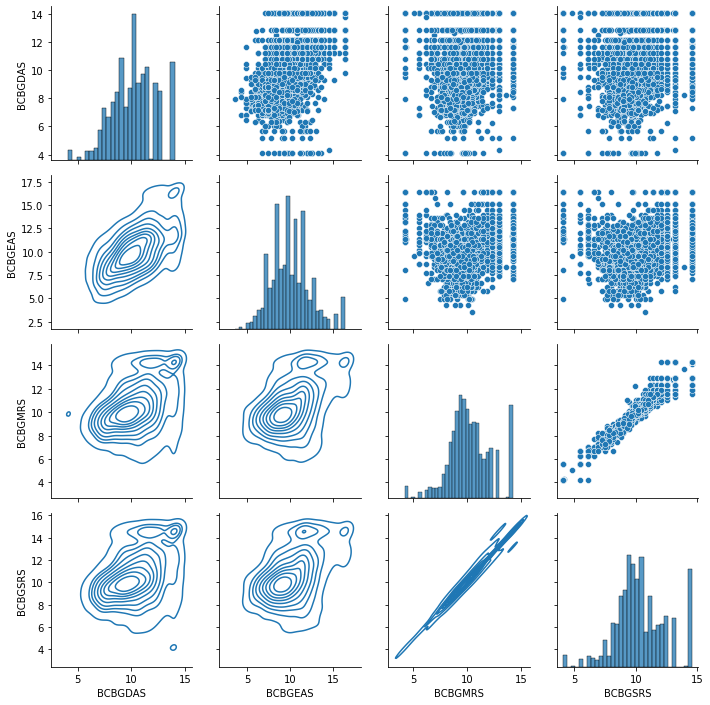

In [25]:
# plot the relationships between discipline, academics, and shortages
g = sns.PairGrid(school.loc[:,[col for col in school.columns if 'BCBG' in col]])
# upper graphs show possible correlations
g.map_upper(sns.scatterplot)
# lower maps show concentration of relational information
g.map_lower(sns.kdeplot)
# examine distribution of scores along the diagonal
g.map_diag(sns.histplot)

**Initial Observations about `school` dataset:**
* School discipline problems and focus on academic success do not seem correlated with each other or resource shortages
* Math and science resource shortages are strongly correlated; schools seem to be investing or struggling in both math and science equally
* There are many schools with hardly any struggles with discipline or resources, while most other schools are spread equally across the spectrum

**`school` Data Preparation**
* drop unnecessary columns
* convert IDCNTRY, IDSCHOOL to integers
* Convert BCDGDAS, BCDGEAS, BCDGMRS, BCDGSRS, BCDGSBC to ordered categoricals
* rename all columns to be more descriptive
* merge with student performance by school

In [26]:
# investigate student assessment (stud_ach) dataframe
stud_ach.head()

IDCNTRY      IDBOOK  IDSCHOOL   IDCLASS      IDSTUD BNRGCAL1 BNRGCAL2  \
0    784.0  Booklet 11    5001.0  500102.0  50010201.0      NaN      NaN   
1    784.0  Booklet 12    5001.0  500102.0  50010202.0      NaN      NaN   
2    784.0  Booklet 13    5001.0  500102.0  50010203.0      NaN      NaN   
3    784.0  Booklet 14    5001.0  500102.0  50010204.0      NaN      NaN   
4    784.0  Booklet 02    5001.0  500102.0  50010207.0      NaN      NaN   

   IDPOP     IDGRADER  IDGRADE ITLANG_SA           LCID_SA ITSEX  BSDAGE  \
0  Pop 2  Upper Grade  Grade 8   English  English (U.A.E.)  Male   13.58   
1  Pop 2  Upper Grade  Grade 8   English  English (U.A.E.)  Male   13.75   
2  Pop 2  Upper Grade  Grade 8   English  English (U.A.E.)  Male   13.50   
3  Pop 2  Upper Grade  Grade 8   English  English (U.A.E.)  Male   14.00   
4  Pop 2  Upper Grade  Grade 8   English  English (U.A.E.)  Male   13.33   

              ITADMINI                                           ILRELIAB  \
0  Teacher from School  Students Booklet was used for Reliability Scoring   
1  Teacher from School  Students Booklet was used for Reliability Scoring   
2  Teacher from School  Students Booklet was used for Reliability Scoring   
3  Teacher from School  Students Booklet was used for Reliability Scoring   
4  Teacher from School  Students Booklet not used for Reliability Scoring   

   MP52024_val  MP52058_val  MP52125_val  MP52229_val  MP52063_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          0.0          0.0          1.0          0.0          1.0   
4          NaN          NaN          NaN          NaN          NaN   

   MP52072_val  MP52146_val  MP52092_val  MP52046_val  MP52083_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          1.0          1.0          0.0          1.0          0.0   
4          NaN          NaN          NaN          NaN          NaN   

   MP52082_val  MP52161_val  MP52418_val  MP72007_val  MP72025_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          1.0          0.0          0.0          NaN          NaN   
4          NaN          NaN          NaN          1.0          0.0   

   MP72017_val  MP72190_val  MP72068_val  MP72076_val  MP72056_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          0.0          1.0          0.0          1.0          1.0   

   MP72098_val  MP72103_val  MP72121_val  MP72180_val  MP72198_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          1.0          1.0          1.0          1.0          1.0   

   MP72227_val  MP72170_val  MP72209_val  MP62005_val  MP62139_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          1.0          0.0          0.0          1.0          0.0   

   MP62164_val  MP62142_val  MP62084_val  MP62351_val  MP62223_val  \
0          NaN          NaN   

In [27]:
# create a list to drop all null columns and any columns that online contain one unique entry
stud_ach_drop_new = list(stud_ach.columns[stud_ach.isna().all()])+list(stud_ach.columns[stud_ach.nunique()==1])

In [28]:
# display descriptive statisticis for quantitative columns in the dataframe
stud_ach.describe()

IDCNTRY      IDSCHOOL        IDCLASS        IDSTUD        BSDAGE  \
count  88304.000000  88304.000000   88304.000000  8.830400e+04  87988.000000   
mean     592.080812   5199.689131  519972.217646  5.199724e+07     14.343526   
std      266.575620    158.416004   15841.387049  1.584139e+06      0.998248   
min       36.000000   5001.000000  500101.000000  5.001010e+07      9.170000   
25%      392.000000   5075.000000  507501.000000  5.075011e+07     13.670000   
50%      710.000000   5154.000000  515406.000000  5.154061e+07     14.170000   
75%      784.000000   5284.000000  528402.000000  5.284020e+07     14.750000   
max      926.000000   5631.000000  563102.000000  5.631021e+07     19.000000   

        MP52024_val   MP52058_val   MP52125_val   MP52229_val   MP52063_val  \
count  12293.000000  12048.000000  12394.000000  11820.000000  12309.000000   
mean       0.430733      0.213645      0.402614      0.430034      0.391583   
std        0.495199      0.409896      0.490444      0.495101      0.488124   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      0.000000      1.000000      1.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

        MP52072_val   MP52146_val   MP52092_val   MP52046_val   MP52083_val  \
count  12412.000000  11923.000000  12223.000000  12193.000000  11964.000000   
mean       0.541331      0.159188      0.262292      0.287296      0.330826   
std        0.498309      0.365867      0.439899      0.452519      0.470530   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        1.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      0.000000      1.000000      1.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

        MP52082_val   MP52161_val   MP52418_val   MP72007_val   MP72025_val  \
count  12297.000000  12158.000000  12141.000000  12390.000000  12259.000000   
mean       0.473530      0.581263      0.209208      0.144068      0.422465   
std        0.499319      0.493372      0.406760      0.351173      0.493972   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      1.000000      0.000000      0.000000      0.000000   
75%        1.000000      1.000000      0.000000      0.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

        MP72017_val   MP72190_val   MP72068_val   MP72076_val   MP72056_val  \
count  10817.000000  11806.000000  12340.000000  12242.000000  11304.000000   
mean       0.172229      0.501186      0.582172      0.401977      0.359253   
std        0.377597      0.500020      0.493222      0.490317      0.479803   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      1.000000      1.000000      0.000000      0.000000   
75%        0.000000      1.000000      1.000000      1.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

        MP72098_val   MP72103_val   MP72121_val   MP72180_val   MP72198_val  \
count  11271.000000  12040.000000  11847.000000  12056.000000  11105.000000   
mean       0.222695      0.443522      0.495991      0.391506      0.315804   
std        0.416074      0.496821      0.500005      0.488107      0.464856   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000 

In [29]:
# display the datatype for all columsn that are not averages or standard deviations of scores
stud_ach.loc[:,[col for col in stud_ach.columns if '_val' not in col and '_avg' not in col and '_sd' not in col]].dtypes

IDCNTRY      float64
IDBOOK        object
IDSCHOOL     float64
IDCLASS      float64
IDSTUD       float64
BNRGCAL1      object
BNRGCAL2      object
IDPOP         object
IDGRADER      object
IDGRADE       object
ITLANG_SA     object
LCID_SA       object
ITSEX         object
BSDAGE       float64
ITADMINI      object
ILRELIAB      object
dtype: object

In [30]:
# display the label information for every code that is not an assessment item
stud_ach_codes.loc[[col for col in stud_ach.columns if '_val' not in col and '_avg' not in col and '_sd' not in col],:]

Label
Variable                                                  
IDCNTRY                      Country ID - Numeric ISO Code
IDBOOK                                Student Test Booklet
IDSCHOOL                                         School ID
IDCLASS                                           Class ID
IDSTUD                                          Student ID
BNRGCAL1               CALCULATOR SURVEY\USE OF CALCULATOR
BNRGCAL2   CALCULATOR SURVEY\FREQUENCY OF USING CALCULATOR
IDPOP                                        Population ID
IDGRADER                             Standardized Grade ID
IDGRADE                                           Grade ID
ITLANG_SA             Language of Student Achievement Test
LCID_SA              Locale ID of Student Achievement Test
ITSEX                                      Sex of Students
BSDAGE                                        Students Age
ITADMINI                       Test Administrator Position
ILRELIAB                         Reliability Coding Status

In [31]:
# add additional nonrelevant information to be dropped
stud_ach_drop_new = stud_ach_drop_new+['BNRGCAL1','BNRGCAL2','ITADMINI','ILRELIAB']
stud_ach_drop_new

['MP62342_val',
 'MP72038_val',
 'MP62048_val',
 'SP62272_val',
 'SP52221_val',
 'SP72133_val',
 'SP72048_val',
 'SP62036_val',
 'SP72906_val',
 'SP72329_val',
 'SP62266_val',
 'IDPOP',
 'IDGRADER',
 'BNRGCAL1',
 'BNRGCAL2',
 'ITADMINI',
 'ILRELIAB']

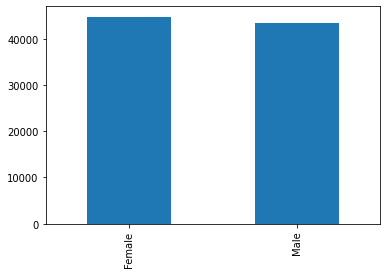

In [32]:
# graph the different counts of gender in the dataset
stud_ach['ITSEX'].value_counts().plot(kind='bar');

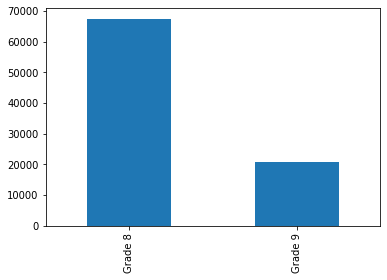

In [33]:
# graph the different counts of 8th graders vs. 9th graders
stud_ach['IDGRADE'].value_counts().plot(kind='bar');

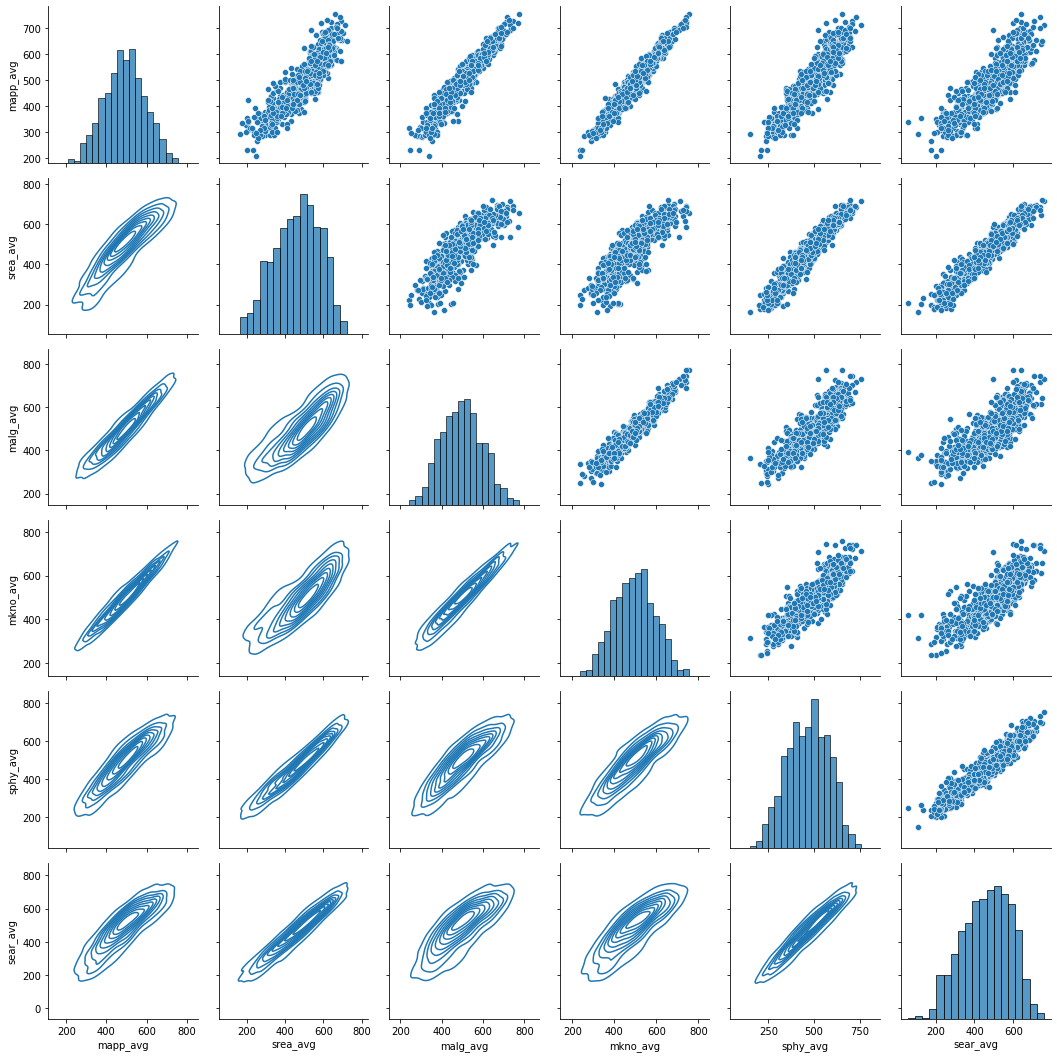

In [34]:
# plot distributions and relationships for a random sample of 1000 students and scores in 6 random categories
g = sns.PairGrid(stud_ach.sample(1000).loc[:,random.sample([col for col in stud_ach.columns if '_avg' in col],6)])
# upper graphs show possible correlations
g.map_upper(sns.scatterplot)
# lower graphs show concentration of the correlation data
g.map_lower(sns.kdeplot)
# the diagonal graphs show the distribution of the scores in the 6 categories
g.map_diag(sns.histplot)

**Initial Observations about `stud_ach` dataset:**
* All mathematical understanding is closely related (strong correlation)
* All science understanding is closely related (strong correlation)
* The relationship between science and math has more variance - is this due to subject differences or the difference in teaching?

**`stud_ach` Data Preparation**
* drop unnecessary (or null) columns
* convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD to integers
* trim and convert IDBOOK, IDGRADE to integer
* rename all columns to be more descriptive

In [35]:
# explore the basic info for teh student dataframe
student.head()

IDCNTRY      IDBOOK  IDSCHOOL   IDCLASS      IDSTUD BSBG01         BSBG03  \
0    784.0  Booklet 11    5001.0  500102.0  50010201.0    Boy  Almost always   
1    784.0  Booklet 12    5001.0  500102.0  50010202.0    Boy  Almost always   
2    784.0  Booklet 13    5001.0  500102.0  50010203.0    Boy         Always   
3    784.0  Booklet 14    5001.0  500102.0  50010204.0    Boy  Almost always   
4    784.0  Booklet 02    5001.0  500102.0  50010207.0    Boy  Almost always   

                                   BSBG04 BSBG05A BSBG05B BSBG05C BSBG05D  \
0  Enough to fill one shelf (11–25 books)     Yes     Yes     Yes     Yes   
1  Enough to fill one shelf (11–25 books)     Yes     Yes     Yes     Yes   
2           None or very few (0–10 books)     Yes      No     Yes      No   
3  Enough to fill one shelf (11–25 books)     Yes     Yes     Yes     Yes   
4  Enough to fill one shelf (11–25 books)     Yes     Yes     Yes     Yes   

  BSBG05E BSBG05F BSBG05G BSBG05H BSBG05I  \
0     Yes     Yes     Yes     Yes     Yes   
1     Yes     Yes     Yes     Yes     Yes   
2     Yes      No     Yes      No     Yes   
3     Yes     Yes     Yes     Yes     Yes   
4     Yes     Yes     Yes     Yes     Yes   

                                             BSBG06A  \
0  <Post-secondary, non-tertiary education—ISCED ...   
1     <Short-cycle tertiary education—ISCED Level 5>   
2                                                NaN   
3     <Short-cycle tertiary education—ISCED Level 5>   
4     <Short-cycle tertiary education—ISCED Level 5>   

                                             BSBG06B  \
0     <Bachelor’s or equivalent level—ISCED Level 6>   
1     <Short-cycle tertiary education—ISCED Level 5>   
2     <Short-cycle tertiary education—ISCED Level 5>   
3     <Short-cycle tertiary education—ISCED Level 5>   
4  <Post-secondary, non-tertiary education—ISCED ...   

                                              BSBG07 BSBG08A BSBG08B BSBG09A  \
0  Finish <Bachelor’s or equivalent level—ISCED L...     Yes     Yes     Yes   
1  Finish <Bachelor’s or equivalent level—ISCED L...     Yes     Yes     Yes   
2   Finish <Lower secondary education—ISCED Level 2>     Yes      No     Yes   
3  Finish <Bachelor’s or equivalent level—ISCED L...     Yes     Yes     Yes   
4  Finish <Bachelor’s or equivalent level—ISCED L...     Yes     Yes     Yes   

  BSBG09B                 BSBG10    BSBG11A    BSBG11B BSBG12A BSBG12B  \
0     NaN  Never or almost never  Sometimes  Sometimes     Yes     Yes   
1     NaN  Never or almost never  Sometimes  Sometimes     Yes     Yes   
2     NaN  Never or almost never  Sometimes  Sometimes     Yes     Yes   
3     NaN  Never or almost never  Sometimes  Sometimes     Yes     Yes   
4     NaN  Never or almost never  Sometimes  Sometimes     Yes     Yes   

  BSBG12C BSBG12D BSBG12E BSBG12F  IDPOP  IDGRADE ITLANG_SQ           LCID_SQ  \
0     Yes     Yes     Yes     Yes  Pop 2  Grade 8   English  English (U.A.E.)   
1     Yes     Yes     Yes     Yes  Pop 2  Grade 8   English  English (U.A.E.)   
2     Yes     Yes     Yes     Yes  Pop 2  Grade 8   English  English (U.A.E.)   
3     Yes     Yes     Yes     Yes  Pop 2  Grade 8   English  English (U.A.E.)   
4     Yes     Yes     Yes     Yes  Pop 2  Grade 8   English  English (U.A.E.)   

  ITLANG_SA           LCID_SA ITSEX  BSDAGE   BSBGHER         BSDGHER  \
0   English  English (U.A.E.)  Male   13.58  10.84499  Some Resources   
1   English  English (U.A.E.)  Male   13.75  10.23835  Some Resources   
2   English  English (U.A.E.)  Male   13.50   9.03613  Some Resources   
3   English  English (U.A.E.)  Male   14.00  10.23835  Some Resources   
4   English  English (U.A.E.)  Male   13.33  10.23835  Some Resources   

    BSBGSSB                         BSDGSSB    BSBGSB                 BSDGSB  \
0  12.80573  High Sense of School Belonging  12.93734  Never or Almost Never   
1  13.27199  High Sense of School Belonging  12.93734  Never or Almost Never   
2  13.27199  High Sens

In [36]:
# create a list to drop all empty or unnecessary columns (containing only one value)
student_drop_new = list(student.columns[student.isna().all()])+list(student.columns[student.nunique()==1])

In [37]:
# display the basic quality information for the student dataframe
student.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88304 entries, 0 to 88303
Data columns (total 93 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IDCNTRY    88304 non-null  float64
 1   IDBOOK     88304 non-null  object 
 2   IDSCHOOL   88304 non-null  float64
 3   IDCLASS    88304 non-null  float64
 4   IDSTUD     88304 non-null  float64
 5   BSBG01     87297 non-null  object 
 6   BSBG03     86834 non-null  object 
 7   BSBG04     86645 non-null  object 
 8   BSBG05A    86705 non-null  object 
 9   BSBG05B    86581 non-null  object 
 10  BSBG05C    82935 non-null  object 
 11  BSBG05D    86288 non-null  object 
 12  BSBG05E    86579 non-null  object 
 13  BSBG05F    73932 non-null  object 
 14  BSBG05G    68018 non-null  object 
 15  BSBG05H    60941 non-null  object 
 16  BSBG05I    57731 non-null  object 
 17  BSBG06A    83409 non-null  object 
 18  BSBG06B    83229 non-null  object 
 19  BSBG07     84537 non-null  object 
 20  BSBG08

In [38]:
# display descriptive statistics of the quantitative information of the student dataframe
student.describe()

IDCNTRY      IDSCHOOL        IDCLASS        IDSTUD        BSDAGE  \
count  88304.000000  88304.000000   88304.000000  8.830400e+04  87988.000000   
mean     592.080812   5199.689131  519972.217646  5.199724e+07     14.343526   
std      266.575620    158.416004   15841.387049  1.584139e+06      0.998248   
min       36.000000   5001.000000  500101.000000  5.001010e+07      9.170000   
25%      392.000000   5075.000000  507501.000000  5.075011e+07     13.670000   
50%      710.000000   5154.000000  515406.000000  5.154061e+07     14.170000   
75%      784.000000   5284.000000  528402.000000  5.284020e+07     14.750000   
max      926.000000   5631.000000  563102.000000  5.631021e+07     19.000000   

            BSBGHER       BSBGSSB        BSBGSB       BSBGSLM       BSBGICM  \
count  85704.000000  86408.000000  82729.000000  86505.000000  86342.000000   
mean      10.176311      9.826904      9.512116      9.997968     10.094523   
std        1.661136      1.985017      2.019319      1.913187      2.020215   
min        4.552080      3.924400      1.953440      5.094840      3.695680   
25%        9.036130      8.460960      8.093670      8.770110      8.518960   
50%       10.238350      9.408010      9.285930      9.866380      9.926750   
75%       11.190790     11.622520     10.418030     11.148590     11.651150   
max       13.515430     13.271990     12.937340     13.848490     13.018850   

            BSBGDML       BSBGSCM       BSBGSVM       BSBGSLS       BSBGICS  \
count  86192.000000  86131.000000  85936.000000  77999.000000  77802.000000   
mean       9.775472      9.986303     10.045867     10.011256      9.992467   
std        2.074872      2.065660      2.038530      2.009103      1.993367   
min        5.566330      3.277930      3.036820      3.846500      4.022730   
25%        8.444350      8.997360      8.578290      8.696610      8.528200   
50%        9.711010      9.672300      9.980680      9.804040      9.890780   
75%       11.103430     10.849510     11.301900     11.533000     11.431060   
max       14.673710     15.851880     13.482930     13.517780     12.633860   

            BSBGSCS       BSBGSVS      BSBGSLB      BSBGICB      BSBGSCB  \
count  77668.000000  85250.000000  7860.000000  7802.000000  7789.000000   
mean      10.012710     10.131787    10.323129    10.241666    10.035638   
std        1.945214      1.926367     2.022723     2.030418     2.031045   
min        3.249920      4.283400     3.770330     3.805730     3.049750   
25%        8.873810      8.817250     8.868440     8.805370     8.768360   
50%        9.615810      9.895320    10.095240    10.378180     9.628410   
75%       11.024140     11.799720    11.404230    11.547870    10.979050   
max       14.841820     12.936700    13.864760    12.776070    14.925630   

           BSBGSLE      BSBGICE      BSBGSCE      BSBGSLC      BSBGICC  \
count  3330.000000  3325.000000  3325.000000  7869.000000  7832.000000   
mean     10.712933    10.246788    10.058352    10.359569    10.282164   
std       1.947171     1.811098     1.842337     1.938823     2.008786   
min       4.020150     4.198000     3.210940     4.381810     4.449820   
25%       9.382580     8.945040     8.807510     9.178520     9.026240   
50%      10.363410    10.510120     9.665740    10.056960    10.527730   
75%      12.112890    11.608490    11.013050    11.494970    12.636810   
max      14.057380    12.753610    14.910220    13.776840    12.636810   

           BSBGSCC      BSBGSLP      BSBGICP      BSBGSCP       BSBGSEC  
count  7819.000000  7834.000000  7800.000000  7771.000000  48517.000000  
mean     10.259290    10.399357    10.302456    10.300245     10.233552  
std       2.005416     1.940148     1.989773     2.019097      1.910295  
min       3.896350     4.500520     4.575930     3.904790      3.210100  
25%       9.274000     9.145480     8.774900     9.166940      8.991280  
50%       9.767540    10.223820    10.591630     9.912420     10.168600

In [39]:
# display the contextual information for each column
student_codes.loc[student.columns,:]

Label
IDCNTRY                        Country ID - Numeric ISO Code
IDBOOK                                  Student Test Booklet
IDSCHOOL                                           School ID
IDCLASS                                             Class ID
IDSTUD                                            Student ID
BSBG01                                    GEN\SEX OF STUDENT
BSBG03                GEN\OFTEN SPEAK <LANG OF TEST> AT HOME
BSBG04                      GEN\AMOUNT OF BOOKS IN YOUR HOME
BSBG05A                     GEN\HOME POSSESS\COMPUTER TABLET
BSBG05B                          GEN\HOME POSSESS\STUDY DESK
BSBG05C                            GEN\HOME POSSESS\OWN ROOM
BSBG05D                 GEN\HOME POSSESS\INTERNET CONNECTION
BSBG05E                    GEN\HOME POSSESS\OWN MOBILE PHONE
BSBG05F                  GEN\HOME POSSESS\<COUNTRY SPECIFIC>
BSBG05G                  GEN\HOME POSSESS\<COUNTRY SPECIFIC>
BSBG05H                  GEN\HOME POSSESS\<COUNTRY SPECIFIC>
BSBG05I                  GEN\HOME POSSESS\<COUNTRY SPECIFIC>
BSBG06A        GEN\HIGHEST LVL OF EDU OF <PARENT/GUARDIAN A>
BSBG06B        GEN\HIGHEST LVL OF EDU OF <PARENT/GUARDIAN B>
BSBG07                GEN\HOW FAR IN EDU DO YOU EXPECT TO GO
BSBG08A            GEN\<PARENT/GUARDIAN A> BORN IN <COUNTRY>
BSBG08B            GEN\<PARENT/GUARDIAN B> BORN IN <COUNTRY>
BSBG09A                                GEN\BORN IN <COUNTRY>
BSBG09B            GEN\BORN IN <COUNTRY>\AGE CAME TO COUNTRY
BSBG10                GEN\ABOUT HOW OFTEN ABSENT FROM SCHOOL
BSBG11A                                  GEN\HOW OFTEN\TIRED
BSBG11B                                 GEN\HOW OFTEN\HUNGRY
BSBG12A                    GEN\INTERNET USE\ACCESS TEXTBOOKS
BSBG12B                  GEN\INTERNET USE\ACCESS ASSIGNMENTS
BSBG12C         GEN\INTERNET USE\COLLABORATE WITH CLASSMATES
BSBG12D            GEN\INTERNET USE\COMMUNICATE WITH TEACHER
BSBG12E     GEN\INTERNET USE\FIND INFO TO AID IN MATH OR SCI
BSBG12F               GEN\INTERNET USE\ACCESS LEARNING GAMES
IDPOP                                          Population ID
IDGRADE                                             Grade ID
ITLANG_SQ          Language of Student Context Questionnaire
LCID_SQ           Locale ID of Student Context Questionnaire
ITLANG_SA               Language of Student Achievement Test
LCID_SA                Locale ID of Student Achievement Test
ITSEX                                        Sex of Students
BSDAGE                                          Students Age
BSBGHER                       Home Educational Resources/SCL
BSDGHER                       Home Educational Resources/IDX
BSBGSSB               Students Sense of School Belonging/SCL
BSDGSSB               Students Sense of School Belonging/IDX
BSBGSB                                  Student Bullying/SCL
BSDGSB                                  Student Bullying/IDX
BSBGSLM       Students Like Learning Mathematics Lessons/SCL
BSDGSLM       Students Like Learning Mathematics Lessons/IDX
BSBGICM     Instructional Clarity in Mathematics Lessons/SCL
BSDGICM     Instructional Clarity in Mathematics Lessons/IDX
BSBGDML          Disorderly Behavior during Math Lessons/SCL
BSDGDML          Disorderly Behavior during Math Lessons/IDX
BSBGSCM                 Student Confident in Mathematics/SCL
BSDGSCM                 Student Confident in Mathematics/IDX
BSBGSVM                       Students Value Mathematics/SCL
BSDGSVM                       Students Value Mathematics/IDX
BSBGSLS                   Students Like Learning Science/SCL
BSDGSLS                   Students Like Learning Science/IDX
BSBGICS         Instructional Clarity in Science Lessons/SCL
BSDGICS         Instructional Clarity in Science Lessons/IDX
BSBGSCS                     Student Confident in Science/SCL
BSDGSCS                     Student Confident in Science/IDX
BSBGSVS                           Students Value Science/SCL
BSDGSVS                           Students Value Science/IDX
BSBGSLB                   Stu

In [40]:
# investigate the unique entries on some of the qualitative data
student['BSDGSB'].unique()

array(['Never or Almost Never', 'About Monthly', 'About Weekly', nan],
      dtype=object)

In [41]:
# investigate some of the data that appears to have two different languages
student.query('ITLANG_SQ != ITLANG_SA and ITLANG_SQ == ITLANG_SQ')

IDCNTRY      IDBOOK  IDSCHOOL   IDCLASS      IDSTUD BSBG01  \
302      784.0  Booklet 03    5010.0  501004.0  50100401.0   Girl   
303      784.0  Booklet 04    5010.0  501004.0  50100402.0   Girl   
304      784.0  Booklet 05    5010.0  501004.0  50100403.0   Girl   
305      784.0  Booklet 06    5010.0  501004.0  50100404.0   Girl   
306      784.0  Booklet 07    5010.0  501004.0  50100405.0   Girl   
...        ...         ...       ...       ...         ...    ...   
54495    422.0  Booklet 12    5166.0  516605.0  51660524.0    Boy   
54719    422.0  Booklet 14    5175.0  517504.0  51750424.0   Girl   
55303    422.0  Booklet 10    5201.0  520101.0  52010104.0   Girl   
55304    422.0  Booklet 11    5201.0  520101.0  52010105.0    Boy   
74059    710.0  Booklet 10    5170.0  517003.0  51700317.0    Boy   

              BSBG03                                             BSBG04  \
302           Always       Enough to fill two bookcases (101–200 books)   
303           Always       Enough to fill two bookcases (101–200 books)   
304    Almost always             Enough to fill one shelf (11–25 books)   
305           Always       Enough to fill two bookcases (101–200 books)   
306           Always         Enough to fill one bookcase (26–100 books)   
...              ...                                                ...   
54495  Almost always  Enough to fill three or more bookcases (more t...   
54719      Sometimes             Enough to fill one shelf (11–25 books)   
55303      Sometimes                      None or very few (0–10 books)   
55304  Almost always                      None or very few (0–10 books)   
74059         Always                      None or very few (0–10 books)   

      BSBG05A BSBG05B BSBG05C BSBG05D BSBG05E BSBG05F BSBG05G BSBG05H BSBG05I  \
302       Yes     Yes     Yes     Yes     Yes     Yes     Yes     Yes     Yes   
303       Yes     Yes     Yes     Yes     Yes     Yes     Yes     Yes     Yes   
304       Yes     Yes     Yes     Yes     Yes     Yes     Yes      No      No   
305       Yes     Yes     Yes     Yes      No     Yes     Yes     Yes      No   
306       Yes     Yes     Yes     Yes     Yes     Yes     Yes     Yes     Yes   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
54495     Yes     Yes     Yes      No      No     Yes     NaN     NaN     NaN   
54719     Yes     Yes      No      No     Yes      No     NaN     NaN     NaN   
55303     Yes     Yes      No     Yes     Yes     Yes     NaN     NaN     NaN   
55304     Yes     Yes     Yes     Yes     Yes     Yes     NaN     NaN     NaN   
74059      No     Yes     Yes      No     Yes      No     Yes     Yes      No   

                                                 BSBG06A  \
302    <Postgraduate degree: Master’s—ISCED Level 7 o...   
303    <Postgraduate degree: Master’s—ISCED Level 7 o...   
304                                         I don’t know   
305       <Bachelor’s or equivalent level—ISCED Level 6>   
306                                         I don’t know   
...                                                  ...   
54495          <Lower secondary education—ISCED Level 2>   
54719                                       I don’t know   
55303                                       I don’t know   
55304                                     Not applicable   
74059          <Lower secondary education—ISCED Level 2>   

                                                 BSBG06B  \
302    <Postgraduate degree: Master’s—ISCED Level 7 o...   
303            <Upper secondary education—ISCED Level 3>   
304                                         I don’t know   
305       <Bachelor’s or equivalent level—ISCED Level 6>   
306            <Upper secondary education—ISCED Level 3>   
...                                                  ...   
54495          <Upper secondary education—ISCED Level 3>   
54719     <Bachelor’s or equivalent level—ISCED Level 6>   
55303                                      

In [42]:
# add additional nonrelevant data to be dropped from the dataframe
student_drop_new = student_drop_new + ['BSBG01','LCID_SQ','LCID_SA']

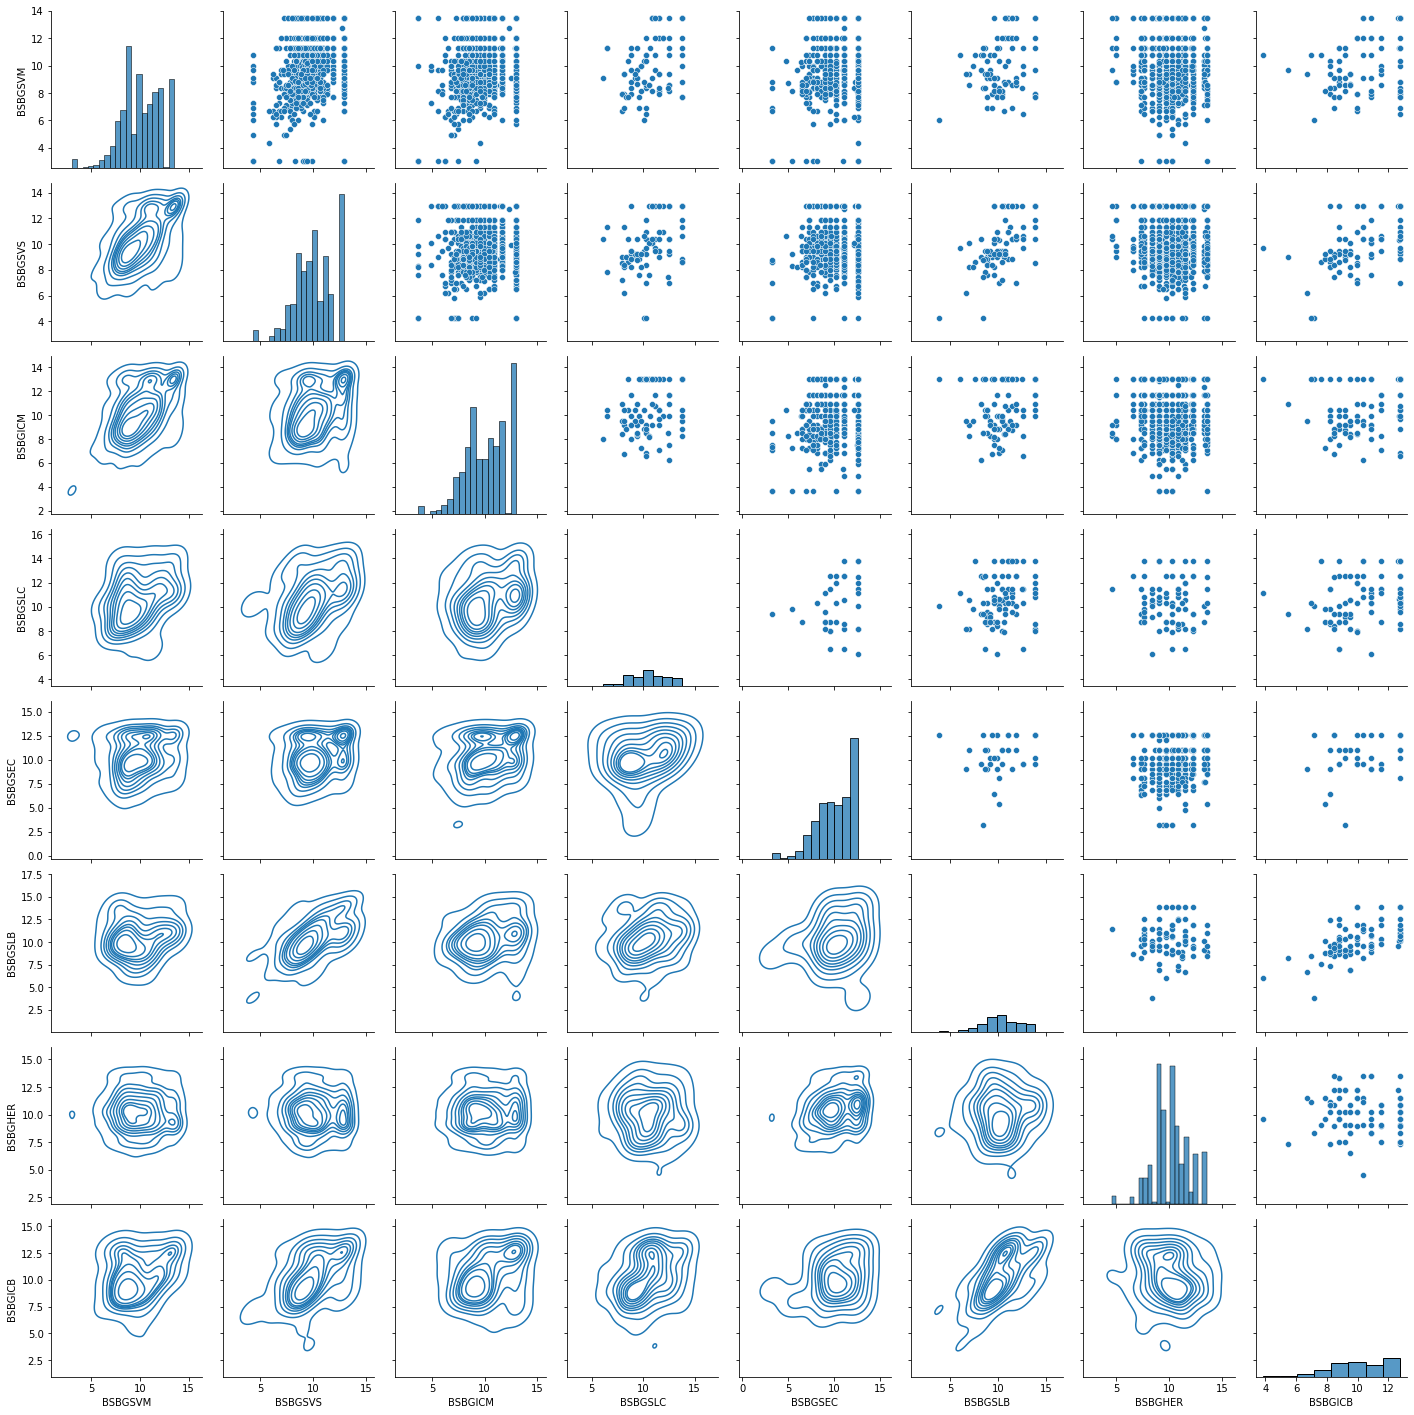

In [43]:
# visualize the relationships between a selection of the available scores for student demographics (1000 randomly sampled students, 8 random sampled variables)
g = sns.PairGrid(student.sample(1000).loc[:,random.sample([col for col in student.columns if 'BSBG' in col and student[col].dtype == 'float64'],8)])
# upper graphs will show correlation
g.map_upper(sns.scatterplot)
# lower graphs will show data concentration
g.map_lower(sns.kdeplot)
# diagonal graphs will show the distribution of each variable
g.map_diag(sns.histplot)

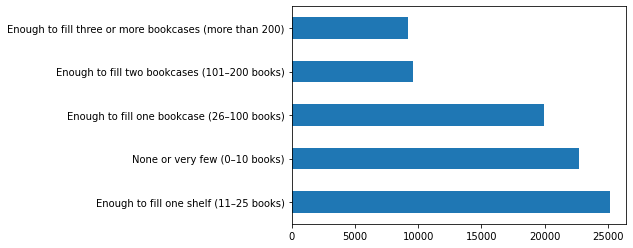

In [44]:
# visualize the number of books at home for each student
student['BSBG04'].value_counts().plot(kind='barh');

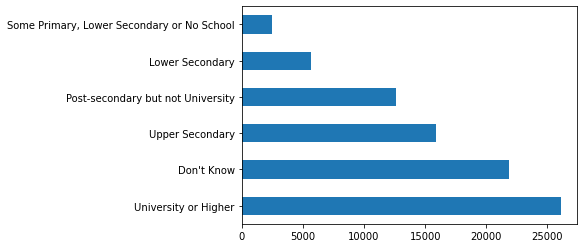

In [45]:
# visualize the highest level of education achieved by the parents of the student
student['BSDGEDUP'].value_counts().plot(kind='barh');

**Initial Observations about `student` dataset:**
* Apparent correlation between instructional clarity across all science classes (possible link to instructional quality at the school level)
* Wide variance in the number of books in the home
* Wide variance in highest parental education, but university is most common

**`student` Data Preparation**
* drop unnecessary columns
* convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD to integers
* trim and convert IDBOOK, IDGRADE to integers
* convert to integer and combine BSBG05* columns to home_possession column
* convert to integer and combine BSBG09* columns to age_immigration column
* convert to integer and combine BSBG12* columns to internet_access column
* convert BSBG03, BSBG04, BSBG10, BSBG11*, BSDG* columns to ordered categoricals
* trim and convert BSBG06A, BSBG06B, BSBG07 to ordered categoricals (ISCED level)
* convert BSBG08* to boolean
* rename all columns to be more descriptive
* merge with student performance

In [46]:
# explore basic structure of stud_teach dataset
stud_teach.head()

IDCNTRY      IDBOOK  IDSCHOOL   IDCLASS      IDSTUD    IDTEALIN   IDTEACH  \
0    784.0  Booklet 11    5001.0  500102.0  50010201.0  50010203.0  500102.0   
1    784.0  Booklet 11    5001.0  500102.0  50010201.0  50010101.0  500101.0   
2    784.0  Booklet 12    5001.0  500102.0  50010202.0  50010101.0  500101.0   
3    784.0  Booklet 12    5001.0  500102.0  50010202.0  50010203.0  500102.0   
4    784.0  Booklet 13    5001.0  500102.0  50010203.0  50010203.0  500102.0   

   IDLINK  IDPOP  IDGRADE       IDSUBJ            ITCOURSE  NMTEACH  NSTEACH  \
0     3.0  Pop 2  Grade 8      Science  Integrated science      1.0      1.0   
1     1.0  Pop 2  Grade 8  Mathematics         Mathematics      1.0      1.0   
2     1.0  Pop 2  Grade 8  Mathematics         Mathematics      1.0      1.0   
3     3.0  Pop 2  Grade 8      Science  Integrated science      1.0      1.0   
4     3.0  Pop 2  Grade 8      Science  Integrated science      1.0      1.0   

     mmat_avg    ssci_avg    malg_avg    mapp_avg    mdat_avg    mgeo_avg  \
0  550.550842  480.099946  517.042408  502.836180  485.677994  508.168950   
1  550.550842  480.099946  517.042408  502.836180  485.677994  508.168950   
2  326.129702  318.662552  323.233832  356.545632  302.030198  328.756934   
3  326.129702  318.662552  323.233832  356.545632  302.030198  328.756934   
4  393.169444  328.771868  420.589982  389.112222  371.349082  391.344424   

     mkno_avg    mnum_avg    mrea_avg    sapp_avg    sbio_avg    sche_avg  \
0  527.618686  535.162198  517.203196  459.227332  404.517518  443.350576   
1  527.618686  535.162198  517.203196  459.227332  404.517518  443.350576   
2  352.864178  355.017696  385.102162  315.159308  295.509340  324.683132   
3  352.864178  355.017696  385.102162  315.159308  295.509340  324.683132   
4  417.370708  386.164962  407.777500  310.335522  279.297756  321.583934   

     sear_avg    skno_avg    sphy_avg    srea_avg  
0  412.148076  471.580088  450.679538  464.316504  
1  412.148076  471.580088  450.679538  464.316504  
2  343.312374  323.550294  343.942730  315.274280  
3  343.312374  323.550294  343.942730  315.274280  
4  291.039122  313.976578  350.246454  315.896516

In [47]:
# create a list of columns to drop because they are null or have only one value
stud_teach_drop_new = list(stud_teach.columns[stud_teach.isna().all()])+list(stud_teach.columns[stud_teach.nunique()==1])

In [48]:
# also drop IDBOOK column
stud_teach_drop_new = stud_teach_drop_new + ['IDBOOK']

In [49]:
# investigate how many unique values each variable contains
stud_teach.nunique()

IDCNTRY        11
IDBOOK         14
IDSCHOOL      630
IDCLASS      2390
IDSTUD      62737
IDTEALIN     3998
IDTEACH      3005
IDLINK         34
IDPOP           1
IDGRADE         2
IDSUBJ          2
ITCOURSE        7
NMTEACH         6
NSTEACH         7
mmat_avg    88296
ssci_avg    88286
malg_avg    67465
mapp_avg    67469
mdat_avg    67470
mgeo_avg    67466
mkno_avg    67470
mnum_avg    67461
mrea_avg    67459
sapp_avg    88294
sbio_avg    88296
sche_avg    88288
sear_avg    88285
skno_avg    88285
sphy_avg    88287
srea_avg    88293
dtype: int64

In [50]:
# display summary information about stud_teach dataframe
stud_teach.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204212 entries, 0 to 204211
Data columns (total 30 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   IDCNTRY   204212 non-null  float64
 1   IDBOOK    204212 non-null  object 
 2   IDSCHOOL  204212 non-null  float64
 3   IDCLASS   204212 non-null  float64
 4   IDSTUD    204212 non-null  float64
 5   IDTEALIN  204212 non-null  float64
 6   IDTEACH   204212 non-null  float64
 7   IDLINK    204212 non-null  float64
 8   IDPOP     204212 non-null  object 
 9   IDGRADE   204212 non-null  object 
 10  IDSUBJ    204212 non-null  object 
 11  ITCOURSE  204212 non-null  object 
 12  NMTEACH   204212 non-null  float64
 13  NSTEACH   203882 non-null  float64
 14  mmat_avg  204212 non-null  float64
 15  ssci_avg  204212 non-null  float64
 16  malg_avg  161973 non-null  float64
 17  mapp_avg  161973 non-null  float64
 18  mdat_avg  161973 non-null  float64
 19  mgeo_avg  161973 non-null  float64
 20  mkno

In [51]:
# display summary statistics about the quantitative variables of stud_teach
stud_teach.describe()

IDCNTRY       IDSCHOOL        IDCLASS        IDSTUD  \
count  204212.000000  204212.000000  204212.000000  2.042120e+05   
mean      586.146808    5194.490764  519452.300604  5.194525e+07   
std       259.513368     157.398162   15739.691454  1.573970e+06   
min        36.000000    5001.000000  500101.000000  5.001010e+07   
25%       392.000000    5072.000000  507204.000000  5.072042e+07   
50%       710.000000    5149.000000  514902.000000  5.149022e+07   
75%       784.000000    5274.000000  527403.000000  5.274032e+07   
max       926.000000    5631.000000  563102.000000  5.631021e+07   

           IDTEALIN        IDTEACH         IDLINK        NMTEACH  \
count  2.042120e+05  204212.000000  204212.000000  204212.000000   
mean   5.194515e+07  519451.427022       2.536472       1.093300   
std    1.573981e+06   15739.805130       2.634168       0.449241   
min    5.001010e+07  500101.000000       1.000000       1.000000   
25%    5.072030e+07  507203.000000       1.000000       1.000000   
50%    5.149020e+07  514902.000000       2.000000       1.000000   
75%    5.274010e+07  527401.000000       3.000000       1.000000   
max    5.631030e+07  563103.000000      53.000000       6.000000   

             NSTEACH       mmat_avg       ssci_avg       malg_avg  \
count  203882.000000  204212.000000  204212.000000  161973.000000   
mean        1.461468     475.614389     469.892161     500.137639   
std         0.841410      99.935925     115.604618      98.583402   
min         0.000000     197.583022     107.046832     135.027972   
25%         1.000000     398.311881     385.027519     428.253868   
50%         1.000000     470.479778     478.653034     497.062050   
75%         2.000000     547.973551     558.619877     568.878410   
max         6.000000     844.245024     829.913918     883.787158   

            mapp_avg       mdat_avg       mgeo_avg       mkno_avg  \
count  161973.000000  161973.000000  161973.000000  161973.000000   
mean      490.689499     483.085888     489.046913     497.939644   
std       101.302370     110.816023     103.359808      96.733794   
min       162.346672     103.868646     121.671972     163.224438   
25%       416.693606     403.964986     414.666856     427.581662   
50%       490.664492     486.214516     487.819380     496.005634   
75%       563.782794     564.142368     562.719160     565.896924   
max       874.593228     850.120382     869.864216     864.777696   

            mnum_avg       mrea_avg       sapp_avg       sbio_avg  \
count  161973.000000  161973.000000  204212.000000  204212.000000   
mean      494.933563     494.608319     471.386163     468.372178   
std        96.483011      98.792634     116.412081     124.588915   
min       162.403816     144.273560      86.910532      43.654734   
25%       423.735392     424.031216     387.111378     378.863046   
50%       492.613128     494.500894     478.803038     480.500254   
75%       564.051932     564.723450     559.969845     563.752458   
max       883.122124     873.466996     824.890256     863.381694   

            sche_avg       sear_avg       skno_avg       sphy_avg  \
count  204212.000000  204212.000000  204212.000000  204212.000000   
mean      469.588052     464.966862     469.314689     468.403513   
std       115.742631     124.846341     119.384505     113.617449   
min        48.506870      14.672014      60.897174      80.839378   
25%       385.391922     374.750387     381.286779     386.665448   
50%       475.455236     475.625614     477.847260     473.786299   
75%       556.228106     561.096106     559.966916     553.954226   
max       840.819638     883.370896     875.553876     813.372414   

            srea_avg  
count  204212.000000  
mean      463.473556  
std       121.851572  
min        58.978432  
25%       376.815228  
50%       475.196063  
75%       557.592918  
max       820.829710

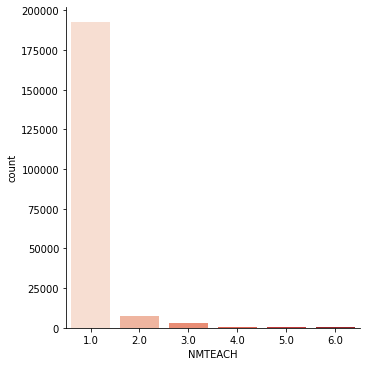

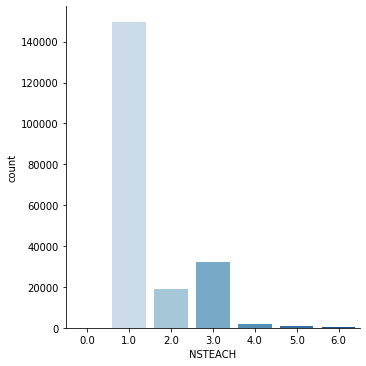

In [52]:
# plot the frequency of number of math and science teachers per individual student
sns.catplot(x='NMTEACH', kind='count', palette='Reds', data=stud_teach);
sns.catplot(x='NSTEACH', kind='count', palette='Blues', data=stud_teach);

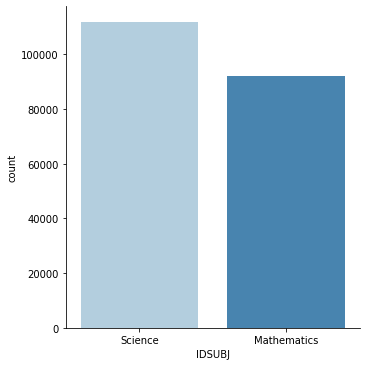

In [53]:
# plot the count of math and science teachers in the dataset
sns.catplot(x="IDSUBJ", kind="count", palette="Blues", data=stud_teach);

**Initial Observations about `stud_teach` dataset:**
* students are morel likey to have multiple science teachers than multiple math teachers
* there are more science teachers in the study than math teachers

**`stud_teach` Data Preparation**
* drop unnecessary columns
* convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD, IDTEALIN, IDTEACH, IDLINK, NMTEACH, NSTEACH to integers
* trim and convert IDGRADE to integers

In [54]:
# explore basic structure of the math_teach dataframe
math_teach.head()

IDCNTRY  IDSCHOOL    IDTEALIN   IDTEACH  IDLINK     ITCOURSE  BTBG01  \
0    784.0    5001.0  50010101.0  500101.0     1.0  Mathematics    17.0   
1    784.0    5001.0  50010102.0  500101.0     2.0  Mathematics    17.0   
2    784.0    5002.0  50020202.0  500202.0     2.0  Mathematics     1.0   
3    784.0    5003.0  50030101.0  500301.0     1.0  Mathematics     NaN   
4    784.0    5004.0  50040101.0  500401.0     1.0  Mathematics     1.0   

   BTBG02    BTBG03                                          BTBG04 BTBG05A  \
0    Male     40–49    <Master’s or equivalent level—ISCED Level 7>     Yes   
1    Male     40–49    <Master’s or equivalent level—ISCED Level 7>     Yes   
2  Female     25–29    <Master’s or equivalent level—ISCED Level 7>     Yes   
3     NaN       NaN                                             NaN     NaN   
4    Male  Under 25  <Bachelor’s or equivalent level—ISCED Level 6>      No   

  BTBG05B BTBG05C BTBG05D BTBG05E BTBG05F BTBG05G BTBG05H BTBG05I    BTBG06A  \
0      No     Yes     Yes      No     Yes     Yes      No      No  Very high   
1      No     Yes     Yes      No     Yes     Yes      No      No  Very high   
2      No      No      No      No      No      No      No      No       High   
3     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN        NaN   
4      No      No      No      No      No      No      No     Yes  Very high   

     BTBG06B    BTBG06C    BTBG06D    BTBG06E    BTBG06F    BTBG06G  \
0  Very high       High  Very high        Low        Low        Low   
1  Very high       High  Very high        Low        Low        Low   
2  Very high       High       High     Medium     Medium       High   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4  Very high  Very high  Very high  Very high  Very high  Very high   

     BTBG06H    BTBG06I    BTBG06J    BTBG06K    BTBG06L      BTBG07A  \
0     Medium     Medium     Medium       High  Very high  Agree a lot   
1     Medium     Medium     Medium       High  Very high  Agree a lot   
2     Medium     Medium     Medium       High       High  Agree a lot   
3        NaN        NaN        NaN        NaN        NaN          NaN   
4  Very high  Very high  Very high  Very high  Very high  Agree a lot   

       BTBG07B         BTBG07C            BTBG07D         BTBG07E  \
0  Agree a lot     Agree a lot     Agree a little     Agree a lot   
1  Agree a lot     Agree a lot     Agree a little     Agree a lot   
2  Agree a lot  Agree a little  Disagree a little  Agree a little   
3          NaN             NaN                NaN             NaN   
4  Agree a lot     Agree a lot        Agree a lot     Agree a lot   

             BTBG07F         BTBG07G         BTBG07H     BTBG08A     BTBG08B  \
0     Agree a little     Agree a lot     Agree a lot  Very often  Very often   
1     Agree a little     Agree a lot     Agree a lot  Very often  Very often   
2  Disagree a little  Agree a little  Agree a little  Very often  Very often   
3                NaN             NaN             NaN         NaN         NaN   
4        Agree a lot     Agree a lot     Agree a lot  Very often  Very often   

      BTBG08C     BTBG08D     BTBG08E         BTBG09A            BTBG09B  \
0  Very often  Very often  Very often  Disagree a lot  Disagree a little   
1  Very often  Very often  Very often  Disagree a lot  Disagree a little   
2  Very often  Very often  Very often  Disagree a lot     Agree a little   
3         NaN         NaN         NaN             NaN                NaN   
4  Very often  Very often  Very often  Agree a little        Agree a lot   

             BTBG09C            BTBG09D            BTBG09E            BTBG09F  \
0     Agree a little     Disagree a lot     Disagree a lot     Disagree a lot   
1     Agree a little     Disagree a lot     Disagree a lot     Disagree a lot   
2     Agree a little     Agree a little  Disagree a little     Disagree a lot   
3                NaN                NaN              

In [55]:
# create list of math_teach columns to drop (null or single unique value)
math_teach_drop_new = list(math_teach.columns[math_teach.isna().all()])+list(math_teach.columns[math_teach.nunique()==1])

In [56]:
# add a redundant language column to be dropped
math_teach_drop_new = math_teach_drop_new + ['LCID_T']

In [57]:
# display the summary statistics for the quantitative values
math_teach.describe()

IDCNTRY     IDSCHOOL      IDTEALIN        IDTEACH       IDLINK  \
count  4304.000000  4304.000000  4.304000e+03    4304.000000  4304.000000   
mean    577.481877  5185.593634  5.185611e+07  518561.052974     1.816914   
std     271.406404   154.215507  1.542157e+06   15421.570910     2.011108   
min      36.000000  5001.000000  5.001010e+07  500101.000000     1.000000   
25%     380.000000  5070.000000  5.070010e+07  507001.000000     1.000000   
50%     710.000000  5139.500000  5.139520e+07  513952.000000     1.000000   
75%     784.000000  5253.000000  5.253010e+07  525301.000000     2.000000   
max     926.000000  5631.000000  5.631020e+07  563102.000000    51.000000   

            BTBG01       BTBG10       BTBG11       BTBM14      BTBGEAS  \
count  3896.000000  3743.000000  3668.000000  3602.000000  3901.000000   
mean     14.716889    27.432274     4.537623   251.120766    10.302516   
std       9.901164    11.913556     9.272292    83.618842     2.376088   
min       0.000000     1.000000     0.000000     0.000000     0.873410   
25%       6.000000    21.000000     0.000000   210.000000     8.846900   
50%      13.000000    26.000000     0.000000   240.000000    10.051020   
75%      22.000000    32.000000     5.000000   300.000000    11.550050   
max      49.000000   118.000000   105.000000   700.000000    17.780680   

           BTBGLSN      BTBGSOS      BTBGTJS      BTDMNUM      BTDMALG  \
count  3789.000000  3889.000000  3890.000000  3793.000000  3793.000000   
mean      9.829225    10.299949    10.073434    98.207224    73.540985   
std       2.134490     2.341500     1.788579     8.156136    24.200447   
min       3.623690     4.426320     5.281180     0.000000     0.000000   
25%       8.632380     8.783370     8.482860   100.000000    57.142860   
50%       9.619100    10.072630    10.258740   100.000000    71.428570   
75%      11.288280    11.789980    11.745590   100.000000   100.000000   
max      15.295110    13.870350    11.745590   100.000000   100.000000   

           BTDMGEO      BTDMDAT  VERSION  
count  3794.000000  3783.000000   4304.0  
mean     80.532419    63.417922      4.0  
std      21.764363    34.986465      0.0  
min       0.000000     0.000000      4.0  
25%      66.666670    33.333330      4.0  
50%      83.333330    66.666670      4.0  
75%     100.000000   100.000000      4.0  
max     100.000000   100.000000      4.0

In [58]:
# display contextual information for a subset of the math_teach columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBG' not in col],:]

Label
Variable                                                   
IDCNTRY                       Country ID - Numeric ISO Code
IDSCHOOL                                          School ID
IDTEALIN                                Teacher ID and Link
IDTEACH                                          Teacher ID
IDLINK                                  Teacher Link Number
ITCOURSE                         Subject Code in instrument
BTBM14                   MATH\TIME SPENT MATH INSTR MINUTES
BTBM15A               MATH\ASK STUDENTS\EXPLAIN NEW CONTENT
BTBM15B              MATH\ASK STUDENTS\EXPLAIN HOW TO SOLVE
BTBM15C                    MATH\ASK STUDENTS\MEMORIZE RULES
BTBM15D               MATH\ASK STUDENTS\PRACTICE PROCEDURES
BTBM15E                MATH\ASK STUDENTS\APPLY WHAT LEARNED
BTBM15F               MATH\ASK STUDENTS\WORK IN WHOLE CLASS
BTBM15G              MATH\ASK STUDENTS\MIXED ABILITY GROUPS
BTBM15H               MATH\ASK STUDENTS\SAME ABILITY GROUPS
BTBM16                    MATH\PERMITTED TO USE CALCULATORS
BTBM17A       MATH\COMPUTER TABLET AVAILABILITY DURING MATH
BTBM17BA    MATH\ACCESS TO COMPUTER\EACH STD HAS A COMPUTER
BTBM17BB        MATH\ACCESS TO COMPUTER\CLASS HAS COMPUTERS
BTBM17BC       MATH\ACCESS TO COMPUTER\SCHOOL HAS COMPUTERS
BTBM17CA       MATH\LEARNING ACTIVITIES ON COMP\WHOLE CLASS
BTBM17CB    MATH\LEARNING ACTIVITIES ON COMP\LOW PERFORMING
BTBM17CC   MATH\LEARNING ACTIVITIES ON COMP\HIGH PERFORMING
BTBM17CD     MATH\LEARNING ACTIVITIES ON COMP\SPECIAL NEEDS
BTBM18AA                        MATH\TOPIC\NUMBER\COMPUTING
BTBM18AB             MATH\TOPIC\NUMBER\CONCEPT OF FRACTIONS
BTBM18AC         MATH\TOPIC\NUMBER\SOLVING PROB PROPORTIONS
BTBM18BA                     MATH\TOPIC\ALGEBRA\SIMPLIFYING
BTBM18BB                MATH\TOPIC\ALGEBRA\LINEAR EQUATIONS
BTBM18BC             MATH\TOPIC\ALGEBRA\LINEAR INEQUALITIES
BTBM18BD           MATH\TOPIC\ALGEBRA\SIMULTANEOUS EQUATION
BTBM18BE                       MATH\TOPIC\ALGEBRA\FUNCTIONS
BTBM18BF             MATH\TOPIC\ALGEBRA\PROPERTIES OF FUNCS
BTBM18BG                         MATH\TOPIC\ALGEBRA\NUMERIC
BTBM18CA           MATH\TOPIC\GEOMETRY\GEOMETRIC PROPERTIES
BTBM18CB        MATH\TOPIC\GEOMETRY\SOLVING PROB PERIMETERS
BTBM18CC       MATH\TOPIC\GEOMETRY\SOLVING PROB PYTHAGOREAN
BTBM18CD                    MATH\TOPIC\GEOMETRY\TRANSLATION
BTBM18CE              MATH\TOPIC\GEOMETRY\CONGRUENT FIGURES
BTBM18CF        MATH\TOPIC\GEOMETRY\THREE-DIMENSIONAL SHAPE
BTBM18DA      MATH\TOPIC\DATA\READING AND INTERPRETING DATA
BTBM18DB             MATH\TOPIC\DATA\IDENTIFYING PROCEDURES
BTBM18DC   MATH\TOPIC\DATA\ORGANIZING AND REPRESENTING DATA
BTBM18DD  MATH\TOPIC\DATA\CALCULATING AND INTERPRETING S...
BTBM18DE          MATH\TOPIC\DATA\PROBABILITY SIMPLE EVENTS
BTBM18DF        MATH\TOPIC\DATA\PROBABILITY COMPOUND EVENTS
BTBM19A               MATH\HOW OFTEN MATH HOMEWORK ASSIGNED
BTBM19B                         MATH\TIME SPENT ON HOMEWORK
BTBM19CA                  MATH\HOMEWORK\CORRECT ASSIGNMENTS
BTBM19CB                 MATH\HOMEWORK\CORRECT OWN HOMEWORK
BTBM19CC                     MATH\HOMEWORK\DISCUSS HOMEWORK
BTBM19CD                 MATH\HOMEWORK\MONITOR COMPLETENESS
BTBM19CE                       MATH\HOMEWORK\USE FOR GRADES
BTBM20A       MATH\IMPORTANCE STRATEGIES\OBSERVING STUDENTS
BTBM20B          MATH\IMPORTANCE STRATEGIES\ASKING STUDENTS
BTBM20C        MATH\IMPORTANCE STRATEGIES\SHORT ASSESEMENTS
BTBM20D             MATH\IMPORTANCE STRATEGIES\LONGER TESTS
BTBM20E       MATH\IMPORTANCE STRATEGIES\LONG-TERM PROJECTS
BTBM21                    MATH\TESTS ON COMPUTER OR TABLETS
BTBM22AA            MATH\PROF DEVELOPMENT PAST\MATH CONTENT
BTBM22BA          MATH\PROF DEVELOPMENT FUTURE\MATH CONTENT
BTBM22AB           MATH\PROF DEVELOPMENT PAST\MATH PEDAGOGY
BTBM22BB         MATH\PROF DEVELOPMENT FUTURE\MATH PEDAGOGY
BTBM22AC         MATH\PROF DEVELOPMENT PAST\MATH CURRICULUM
BTBM22BC       MATH\PROF DEVELOPMENT FUTURE\MATH CURRICULUM
BTBM22AD  MATH\PROF DEVELOPMENT PA

In [59]:
# investigate datatypes in the dataframe
math_teach.dtypes

IDCNTRY     float64
IDSCHOOL    float64
IDTEALIN    float64
IDTEACH     float64
IDLINK      float64
             ...   
BTDMNUM     float64
BTDMALG     float64
BTDMGEO     float64
BTDMDAT     float64
VERSION     float64
Length: 157, dtype: object

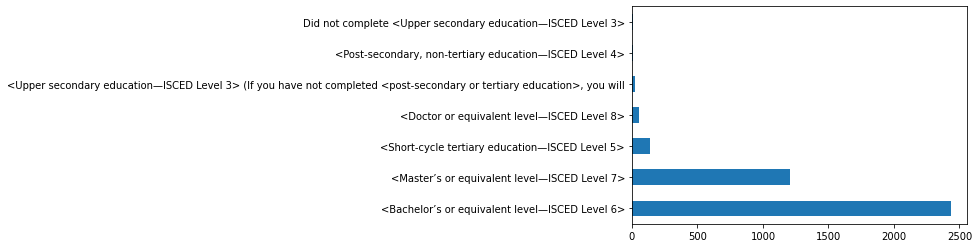

In [60]:
# graph frequency of educational achievement by the teachers in the dataframe
math_teach['BTBG04'].value_counts().plot(kind='barh');

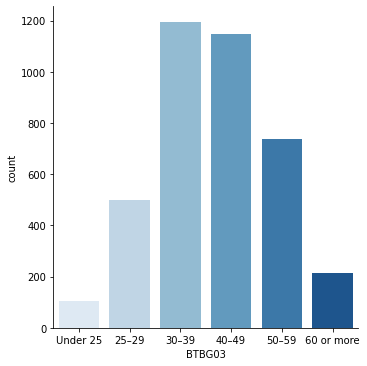

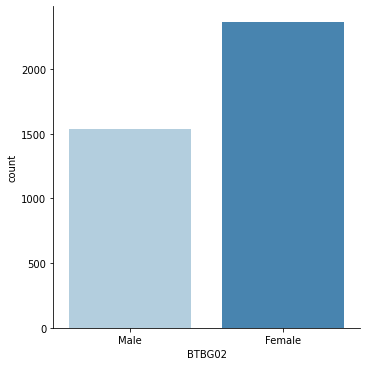

In [61]:
# create an ordinal categorical variable for the age of the teacher
cat_type = CategoricalDtype(categories=['Under 25', '25–29', '30–39', '40–49', '50–59', '60 or more'], ordered=True)
# impute the age as the ordinal type created above
math_teach['BTBG03'] = math_teach['BTBG03'].astype(cat_type)

# graph the age distribution of math teachers in the data
sns.catplot(x='BTBG03', kind='count', palette='Blues', data=math_teach);
# graph the gender distribution of math teachers in the data
sns.catplot(x='BTBG02', kind='count', palette='Blues', data=math_teach);

**Initial Observations about `math_teach` dataset:**
* Approximately Normal distribution of teacher ages
* Teach education is highly concentrated in the Bachelor's and Master's level
* Significantly more female teacher than males

**`math_teach` Data Preparation**
* drop unnecessary columns
* convert IDCNTRY, IDSCHOOL, IDTEALIN, IDTEACH, IDLINK to integers
* trim and convert BTBG04 to ordered categoricals (ISCED level)
* convert to integer and combine BTBG05* columns to study_stem_edu column
* drop BTBG06* columns because already summarized in BTBGEAS
* drop BTBG07* columns because already summarized in BTBGSOS
* drop BTBG08* columns because already summarized in BTBGTJS
* convert to integer scale BTBG09* columns for comparing teaching environments
* convert to integer scale BTBG12* columns for tracking effectiveness of teacher practices
* drop BTBG13* columns because already summarized in BTBGLSN
* convert to integer scale BTBM15* columns for tracking effectiveness of teacher practices
* convert to integer scale BTBM17* columns for tracking effectiveness of computer access
* drop BTBM18* columns because already summarized in BTDMNUM, BTDMALG, BTDMGEO, BTDMDAT
* convert to integer scale BTBM19* columns for tracking effectiveness of homework practices
* convert to integer scale BTBM20* columns for tracking effectiveness of assessment practices
* drop BTBM22* columns because alreadys summarized in BTBM23
* convert BTDGEAS, BTDGLSN, BTDGSOS, BTDGTJS columns to ordered categoricals
* rename all columns to be more descriptive
* merge with average student performance by teacher

In [62]:
# explore basic structure of science teacher data
sci_teach.head()

IDCNTRY  IDSCHOOL    IDTEALIN   IDTEACH  IDLINK            ITCOURSE  \
0    784.0    5001.0  50010203.0  500102.0     3.0  Integrated science   
1    784.0    5001.0  50010204.0  500102.0     4.0  Integrated science   
2    784.0    5002.0  50020303.0  500203.0     3.0  Integrated science   
3    784.0    5003.0  50030202.0  500302.0     2.0  Integrated science   
4    784.0    5004.0  50040202.0  500402.0     2.0  Integrated science   

   BTBG01  BTBG02 BTBG03                                          BTBG04  \
0    30.0    Male  50–59    <Master’s or equivalent level—ISCED Level 7>   
1    30.0    Male  50–59    <Master’s or equivalent level—ISCED Level 7>   
2     1.0  Female  25–29    <Master’s or equivalent level—ISCED Level 7>   
3     NaN     NaN    NaN                                             NaN   
4    10.0    Male  30–39  <Bachelor’s or equivalent level—ISCED Level 6>   

  BTBG05A BTBG05B BTBG05C BTBG05D BTBG05E BTBG05F BTBG05G BTBG05H BTBG05I  \
0      No     Yes     Yes     Yes     Yes      No     Yes      No      No   
1      No     Yes     Yes     Yes     Yes      No     Yes      No      No   
2     Yes      No      No      No      No      No      No      No      No   
3     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4      No      No      No      No      No      No     Yes     Yes     Yes   

  BTBG06A BTBG06B BTBG06C BTBG06D BTBG06E   BTBG06F BTBG06G   BTBG06H BTBG06I  \
0    High    High  Medium    High  Medium       Low    High       Low  Medium   
1    High    High  Medium    High  Medium       Low    High       Low  Medium   
2    High    High    High    High  Medium    Medium    High    Medium  Medium   
3     NaN     NaN     NaN     NaN     NaN       NaN     NaN       NaN     NaN   
4    High    High    High    High     Low  Very low     Low  Very low     Low   

  BTBG06J BTBG06K    BTBG06L      BTBG07A      BTBG07B         BTBG07C  \
0  Medium  Medium  Very high  Agree a lot  Agree a lot     Agree a lot   
1  Medium  Medium  Very high  Agree a lot  Agree a lot     Agree a lot   
2  Medium    High       High  Agree a lot  Agree a lot  Agree a little   
3     NaN     NaN        NaN          NaN          NaN             NaN   
4  Medium     Low       High  Agree a lot  Agree a lot  Agree a little   

             BTBG07D            BTBG07E            BTBG07F         BTBG07G  \
0     Agree a little     Agree a little        Agree a lot     Agree a lot   
1     Agree a little     Agree a little        Agree a lot     Agree a lot   
2  Disagree a little  Disagree a little  Disagree a little  Agree a little   
3                NaN                NaN                NaN             NaN   
4  Disagree a little  Disagree a little     Disagree a lot  Agree a little   

             BTBG07H     BTBG08A     BTBG08B     BTBG08C     BTBG08D  \
0        Agree a lot  Very often  Very often  Very often  Very often   
1        Agree a lot  Very often  Very often  Very often  Very often   
2     Agree a little  Very often  Very often  Very often  Very often   
3                NaN         NaN         NaN         NaN         NaN   
4  Disagree a little  Very often       Often       Often       Often   

      BTBG08E            BTBG09A         BTBG09B            BTBG09C  \
0  Very often     Agree a little     Agree a lot        Agree a lot   
1  Very often     Agree a little     Agree a lot        Agree a lot   
2  Very often  Disagree a little  Agree a little     Agree a little   
3         NaN                NaN             NaN                NaN   
4       Often        Agree a lot     Agree a lot  Disagree a little   

          BTBG09D            BTBG09E         BTBG09F            BTBG09G  \
0  Agree a little        Agree a lot     Agree a lot     Disagree a lot   
1  Agree a little        Agree a lot     Agree a lot     Disagree a lot   
2  Agree a little  Disagree a little  Disagree a lot  Disagree a little   
3             NaN                NaN             NaN                NaN   
4 

In [63]:
# create a list of columns to drop (null or single unique value)
sci_teach_drop_new = list(sci_teach.columns[sci_teach.isna().all()])+list(sci_teach.columns[sci_teach.nunique()==1])

In [64]:
# add redundant languge column to be dropped
sci_teach_drop_new = sci_teach_drop_new + ['LCID_T']

In [65]:
# display contextual information for some of the data
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBG' not in col],:].iloc[5:,:]

Label
Variable                                                   
ITCOURSE                         Subject Code in instrument
BTBS14                     SCI\TIME SPENT SCI INSTR MINUTES
BTBS15A                SCI\ASK STUDENTS\EXPLAIN NEW CONTENT
BTBS15B                  SCI\ASK STUDENTS\OBSERVE PHENOMENA
BTBS15C             SCI\ASK STUDENTS\DEMONSTRATE EXPERIMENT
BTBS15D                   SCI\ASK STUDENTS\PLAN EXPERIMENTS
BTBS15E                SCI\ASK STUDENTS\CONDUCT EXPERIMENTS
BTBS15F                       SCI\ASK STUDENTS\PRESENT DATA
BTBS15G                     SCI\ASK STUDENTS\INTERPRET DATA
BTBS15H            SCI\ASK STUDENTS\USE EVIDENCE TO SUPPORT
BTBS15I                     SCI\ASK STUDENTS\READ TEXTBOOKS
BTBS15J                     SCI\ASK STUDENTS\MEMORIZE FACTS
BTBS15K                       SCI\ASK STUDENTS\USE FORMULAS
BTBS15L                      SCI\ASK STUDENTS\DO FIELD WORK
BTBS15M               SCI\ASK STUDENTS\MIXED ABILITY GROUPS
BTBS15N                SCI\ASK STUDENTS\SAME ABILITY GROUPS
BTBS16A         SCI\COMPUTER TABLET AVAILABILITY DURING SCI
BTBS16BA     SCI\ACCESS TO COMPUTER\EACH STD HAS A COMPUTER
BTBS16BB         SCI\ACCESS TO COMPUTER\CLASS HAS COMPUTERS
BTBS16BC        SCI\ACCESS TO COMPUTER\SCHOOL HAS COMPUTERS
BTBS16CA        SCI\LEARNING ACTIVITIES ON COMP\WHOLE CLASS
BTBS16CB     SCI\LEARNING ACTIVITIES ON COMP\LOW PERFORMING
BTBS16CC    SCI\LEARNING ACTIVITIES ON COMP\HIGH PERFORMING
BTBS16CD      SCI\LEARNING ACTIVITIES ON COMP\SPECIAL NEEDS
BTBS17AA         SCI\TOPIC\BIO\DIFFERENCES TAXONOMIC GROUPS
BTBS17AB                         SCI\TOPIC\BIO\MAJOR ORGANS
BTBS17AC             SCI\TOPIC\BIO\CELLS AND THEIR FUNCTION
BTBS17AD                         SCI\TOPIC\BIO\REPRODUCTION
BTBS17AE                    SCI\TOPIC\BIO\ROLE OF VARIATION
BTBS17AF        SCI\TOPIC\BIO\INTERDEPENDENCE OF POPULATION
BTBS17AG                         SCI\TOPIC\BIO\HUMAN HEALTH
BTBS17BA               SCI\TOPIC\CHEM\PARTICULATE STRUCTURE
BTBS17BB                      SCI\TOPIC\CHEM\PERIODIC TABLE
BTBS17BC            SCI\TOPIC\CHEM\PHY CHEM PROPERTY MATTER
BTBS17BD              SCI\TOPIC\CHEM\MIXTURES AND SOLUTIONS
BTBS17BE                     SCI\TOPIC\CHEM\ACIDS AND BASES
BTBS17BF                  SCI\TOPIC\CHEM\CHEMICAL REACTIONS
BTBS17BG                   SCI\TOPIC\CHEM\MATTER AND ENERGY
BTBS17BH                   SCI\TOPIC\CHEM\ROLE OF ELECTRONS
BTBS17CA                      SCI\TOPIC\PHY\PHYSICAL STATES
BTBS17CB                SCI\TOPIC\PHY\ENERGY TRANSFORMATION
BTBS17CC            SCI\TOPIC\PHY\BASIC PROPERTIES OF LIGHT
BTBS17CD            SCI\TOPIC\PHY\BASIC PROPERTIES OF SOUND
BTBS17CE                    SCI\TOPIC\PHY\ELECTRIC CIRCUITS
BTBS17CF                   SCI\TOPIC\PHY\PROPERTIES MAGNETS
BTBS17CG                    SCI\TOPIC\PHY\MOTION AND FORCES
BTBS17DA                   SCI\TOPIC\EARTH\EARTHS STRUCTURE
BTBS17DB                   SCI\TOPIC\EARTH\EARTHS PROCESSES
BTBS17DC                   SCI\TOPIC\EARTH\EARTHS RESOURCES
BTBS17DD              SCI\TOPIC\EARTH\EARTH IN SOLAR SYSTEM
BTBS18A                 SCI\HOW OFTEN SCI HOMEWORK ASSIGNED
BTBS18B                          SCI\TIME SPENT ON HOMEWORK
BTBS18CA                   SCI\HOMEWORK\CORRECT ASSIGNMENTS
BTBS18CB                  SCI\HOMEWORK\CORRECT OWN HOMEWORK
BTBS18CC                      SCI\HOMEWORK\DISCUSS HOMEWORK
BTBS18CD                  SCI\HOMEWORK\MONITOR COMPLETENESS
BTBS18CE                        SCI\HOMEWORK\USE FOR GRADES
BTBS19A        SCI\IMPORTANCE STRATEGIES\OBSERVING STUDENTS
BTBS19B           SCI\IMPORTANCE STRATEGIES\ASKING STUDENTS
BTBS19C         SCI\IMPORTANCE STRATEGIES\SHORT ASSESEMENTS
BTBS19D              SCI\IMPORTANCE STRATEGIES\LONGER TESTS
BTBS19E        SCI\IMPORTANCE STRATEGIES\LONG-TERM PROJECTS
BTBS20                     SCI\TESTS ON COMPUTER OR TABLETS
BTBS21AA          SCI\PROF DEVELOPMENT PAST\SCIENCE CONTENT
BTBS21BA        SCI\PROF DEVELOPMENT FUTURE\SCIENCE CONTENT
BTBS21AB         SCI\PROF DEVELOPM

In [66]:
# display descriptive statistics for quantitative variables in the dataset
sci_teach.describe()

IDCNTRY     IDSCHOOL      IDTEALIN        IDTEACH       IDLINK  \
count  5187.000000  5187.000000  5.187000e+03    5187.000000  5187.000000   
mean    539.698091  5180.210719  5.180245e+07  518024.500482     3.790245   
std     286.892739   150.054127  1.500531e+06   15005.306783     3.726056   
min      36.000000  5001.000000  5.001020e+07  500102.000000     1.000000   
25%     380.000000  5070.000000  5.070030e+07  507003.000000     2.000000   
50%     620.000000  5139.000000  5.139040e+07  513904.000000     3.000000   
75%     784.000000  5242.000000  5.242025e+07  524202.500000     4.000000   
max     926.000000  5631.000000  5.631030e+07  563103.000000    53.000000   

            BTBG01       BTBG10       BTBG11       BTBS14      BTBGEAS  \
count  4642.000000  4457.000000  4399.000000  4270.000000  4652.000000   
mean     14.053425    28.175679     5.643101   185.408431    10.280453   
std       9.799243    11.897881    10.768996    77.949260     2.350696   
min       0.000000     1.000000     0.000000     1.000000     0.873410   
25%       6.000000    22.000000     0.000000   120.000000     8.546510   
50%      12.000000    27.000000     1.000000   180.000000    10.051020   
75%      20.000000    31.000000     6.000000   240.000000    11.550050   
max      48.000000   117.000000   100.000000   700.000000    17.780680   

           BTBGLSN      BTBGSOS      BTBGTJS      BTBSESI      BTDSBIO  \
count  4525.000000  4621.000000  4621.000000  4551.000000  3834.000000   
mean      9.867065    10.332157     9.989117     9.958807    76.119682   
std       2.014754     2.311994     1.840504     2.133545    22.835792   
min       3.623690     4.426320     5.281180     6.513090     0.000000   
25%       8.632380     8.783370     8.482860     8.817760    57.142860   
50%       9.619100    10.072630    10.258740     9.836960    85.714290   
75%      11.288280    11.789980    11.745590    11.318620   100.000000   
max      15.295110    13.870350    11.745590    16.032560   100.000000   

           BTDSCHE      BTDSPHY      BTDSEAR  VERSION  
count  3833.000000  3824.000000  3597.000000   5187.0  
mean     77.670574    69.769252    73.876378      4.0  
std      22.429011    27.064199    34.044033      0.0  
min       0.000000     0.000000     0.000000      4.0  
25%      62.500000    42.857140    50.000000      4.0  
50%      75.000000    71.428570   100.000000      4.0  
75%     100.000000   100.000000   100.000000      4.0  
max     100.000000   100.000000   100.000000      4.0

In [67]:
# display datatypes
sci_teach.dtypes

IDCNTRY     float64
IDSCHOOL    float64
IDTEALIN    float64
IDTEACH     float64
IDLINK      float64
             ...   
BTDSBIO     float64
BTDSCHE     float64
BTDSPHY     float64
BTDSEAR     float64
VERSION     float64
Length: 168, dtype: object

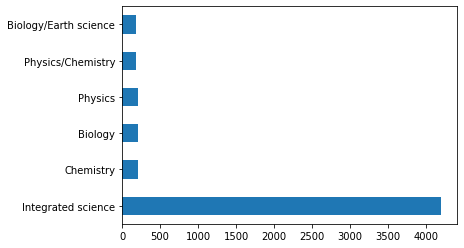

In [68]:
# graph the frequency of each science course taught
sci_teach['ITCOURSE'].value_counts().plot(kind='barh');

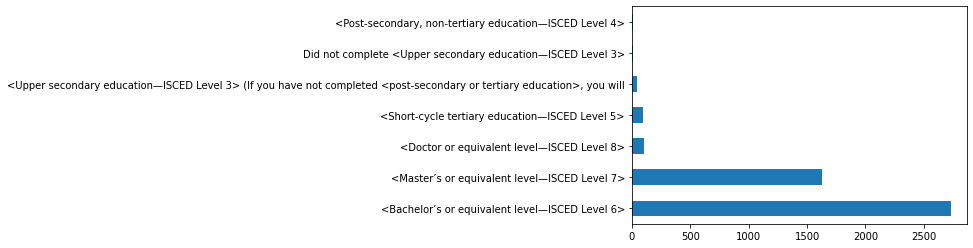

In [69]:
# visualize the frequency of educational achievement for science teachers
sci_teach['BTBG04'].value_counts().plot(kind='barh');

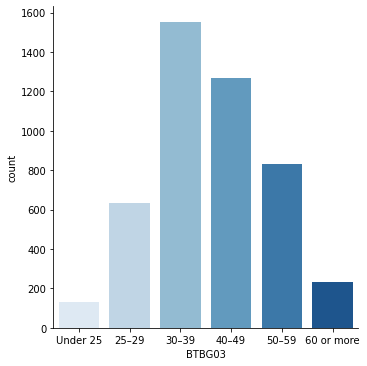

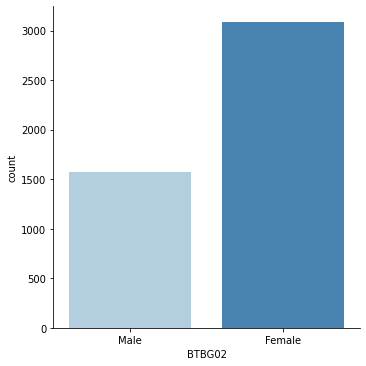

In [70]:
# create an ordinal categorical varialge for age groups
cat_type = CategoricalDtype(categories=['Under 25', '25–29', '30–39', '40–49', '50–59', '60 or more'], ordered=True)
# apply ordinal categorical to age data
sci_teach['BTBG03'] = sci_teach['BTBG03'].astype(cat_type)

# graph the age distribution for science teachers
sns.catplot(x='BTBG03', kind='count', palette='Blues', data=sci_teach);
# graph the gender distribution for science teachers
sns.catplot(x='BTBG02', kind='count', palette='Blues', data=sci_teach);

**Initial Observations about `sci_teach` dataset:**
* Approximately Normal distribution of teacher ages (slightly older than math teachers)
* Teach education is highly concentrated in the Bachelor's and Master's level (slightly more educated that math teachers)
* Significantly more female teacher than males (more significant difference than math teachers)
* Most schools offer Integrated Science as compared to specific disciplines

**`sci_teach` Data Preparation**
* drop unnecessary columns
* convert IDCNTRY, IDSCHOOL, IDTEALIN, IDTEACH, IDLINK to integers
* trim and convert BTBG04 to ordered categoricals (ISCED level)
* convert to integer and combine BTBG05* columns to study_stem_edu column
* drop BTBG06* columns because already summarized in BTBGEAS
* drop BTBG07* columns because already summarized in BTBGSOS
* drop BTBG08* columns because already summarized in BTBGTJS
* convert to integer scale BTBG09* columns for comparing teaching environments
* convert to integer scale BTBG12* columns for tracking effectiveness of teacher practices
* drop BTBG13* columns because already summarized in BTBGLSN
* convert to integer scale BTBS15* columns for tracking effectiveness of teacher practices
* convert to integer scale BTBS16* columns for tracking effectiveness of computer access
* drop BTBS17* columns because already summarized in BTDSBIO, BTDSCHE, BTDSPHY, BTDSEAR
* convert to integer scale BTBS18* columns for tracking effectiveness of homework practices
* convert to integer scale BTBS19* columns for tracking effectiveness of assessment practices
* drop BTBS21* columns because alreadys summarized in BTBM22
* convert BTDGEAS, BTDGLSN, BTDGSOS, BTDGTJS, BTDSESI columns to ordered categoricals
* rename all columns to be more descriptive
* merge with average student performance by teacher

[Return to Top](#top)

<div id='data_preparation'></div>

# Data Preparation

Jump to:
1. [`stud_ach Preparation`](#prep1)
1. [`school Preparation`](#prep2)
1. [`student Preparation`](#prep3)
1. [`stud_teach Preparation`](#prep4)
1. [`math_teach Preparation`](#prep5)
1. [`sci_teach Preparation`](#prep6)

[Return to Top of Data Preparation](#data_preparation)

<div id='prep1'></div>

**`stud_ach` Data Preparation**
* ~~drop unnecessary (or null) columns~~
* ~~convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD to integers~~
* ~~trim and convert IDBOOK, IDGRADE to integer~~
* ~~rename all columns to be more descriptive~~

#### Define
* drop unnecessary (or null) columns

#### Code

In [71]:
# drop the null and single-value columns
stud_ach.drop(columns=stud_ach_drop_new, inplace=True)
# drop the redundant language column
stud_ach.drop(columns=['LCID_SA'], inplace=True)

#### Test

In [72]:
# check for no overlap between the dropped columns and the remaining columns
set(stud_ach_drop_new) & set(stud_ach.columns)

set()

#### Define
* convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD to integers

#### Code

In [73]:
# convert each of the columns into integer type
stud_ach['IDCNTRY'] = stud_ach['IDCNTRY'].astype(int)
stud_ach['IDSCHOOL'] = stud_ach['IDSCHOOL'].astype(int)
stud_ach['IDCLASS'] = stud_ach['IDCLASS'].astype(int)
stud_ach['IDSTUD'] = stud_ach['IDSTUD'].astype(int)

#### Test

In [74]:
# confirm change in datatype
stud_ach.dtypes[:10]

IDCNTRY          int32
IDBOOK          object
IDSCHOOL         int32
IDCLASS          int32
IDSTUD           int32
IDGRADE         object
ITLANG_SA       object
ITSEX           object
BSDAGE         float64
MP52024_val    float64
dtype: object

#### Define
* trim and convert IDBOOK, IDGRADE to integer

#### Code

In [75]:
# take only the digits from the strings and convert to integer
stud_ach['IDBOOK'] = stud_ach['IDBOOK'].apply(lambda x: x[-2:]).astype(int)
stud_ach['IDGRADE'] = stud_ach['IDGRADE'].apply(lambda x: x[-1]).astype(int)

#### Test

In [76]:
# confirm change in datatype 
stud_ach.dtypes[:10]

IDCNTRY          int32
IDBOOK           int32
IDSCHOOL         int32
IDCLASS          int32
IDSTUD           int32
IDGRADE          int32
ITLANG_SA       object
ITSEX           object
BSDAGE         float64
MP52024_val    float64
dtype: object

#### Define
* rename all columns to be more descriptive

#### Code

In [77]:
# create dictionary for renaming the columns
stud_ach_col_dict = {'ITLANG_SA':'language','IDGRADE':'grade','ITSEX':'sex','BSDAGE':'age','IDBOOK':'test_book'}
# rename the columns
stud_ach.rename(columns=stud_ach_col_dict, inplace=True)

#### Test

In [78]:
# check all columns that are not assessment item scores, category averages or standard deviations
[col for col in stud_ach.columns if '_avg' not in col and '_val' not in col and '_sd' not in col]

['IDCNTRY',
 'test_book',
 'IDSCHOOL',
 'IDCLASS',
 'IDSTUD',
 'grade',
 'language',
 'sex',
 'age']

[Return to Top of Data Preparation](#data_preparation)

<div id='prep2'></div>

**`school` Data Preparation**
* ~~drop unnecessary columns~~
* ~~convert IDCNTRY, IDSCHOOL to integers~~
* ~~trim and convert IDGRADE to integer~~
* ~~convert BCDGDAS, BCDGEAS, BCDGMRS, BCDGSRS, BCDGSBC to ordered categoricals~~
* ~~rename all columns to be more descriptive~~
* ~~merge with student performance by school~~

#### Define
* Drop repetitive columns from the dataset

#### Code

In [79]:
# drop the null or single-value columns
school.drop(columns=school_drop_new,inplace=True)
# drop the redundant language column
school.drop(columns=['LCID_C'], inplace=True)

#### Test

In [80]:
# verify dropped columns
set(school_drop_new) & set(school.columns)

set()

#### Define
* Convert IDCNTRY, IDSCHOOL to integers

#### Code

In [81]:
school['IDCNTRY'] = school['IDCNTRY'].astype(int)
school['IDSCHOOL'] = school['IDSCHOOL'].astype(int)

#### Test

In [82]:
# confirm change in datatype
school.dtypes[:5]

IDCNTRY       int32
IDSCHOOL      int32
IDGRADE      object
ITLANG_C     object
BCBGDAS     float64
dtype: object

#### Define
* Trim and convert IDGRADE to integer (8 or 9)

#### Code

In [83]:
# grab the digit from the string and convert it to integer
school['IDGRADE'] = school['IDGRADE'].apply(lambda x: x[-1]).astype(int)

#### Test

In [84]:
# verify the unique values in IDGRADE
school['IDGRADE'].unique()

array([8, 9])

#### Define
* Convert BCDGDAS, BCDGEAS, BCDGMRS, BCDGSRS, BCDGSBC to ordered categoricals

#### Code

In [85]:
# create a list of all indices measuring school traits
school_indices = ['BCDGDAS', 'BCDGEAS', 'BCDGMRS', 'BCDGSRS', 'BCDGSBC']
# go through each of the indices
for col in school_indices:
    # print the contextual information for the index
    print(school_codes.loc[col,:])
    # print the unique values for the index
    print(school[col].unique())

Label    School Discipline Problems-Prncpl/IDX
Name: BCDGDAS, dtype: object
['Minor Problems' 'Moderate to Severe Problems' 'Hardly Any Problems' nan]
Label    School Emph on Acad Success-Prncpl/IDX
Name: BCDGEAS, dtype: object
['Medium Emphasis' 'High Emphasis' 'Very High Emphasis' nan]
Label    Instr Aff by Mat Res Shortage-Prncpl/IDX
Name: BCDGMRS, dtype: object
['Not Affected' 'Affected' 'Affected A Lot' nan]
Label    Instr Aff by Sci Res Shortage-Prncpl/IDX
Name: BCDGSRS, dtype: object
['Not Affected' 'Affected' 'Affected A Lot' nan]
Label    School Composition by Socioeconomic Background
Name: BCDGSBC, dtype: object
['Neither More Affluent nor More Disadvantaged' 'More Affluent'
 'More Disadvantaged' nan]


In [86]:
# create an ordinal categorical variable for discipline problems
disc_prob_type = CategoricalDtype(categories=['Hardly Any Problems','Minor Problems','Moderate to Severe Problems'], ordered=True)
# create new column with ordinal type
school['disc_prob'] = school['BCDGDAS'].astype(disc_prob_type)
# create an ordinal categorical variable for academic emphasis
acad_emph_type = CategoricalDtype(categories=['Medium Emphasis', 'High Emphasis', 'Very High Emphasis'], ordered=True)
# create new column with ordinal type
school['acad_emph'] = school['BCDGEAS'].astype(acad_emph_type)
# create an ordinal categorical variable for affect of shortages
shortage_affect_type = CategoricalDtype(categories=['Not Affected', 'Affected', 'Affected A Lot'], ordered=True)
# create new columns with ordinal type
school['math_shortage'] = school['BCDGMRS'].astype(shortage_affect_type)
school['sci_shortage'] = school['BCDGSRS'].astype(shortage_affect_type)
# create an ordinal categorical variable for socioeconomic background
school_socio_type = CategoricalDtype(categories=['More Disadvantaged', 'Neither More Affluent nor More Disadvantaged', 'More Affluent'], ordered=True)
# create new column with ordinal type
school['socio_background'] = school['BCDGSBC'].astype(school_socio_type)
# drop the previous columns, leaving the ordinal columns
school.drop(columns=school_indices, inplace=True)

#### Test

In [87]:
# confirm datatypes
school.dtypes

IDCNTRY                int32
IDSCHOOL               int32
IDGRADE                int32
ITLANG_C              object
BCBGDAS              float64
BCBGEAS              float64
BCBGMRS              float64
BCBGSRS              float64
BCDGTIHY             float64
disc_prob           category
acad_emph           category
math_shortage       category
sci_shortage        category
socio_background    category
dtype: object

#### Define
* rename all columns to be more descriptive

#### Code

In [88]:
# create a dictionary for renaming columns
school_col_dict = {'BCBGDAS':'disc_prob_score','BCBGEAS':'acad_emph_score','BCBGMRS':'math_shortage_score','BCBGSRS':'sci_shortage_score','BCDGTIHY':'acad_hours','ITLANG_C':'language','IDGRADE':'grade'}
# rename columns
school.rename(columns=school_col_dict,inplace=True)

#### Test

In [89]:
# confirm rename of columns
school.columns

Index(['IDCNTRY', 'IDSCHOOL', 'grade', 'language', 'disc_prob_score',
       'acad_emph_score', 'math_shortage_score', 'sci_shortage_score',
       'acad_hours', 'disc_prob', 'acad_emph', 'math_shortage', 'sci_shortage',
       'socio_background'],
      dtype='object')

#### Define
* merge with student performance by school

#### Code

In [90]:
# confirm student achievement data grouped by IDCNTRY and IDSCHOOL
stud_ach.groupby(['IDCNTRY','IDSCHOOL']).mean().loc[:,[col for col in stud_ach.columns if '_avg' in col]]

mmat_avg    ssci_avg    malg_avg    mapp_avg    mdat_avg  \
IDCNTRY IDSCHOOL                                                               
36      5001      512.160420  528.909690  498.302685  521.510511  531.893457   
        5002      500.057398  525.348892  480.069888  501.129069  521.833812   
        5003      525.973490  533.678966  511.335672  529.865375  544.964311   
        5004      568.834716  582.543276  557.924186  572.206090  585.849087   
        5005      458.656151  478.569777  444.118141  460.885134  471.541118   
...                      ...         ...         ...         ...         ...   
926     5183      466.957372  476.967664  452.769782  468.937011  473.377250   
        5185      365.435784  371.044598  338.786517  370.456768  348.088408   
        5186      616.514895  618.214405  619.588005  625.891440  633.987500   
        5188      496.836016  515.692344  486.162437  497.704356  505.769562   
        5189      526.207270  536.803338  513.386954  520.617335  528.815793   

                    mgeo_avg    mkno_avg    mnum_avg    mrea_avg    sapp_avg  \
IDCNTRY IDSCHOOL                                                               
36      5001      510.723844  506.440412  516.348085  513.322954  536.406658   
        5002      495.260373  493.117152  505.968088  495.033254  533.047731   
        5003      519.626145  517.451107  531.761602  521.959500  538.120939   
        5004      566.528514  552.770096  580.028650  567.582195  587.872312   
        5005      452.514983  450.811446  456.019090  451.648922  481.027424   
...                      ...         ...         ...         ...         ...   
926     5183      468.292657  466.484542  473.139358  459.090532  475.552460   
        5185      350.552840  381.317040  375.374481  370.394465  357.076594   
        5186      617.478470  609.913583  613.485984  618.833868  620.193140   
        5188      496.101479  492.946888  501.964702  495.030819  519.030543   
        5189      518.125006  513.771460  525.154029  523.165579  537.108744   

                    sbio_avg    sche_avg    sear_avg    skno_avg    sphy_avg  \
IDCNTRY IDSCHOOL                                                               
36      5001      530.658886  514.227199  535.867503  507.441620  528.110842   
        5002      532.758198  512.284051  541.315108  514.368975  529.544135   
        5003      532.310956  526.377450  542.737756  525.064673  537.782550   
        5004      587.439474  577.372379  586.673154  575.790927  580.311813   
        5005      472.061751  452.380780  477.753128  461.967294  475.214976   
...                      ...         ...         ...         ...         ...   
926     5183      478.699837  471.569822  474.080005  475.910826  478.340698   
        5185      370.812283  338.711852  355.732031  359.443878  357.576048   
        5186      616.888514  624.245875  599.493436  621.085714  618.206429   
        5188      520.562055  506.914465  525.165300  526.623127  516.977343   
        5189      530.329469  537.346412  544.947730  537.834620  542.986514   

                    srea_avg  
IDCNTRY IDSCHOOL              
36      5001      532.552107  
        5002      534.525980  
        5003      537.392486  
        5004      590.738231  
        5005      495.105472  
...                      ...  
926     5183      474.215065  
        5185      356.191691  
        5186      610.239035  
        5188      520.289095  
        5189      539.928691  

[2816 rows x 16 columns]

In [91]:
# confirm school data indexed by IDCNTRY and IDSCHOOL
school.set_index(['IDCNTRY','IDSCHOOL'])

grade   language  disc_prob_score  acad_emph_score  \
IDCNTRY IDSCHOOL                                                       
784     5001          8    English          9.79606          7.03177   
        5002          8    English          7.41582          9.85898   
        5003          8    English         10.43939         10.46161   
        5004          8    English         10.10482          9.56054   
        5005          8     Arabic         10.80136         11.65536   
...                 ...        ...              ...              ...   
710     5516          9    English         14.02858         16.36222   
        5517          9  Afrikaans          8.41206          8.67341   
        5518          9  Afrikaans          8.08398          7.39368   
        5519          9    English          7.93621         13.95351   
        5520          9  Afrikaans         14.02858         16.36222   

                  math_shortage_score  sci_shortage_score  acad_hours  \
IDCNTRY IDSCHOOL                                                        
784     5001                 14.25596            14.57241  1350.00000   
        5002                 12.92960            13.17876  1025.66667   
        5003                  8.31802             8.31328   957.66667   
        5004                 12.92960            14.57241  1680.00000   
        5005                  7.87145             8.17049  1110.00000   
...                               ...                 ...         ...   
710     5516                 14.25596            14.57241  1013.25000   
        5517                 10.21426            10.17656  1100.00000   
        5518                  9.62794             9.57915  1061.33333   
        5519                  9.00816             9.46956  1160.83333   
        5520                 14.25596            14.57241  1200.00000   

                                    disc_prob           acad_emph  \
IDCNTRY IDSCHOOL                                                    
784     5001                   Minor Problems     Medium Emphasis   
        5002      Moderate to Severe Problems       High Emphasis   
        5003                   Minor Problems       High Emphasis   
        5004                   Minor Problems     Medium Emphasis   
        5005              Hardly Any Problems       High Emphasis   
...                                       ...                 ...   
710     5516              Hardly Any Problems  Very High Emphasis   
        5517                   Minor Problems     Medium Emphasis   
        5518                   Minor Problems     Medium Emphasis   
        5519      Moderate to Severe Problems  Very High Emphasis   
        5520              Hardly Any Problems  Very High Emphasis   

                 math_shortage  sci_shortage  \
IDCNTRY IDSCHOOL                               
784     5001      Not Affected  Not Affected   
        5002      Not Affected  Not Affected   
        5003          Affected      Affected   
        5004      Not Affected  Not Affected   
        5005          Affected      Affected   
...                        ...           ...   
710     5516      Not Affected  Not Affected   
        5517          Affected      Affected   
        5518          Affected      Affected   
        5519          Affected      Affected   
        5520      Not Affected  Not Affected   

                                              socio_background  
IDCNTRY IDSCHOOL                                                
784     5001      Neither More Affluent nor More Disadvantaged  
        5002                                     More Affluent  
        5003                                More Disadvantaged  
        5004                                     More Affluent  
        5005                                     More Affluent  
...                                                        ...  
710     5516                                     More Affluent  
        5517           

In [92]:
# combine the student achievement data to the school dataframe
school = school.set_index(['IDCNTRY','IDSCHOOL']).join(stud_ach.groupby(['IDCNTRY','IDSCHOOL']).mean().loc[:,[col for col in stud_ach.columns if '_avg' in col]], how='left').reset_index()

#### Test

In [93]:
# confirm that school dataframe now has assessment columns
school.columns

Index(['IDCNTRY', 'IDSCHOOL', 'grade', 'language', 'disc_prob_score',
       'acad_emph_score', 'math_shortage_score', 'sci_shortage_score',
       'acad_hours', 'disc_prob', 'acad_emph', 'math_shortage', 'sci_shortage',
       'socio_background', 'mmat_avg', 'ssci_avg', 'malg_avg', 'mapp_avg',
       'mdat_avg', 'mgeo_avg', 'mkno_avg', 'mnum_avg', 'mrea_avg', 'sapp_avg',
       'sbio_avg', 'sche_avg', 'sear_avg', 'skno_avg', 'sphy_avg', 'srea_avg'],
      dtype='object')

[Return to Top of Data Preparation](#data_preparation)

<div id='prep3'></div>

**`student` Data Preparation**
* ~~drop unnecessary columns~~
* ~~convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD to integers~~
* ~~trim and convert IDBOOK, IDGRADE to integers~~
* ~~convert to integer and combine BSBG05* columns to home_possession column~~
* ~~convert to string and combine BSBG09* columns to ordered categorical age_immigration column~~
* ~~convert to integer and combine BSBG12* columns to internet_access column~~
* ~~convert BSBG03, BSBG04, BSBG10, BSBG11*, BSDG* columns to ordered categoricals~~
* ~~trim and convert BSBG06A, BSBG06B, BSBG07 to ordered categoricals (ISCED level)~~
* ~~convert BSBG08* to boolean~~
* ~~rename all columns to be more descriptive~~
* ~~merge with student performance~~

#### Define
* drop unnecessary columns

#### Code

In [94]:
student_drop_new = student_drop_new + ['LCID_SQ','ITLANG_SA','LCID_SA']
student.drop(columns=student_drop_new, inplace=True)

#### Test

In [95]:
# confirm columns dropped
set(student_drop_new) & set(student.columns)

set()

#### Define
* convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD to integers
* trim and convert IDBOOK, IDGRADE to integers

#### Code

In [96]:
student[['IDCNTRY','IDSCHOOL','IDCLASS','IDSTUD']] = student[['IDCNTRY','IDSCHOOL','IDCLASS','IDSTUD']].astype(int)
# take the digits from IDBOOK and IDGRADE
student['IDBOOK'] = student['IDBOOK'].apply(lambda x: x[-2:]).astype(int)
student['IDGRADE'] = student['IDGRADE'].apply(lambda x: x[-1]).astype(int)

#### Test

In [97]:
# confirm change in datatypes
student[['IDCNTRY','IDSCHOOL','IDCLASS','IDSTUD','IDBOOK','IDGRADE']].dtypes

IDCNTRY     int32
IDSCHOOL    int32
IDCLASS     int32
IDSTUD      int32
IDBOOK      int32
IDGRADE     int32
dtype: object

#### Define
* convert to integer and combine BSBG05* columns to home_possession column
* convert to integer and combine BSBG12* columns to internet_access column

#### Code

In [98]:
# dictionary for creating the new combined columns
conv_col = {'BSBG05':'home_possession','BSBG12':'internet_access'}
# go through each set of columns
for base_col in conv_col.keys():
    # gather the list of all columns matching the prefix
    all_cols = [col for col in student.columns if base_col in col]
    # go through each matching column
    for i, single_col in enumerate(all_cols):
        # if it is is the first column
        if i == 0:
            # create the new column with 1 for Yes, 0 for No, or NaN for null
            student[conv_col[base_col]] = student[single_col].apply(lambda x: np.nan if x!=x else int(x=='Yes')).astype(float)
        # otherwise, add any subsequent values to the previous sum
        else:
            # add any subsequent values to the previous sum (1 for Yes, 0 for No, or NaN for null)
            student[conv_col[base_col]] = student[conv_col[base_col]] + student[single_col].apply(lambda x: np.nan if x!=x else int(x=='Yes')).astype(float)
    # drop all matching columns for the new combined columns
    student.drop(columns=all_cols, inplace=True)

#### Test

In [99]:
# confirm new columns
student.columns

Index(['IDCNTRY', 'IDBOOK', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'BSBG03',
       'BSBG04', 'BSBG06A', 'BSBG06B', 'BSBG07', 'BSBG08A', 'BSBG08B',
       'BSBG09A', 'BSBG09B', 'BSBG10', 'BSBG11A', 'BSBG11B', 'IDGRADE',
       'ITLANG_SQ', 'ITSEX', 'BSDAGE', 'BSBGHER', 'BSDGHER', 'BSBGSSB',
       'BSDGSSB', 'BSBGSB', 'BSDGSB', 'BSBGSLM', 'BSDGSLM', 'BSBGICM',
       'BSDGICM', 'BSBGDML', 'BSDGDML', 'BSBGSCM', 'BSDGSCM', 'BSBGSVM',
       'BSDGSVM', 'BSBGSLS', 'BSDGSLS', 'BSBGICS', 'BSDGICS', 'BSBGSCS',
       'BSDGSCS', 'BSBGSVS', 'BSDGSVS', 'BSBGSLB', 'BSDGSLB', 'BSBGICB',
       'BSDGICB', 'BSBGSCB', 'BSDGSCB', 'BSBGSLE', 'BSDGSLE', 'BSBGICE',
       'BSDGICE', 'BSBGSCE', 'BSDGSCE', 'BSBGSLC', 'BSDGSLC', 'BSBGICC',
       'BSDGICC', 'BSBGSCC', 'BSDGSCC', 'BSBGSLP', 'BSDGSLP', 'BSBGICP',
       'BSDGICP', 'BSBGSCP', 'BSDGSCP', 'BSBGSEC', 'BSDGSEC', 'BSDG05S',
       'BSDGEDUP', 'home_possession', 'internet_access'],
      dtype='object')

In [100]:
# confirm datatypes
student[['home_possession','internet_access']].dtypes

home_possession    float64
internet_access    float64
dtype: object

#### Define
* convert to string and combine BSBG09* columns to ordered categorical age_immigration column

#### Code

In [101]:
# print the different values for each BSBG09 column
for col in [col for col in student.columns if 'BSBG09' in col]:
    print(student[col].unique())

['Yes' 'No' nan]
[nan '5 to 10 years old' 'Younger than 5 years old'
 'Older than 10 years old']


In [102]:
def age_immigration_col(x):
    '''
    combines both immigration columns into a single values
    
    INPUT:
    x - (list with two values)   Yes/No for born in country
                                 Age range when immigrated in country
    
    OUTPUT:
    a value representing age range when immigrated ('Birth' for born in country)
    '''
    # if born in country, return 'Birth'
    if x[0] == 'Yes':
        return('Birth')
    # otherwise, return age range of immigration
    else:
        return(x[1])

In [103]:
# use the age_immigration_col function to combine the two immigration columns
student['age_immigration'] = student[['BSBG09A','BSBG09B']].apply(age_immigration_col, axis = 1)
# delete the previous immigration columns
student.drop(columns=['BSBG09A','BSBG09B'], inplace=True)

In [104]:
# create ordinal categorical type for immigration age
immigration_type = CategoricalDtype(categories=['Birth','Younger than 5 years old','5 to 10 years old', 'Older than 10 years old'], ordered=True)
student['age_immigration'] = student['age_immigration'].astype(immigration_type)

#### Test

In [105]:
# confirm change in datatype
student[[col for col in student.columns if 'BSBG09' in col or 'immigration' in col]].dtypes

age_immigration    category
dtype: object

#### Define
* convert BSBG03, BSBG04, BSBG10, BSBG11, BSDG columns to ordered categoricals

#### Code

In [106]:
# print the context label and unique values for each column matching the column prefixes
new_cat_cols = ['BSBG03', 'BSBG04', 'BSBG10', 'BSBG11', 'BSDG']
for col_root in new_cat_cols:
    for col in student.columns:
        if col_root in col:
            print(student[col].unique())
            print(student_codes.loc[col,:])

['Almost always' 'Always' nan 'Sometimes' 'Never']
Label    GEN\OFTEN SPEAK <LANG OF TEST> AT HOME
Name: BSBG03, dtype: object
['Enough to fill one shelf (11–25 books)' 'None or very few (0–10 books)'
 nan 'Enough to fill one bookcase (26–100 books)'
 'Enough to fill two bookcases (101–200 books)'
 'Enough to fill three or more bookcases (more than 200)']
Label    GEN\AMOUNT OF BOOKS IN YOUR HOME
Name: BSBG04, dtype: object
['Never or almost never' 'Once a week' 'Once every two month'
 'Once a month' 'Once every two weeks' nan]
Label    GEN\ABOUT HOW OFTEN ABSENT FROM SCHOOL
Name: BSBG10, dtype: object
['Sometimes' 'Every day' 'Almost every day' 'Never' nan]
Label    GEN\HOW OFTEN\TIRED
Name: BSBG11A, dtype: object
['Sometimes' nan 'Every day' 'Never' 'Almost every day']
Label    GEN\HOW OFTEN\HUNGRY
Name: BSBG11B, dtype: object
['Some Resources' 'Few Resources' 'Many Resources' nan]
Label    Home Educational Resources/IDX
Name: BSDGHER, dtype: object
['High Sense of School Belonging' 

In [107]:
# create a blank dictionary to store all of the changes to the columns summarized above
info = {}
# each entry in the dictionary contains the column prefix as the key, then a new name for the column, then the ordinal values of the categories
info['BSBG03'] = {'new_name':'acad_lang_home','ordered_cols':['Never','Sometimes','Almost always','Always']}
info['BSBG04'] = {'new_name':'books','ordered_cols':['None or very few (0–10 books)','Enough to fill one shelf (11–25 books)',
                                                     'Enough to fill one bookcase (26–100 books)','Enough to fill two bookcases (101–200 books)',
                                                     'Enough to fill three or more bookcases (more than 200)']}
info['BSBG10'] = {'new_name':'absent_freq','ordered_cols':['Never or almost never','Once every two month','Once a month','Once every two weeks','Once a week']}
info['BSBG11A'] = {'new_name':'tired_freq','ordered_cols':['Never','Sometimes','Almost every day','Every day']}
info['BSBG11B'] = {'new_name':'hungry_freq','ordered_cols':['Never','Sometimes','Almost every day','Every day']}
info['BSDGHER'] = {'new_name':'home_res','ordered_cols':['Few Resources','Some Resources','Many Resources']}
info['BSDGSSB'] = {'new_name':'belonging','ordered_cols':['Little Sense of School Belonging','Some Sense of School Belonging','High Sense of School Belonging']}
info['BSDGSB'] = {'new_name':'bullying','ordered_cols':['Never or Almost Never','About Monthly','About Weekly']}
info['BSDGSLM'] = {'new_name':'like_math','ordered_cols':['Do Not Like Learning Mathematics','Somewhat Like Learning Mathematics','Very Much Like Learning Mathematics']}
info['BSDGICM'] = {'new_name':'clear_math','ordered_cols':['Low Clarity of Instruction','Moderate Clarity of Instruction','High Clarity of Instruction']}
info['BSDGDML'] = {'new_name':'disorder_math','ordered_cols':['Few or No Lessons','Some Lessons','Most Lessons']}
info['BSDGSCM'] = {'new_name':'confident_math','ordered_cols':['Not Confident in Mathematics','Somewhat Confident in Mathematics','Very Confident in Mathematics']}
info['BSDGSVM'] = {'new_name':'value_math','ordered_cols':['Do Not Value Mathematics','Somewhat Value Mathematics','Strongly Value Mathematics']}
info['BSDGSLS'] = {'new_name':'like_science','ordered_cols':['Do Not Like Learning Science','Somewhat Like Learning Science','Very Much Like Learning Science']}
info['BSDGICS'] = {'new_name':'clear_science','ordered_cols':['Low Clarity of Instruction','Moderate Clarity of Instruction','High Clarity of Instruction']}
info['BSDGSCS'] = {'new_name':'confident_science','ordered_cols':['Not Confident in Science','Somewhat Confident in Science','Very Confident in Science']}
info['BSDGSVS'] = {'new_name':'value_science','ordered_cols':['Do Not Value Science','Somewhat Value Science','Strongly Value Science']}
info['BSDGSLB'] = {'new_name':'like_bio','ordered_cols':['Do Not Like Learning Biology','Somewhat Like Learning Biology','Very Much Like Learning Biology']}
info['BSDGICB'] = {'new_name':'clear_bio','ordered_cols':['Low Clarity of Instruction','Moderate Clarity of Instruction','High Clarity of Instruction']}
info['BSDGSCB'] = {'new_name':'confident_bio','ordered_cols':['Not Confident in Biology','Somewhat Confident in Biology','Very Confident in Biology']}
info['BSDGSLE'] = {'new_name':'like_earth','ordered_cols':['Do Not Like Learning Earth Science','Somewhat Like Learning Earth Science','Very Much Like Learning Earth Science']}
info['BSDGICE'] = {'new_name':'clear_earth','ordered_cols':['Low Clarity of Instruction','Moderate Clarity of Instruction','High Clarity of Instruction']}
info['BSDGSCE'] = {'new_name':'confident_earth','ordered_cols':['Not Confident in Earth Science','Somewhat Confident in Earth Science','Very Confident in Earth Science']}
info['BSDGSLC'] = {'new_name':'like_chem','ordered_cols':['Do Not Like Learning Chemistry','Somewhat Like Learning Chemistry','Very Much Like Learning Chemistry']}
info['BSDGICC'] = {'new_name':'clear_chem','ordered_cols':['Low Clarity of Instruction','Moderate Clarity of Instruction','High Clarity of Instruction']}
info['BSDGSCC'] = {'new_name':'confident_chem','ordered_cols':['Not Confident in Chemistry','Somewhat Confident in Chemistry','Very Confident in Chemistry']}
info['BSDGSLP'] = {'new_name':'like_phys','ordered_cols':['Do Not Like Learning Physics','Somewhat Like Learning Physics','Very Much Like Learning Physics']}
info['BSDGICP'] = {'new_name':'clear_phys','ordered_cols':['Low Clarity of Instruction','Moderate Clarity of Instruction','High Clarity of Instruction']}
info['BSDGSCP'] = {'new_name':'confident_phys','ordered_cols':['Not Confident in Physics','Somewhat Confident in Physics','Very Confident in Physics']}
info['BSDGSEC'] = {'new_name':'confident_computer','ordered_cols':['Low Self-Efficacy','Medium Self-Efficacy','High Self-Efficacy']}
info['BSDG05S'] = {'new_name':'study_support','ordered_cols':['Neither Own Room nor Internet Connection','Either Own Room or Internet Connection','Both Own Room and Internet Connection']}
info['BSDGEDUP'] = {'new_name':'','ordered_cols':['Some Primary, Lower Secondary or No School',
                                                 'Lower Secondary','Upper Secondary','Post-secondary but not University',
                                                 'University or Higher']}

In [108]:
# go through each item in the dictionary above
for item in info.keys():
    # create the ordinal categorical type with the respective values
    cat_type = CategoricalDtype(categories=info[item]['ordered_cols'], ordered=True)
    # apply the new type to the column
    student[item] = student[item].astype(cat_type)
    # rename the column to new name
    student.rename(columns={item:info[item]['new_name']},inplace=True)

#### Test

In [109]:
# investigate the datatypes of the new columns (by sampling 10 lowercase columns)
student.loc[:,[col for col in student.columns if col.islower()]].dtypes.sample(10)

like_bio             category
confident_science    category
like_earth           category
study_support        category
confident_bio        category
clear_chem           category
acad_lang_home       category
internet_access       float64
clear_earth          category
like_chem            category
dtype: object

In [110]:
# verify the ordinal categorical of a randomly selected column
student[random.choice([col for col in student.columns if col.islower()])].unique()

[NaN, 'High Clarity of Instruction', 'Moderate Clarity of Instruction', 'Low Clarity of Instruction']
Categories (3, object): ['Low Clarity of Instruction' < 'Moderate Clarity of Instruction' < 'High Clarity of Instruction']

#### Define
* trim and convert BSBG06A, BSBG06B, BSBG07 to ordered categoricals (ISCED level)

#### Code

In [111]:
# check the context info for the column
student_codes.loc['BSBG06A']

Label    GEN\HIGHEST LVL OF EDU OF <PARENT/GUARDIAN A>
Name: BSBG06A, dtype: object

In [112]:
def edu_level(val):
    '''
    translates educational level into standard ISCED Level output
    
    INPUT:
    val - (str) a string containing educational information, description, and ISCED Level
    
    OUTPUT:
    a string representing the respective ISCED Level of education
    '''
    try:
        # if the string contains a digit
        level = re.search('[0-9]',val).group(0)
        # return the respective ISCED Level
        return 'ISCED Level '+level
    except:
        # otherwise, return NaN
        return np.NaN

In [113]:
# create three new educational columns by applying edu_level function
student['parent_edu_1'] = student['BSBG06A'].apply(edu_level)
student['parent_edu_2'] = student['BSBG06B'].apply(edu_level)
student['desired_edu'] = student['BSBG07'].apply(edu_level)
# drop the previous columns
student.drop(columns=['BSBG06A', 'BSBG06B', 'BSBG07'],inplace=True)

In [114]:
# use the unique entries of education to create a list
edu_list = list(filter(lambda x: str(x) != 'nan',student['parent_edu_1'].unique()))
# sort the list
edu_list.sort()
# use the sorted list to create an ordinal category
edu_type = CategoricalDtype(categories=edu_list, ordered=True)
# apply the ordinal category to the three educational variables
student['parent_edu_1'] = student['parent_edu_1'].astype(edu_type)
student['parent_edu_2'] = student['parent_edu_2'].astype(edu_type)
student['desired_edu'] = student['desired_edu'].astype(edu_type)

#### Test

In [115]:
# test that all educaitonal columns are now ordinal
for col in [col for col in student.columns if '_edu' in col]:
    print(student.loc[:,col].unique())

['ISCED Level 4', 'ISCED Level 5', NaN, 'ISCED Level 2', 'ISCED Level 6', 'ISCED Level 3', 'ISCED Level 1', 'ISCED Level 7']
Categories (7, object): ['ISCED Level 1' < 'ISCED Level 2' < 'ISCED Level 3' < 'ISCED Level 4' < 'ISCED Level 5' < 'ISCED Level 6' < 'ISCED Level 7']
['ISCED Level 6', 'ISCED Level 5', 'ISCED Level 4', NaN, 'ISCED Level 3', 'ISCED Level 7', 'ISCED Level 2', 'ISCED Level 1']
Categories (7, object): ['ISCED Level 1' < 'ISCED Level 2' < 'ISCED Level 3' < 'ISCED Level 4' < 'ISCED Level 5' < 'ISCED Level 6' < 'ISCED Level 7']
['ISCED Level 6', 'ISCED Level 2', NaN, 'ISCED Level 3', 'ISCED Level 7', 'ISCED Level 5', 'ISCED Level 4']
Categories (6, object): ['ISCED Level 2' < 'ISCED Level 3' < 'ISCED Level 4' < 'ISCED Level 5' < 'ISCED Level 6' < 'ISCED Level 7']


#### Define
* convert BSBG08* to float

#### Code

In [116]:
def immig_status(val):
    '''
    makes immigration status into binary value
    
    INPUT:
    val - (str)   Yes/No/NaN
    
    OUTPUT:
    a binary integer value representing immigration status
    '''
    if val == "Yes":
        return 1
    elif val == "No":
        return 0
    else:
        return np.nan

In [117]:
# create an immigration status column for each parent by apply immig_status function
student['parent_immig_1'] = student['BSBG08A'].apply(immig_status)
student['parent_immig_2'] = student['BSBG08B'].apply(immig_status)
# delete previous two columns
student.drop(columns=['BSBG08A','BSBG08B'],inplace=True)

#### Test

In [118]:
# verify valid values in the immigration status
student['parent_immig_1'].unique()

array([ 1.,  0., nan])

#### Define
* rename all columns to be more descriptive

#### Code

In [119]:
# generate a list of columns that are not yet lowercase (have not yet been renamed)
str(list([col for col in student.columns if not col.islower()]))

"['IDCNTRY', 'IDBOOK', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'IDGRADE', 'ITLANG_SQ', 'ITSEX', 'BSDAGE', 'BSBGHER', 'BSBGSSB', 'BSBGSB', 'BSBGSLM', 'BSBGICM', 'BSBGDML', 'BSBGSCM', 'BSBGSVM', 'BSBGSLS', 'BSBGICS', 'BSBGSCS', 'BSBGSVS', 'BSBGSLB', 'BSBGICB', 'BSBGSCB', 'BSBGSLE', 'BSBGICE', 'BSBGSCE', 'BSBGSLC', 'BSBGICC', 'BSBGSCC', 'BSBGSLP', 'BSBGICP', 'BSBGSCP', 'BSBGSEC', '']"

In [120]:
# create a dictionary to rename columns with more descriptive names
student_col_dict = {'ITLANG_SQ':'language',
                     'IDGRADE':'grade',
                     'ITSEX':'sex',
                     'BSDAGE':'age',
                     'IDBOOK':'test_book',
                    'BSBGHER':'home_res_score',
                    'BSBGSSB':'belonging_score',
                    'BSBGSB':'bullying_score',
                    'BSBGSLM':'like_math_score',
                    'BSBGICM':'clear_math_score',
                    'BSBGDML':'disorder_math_score',
                    'BSBGSCM':'confident_math_score',
                    'BSBGSVM':'value_math_score',
                    'BSBGSLS':'like_science_score',
                    'BSBGICS':'clear_science_score',
                    'BSBGSCS':'confident_science_score',
                    'BSBGSVS':'value_science_score',
                    'BSBGSLB':'like_bio_score', 
                    'BSBGICB':'clear_bio_score',
                    'BSBGSCB':'confident_bio_score',
                    'BSBGSLE':'like_earth_score',
                    'BSBGICE':'clear_earth_score',
                    'BSBGSCE':'confident_earth_score',
                    'BSBGSLC':'like_chem_score',
                    'BSBGICC':'clear_chem_score',
                    'BSBGSCC':'confident_chem_score',
                    'BSBGSLP':'like_phys_score',
                    'BSBGICP':'clear_phys_score',
                    'BSBGSCP':'confident_phys_score',
                    'BSBGSEC':'confident_computer_score',
                    '':'parent_edu_max'}
# rename the columns
student.rename(columns=student_col_dict, inplace=True)

#### Test

In [121]:
# verify renamed columns
student.columns

Index(['IDCNTRY', 'test_book', 'IDSCHOOL', 'IDCLASS', 'IDSTUD',
       'acad_lang_home', 'books', 'absent_freq', 'tired_freq', 'hungry_freq',
       'grade', 'language', 'sex', 'age', 'home_res_score', 'home_res',
       'belonging_score', 'belonging', 'bullying_score', 'bullying',
       'like_math_score', 'like_math', 'clear_math_score', 'clear_math',
       'disorder_math_score', 'disorder_math', 'confident_math_score',
       'confident_math', 'value_math_score', 'value_math',
       'like_science_score', 'like_science', 'clear_science_score',
       'clear_science', 'confident_science_score', 'confident_science',
       'value_science_score', 'value_science', 'like_bio_score', 'like_bio',
       'clear_bio_score', 'clear_bio', 'confident_bio_score', 'confident_bio',
       'like_earth_score', 'like_earth', 'clear_earth_score', 'clear_earth',
       'confident_earth_score', 'confident_earth', 'like_chem_score',
       'like_chem', 'clear_chem_score', 'clear_chem', 'confident_chem_s

#### Define
* merge with student performance

#### Code

In [122]:
# check first 8 columns in student dataframe
student.columns[:8]

Index(['IDCNTRY', 'test_book', 'IDSCHOOL', 'IDCLASS', 'IDSTUD',
       'acad_lang_home', 'books', 'absent_freq'],
      dtype='object')

In [123]:
# check first 8 columns in stud_ach dataframe
stud_ach.columns[:8]

Index(['IDCNTRY', 'test_book', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'grade',
       'language', 'sex'],
      dtype='object')

In [124]:
# combine the assessment data to the student dataframe
student = student.set_index(['IDCNTRY','IDSCHOOL','IDCLASS','IDSTUD']).join(stud_ach.set_index(['IDCNTRY','IDSCHOOL','IDCLASS','IDSTUD']).loc[:,[col for col in stud_ach.columns if '_avg' in col]], how='left').reset_index()

#### Test

In [125]:
# verify that the student dataframe now contains assessment data
student.head()

IDCNTRY  IDSCHOOL  IDCLASS    IDSTUD  test_book acad_lang_home  \
0      784      5001   500102  50010201         11  Almost always   
1      784      5001   500102  50010202         12  Almost always   
2      784      5001   500102  50010203         13         Always   
3      784      5001   500102  50010204         14  Almost always   
4      784      5001   500102  50010207          2  Almost always   

                                    books            absent_freq tired_freq  \
0  Enough to fill one shelf (11–25 books)  Never or almost never  Sometimes   
1  Enough to fill one shelf (11–25 books)  Never or almost never  Sometimes   
2           None or very few (0–10 books)  Never or almost never  Sometimes   
3  Enough to fill one shelf (11–25 books)  Never or almost never  Sometimes   
4  Enough to fill one shelf (11–25 books)  Never or almost never  Sometimes   

  hungry_freq  grade language   sex    age  home_res_score        home_res  \
0   Sometimes      8  English  Male  13.58        10.84499  Some Resources   
1   Sometimes      8  English  Male  13.75        10.23835  Some Resources   
2   Sometimes      8  English  Male  13.50         9.03613  Some Resources   
3   Sometimes      8  English  Male  14.00        10.23835  Some Resources   
4   Sometimes      8  English  Male  13.33        10.23835  Some Resources   

   belonging_score                       belonging  bullying_score  \
0         12.80573  High Sense of School Belonging        12.93734   
1         13.27199  High Sense of School Belonging        12.93734   
2         13.27199  High Sense of School Belonging        12.93734   
3         13.27199  High Sense of School Belonging        12.93734   
4         13.27199  High Sense of School Belonging        12.85595   

                bullying  like_math_score  \
0  Never or Almost Never         11.75478   
1  Never or Almost Never         11.42832   
2  Never or Almost Never         11.75478   
3  Never or Almost Never         10.89898   
4  Never or Almost Never         11.14859   

                             like_math  clear_math_score  \
0  Very Much Like Learning Mathematics          10.38389   
1  Very Much Like Learning Mathematics          10.38389   
2  Very Much Like Learning Mathematics          10.38389   
3   Somewhat Like Learning Mathematics           9.52219   
4   Somewhat Like Learning Mathematics          10.41510   

                        clear_math  disorder_math_score disorder_math  \
0      High Clarity of Instruction             11.40970  Some Lessons   
1      High Clarity of Instruction             11.10343  Some Lessons   
2      High Clarity of Instruction             11.40970  Some Lessons   
3  Moderate Clarity of Instruction             11.10343  Some Lessons   
4      High Clarity of Instruction              9.45061  Some Lessons   

   confident_math_score                     confident_math  value_math_score  \
0              10.35323  Somewhat Confident in Mathematics          10.34734   
1              10.35323  Somewhat Confident in Mathematics          10.34734   
2               8.51433       Not Confident in Mathematics           6.48714   
3              10.12116  Somewhat Confident in Mathematics          10.34734   
4              10.12116  Somewhat Confident in Mathematics          10.34734   

                   value_math  like_science_score  \
0  Strongly Value Mathematics            10.10421   
1  Strongly Value Mathematics            10.68878   
2    Do Not Value Mathematics            10.36663   
3  Strongly Value Mathematics             9.97380   
4  Strongly Value Mathematics             8.91433   

                      like_science  clear_science_score  \
0   Somewhat Like Learning Science             10.78969   
1  Very Much Like Learning Science             10.78969   
2   Somewhat Like Learning Science             10.78969   
3   Somewhat Like Learning Science             11.43106   
4   Somewhat Like Learning Science             10.78969  

[Return to Top of Data Preparation](#data_preparation)

<div id='prep4'></div>

**`stud_teach` Data Preparation**
* ~~drop unnecessary columns~~
* ~~convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD, IDTEALIN, IDTEACH, IDLINK, NMTEACH, NSTEACH to integers~~
* ~~trim and convert IDGRADE to integers~~

#### Define
* drop unnecessary columns

#### Code

In [126]:
stud_teach.drop(columns=stud_teach_drop_new, inplace=True)

#### Test

In [127]:
set(stud_teach_drop_new) & set(stud_teach.columns)

set()

#### Define
* trim and convert IDGRADE to integers

#### Code

In [128]:
# gather the digit from the grade data and convert to an integer
stud_teach['IDGRADE'] = stud_teach['IDGRADE'].apply(lambda x: x[-1]).astype(int)

#### Test

In [129]:
# verify valid values
stud_teach['IDGRADE'].unique()

array([8, 9])

#### Define
* convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD, IDGRADE, IDTEALIN, IDTEACH, IDLINK, NMTEACH, NSTEACH to integers

#### Code

In [130]:
# list of columns to be converted to integers
int_cols = ['IDCNTRY', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'IDGRADE', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'NMTEACH', 'NSTEACH']
# go through each column
for col in int_cols:
    # replace any missing values with a 0 (only applies to number of teachers - NMTEACH/NSTEACH)
    stud_teach[col] = stud_teach[col].apply(lambda x: int(x) if x==x else 0)

#### Test

In [131]:
# confirm converted datatypes
stud_teach.loc[:,int_cols].dtypes

IDCNTRY     int64
IDSCHOOL    int64
IDCLASS     int64
IDSTUD      int64
IDGRADE     int64
IDTEALIN    int64
IDTEACH     int64
IDLINK      int64
NMTEACH     int64
NSTEACH     int64
dtype: object

[Return to Top of Data Preparation](#data_preparation)

<div id='prep5'></div>

**`math_teach` Data Preparation**
* ~~drop unnecessary columns~~
* ~~convert IDCNTRY, IDSCHOOL, IDTEALIN, IDTEACH, IDLINK to integers~~
* ~~trim and convert BTBG04 to ordered categoricals (ISCED level)~~
* ~~convert to integer and combine BTBG05* columns to study_stem_edu column~~
* ~~drop BTBG06* columns because already summarized in BTBGEAS~~
* ~~drop BTBG07* columns because already summarized in BTBGSOS~~
* ~~drop BTBG08* columns because already summarized in BTBGTJS~~
* ~~convert to integer scale BTBG09* columns for comparing teaching environments~~
* ~~convert to integer scale BTBG12* columns for tracking effectiveness of teacher practices~~
* ~~drop BTBG13* columns because already summarized in BTBGLSN~~
* ~~convert to integer scale BTBM15* columns for tracking effectiveness of teacher practices~~
* ~~convert to integer scale BTBM17* columns for tracking effectiveness of computer access~~
* ~~drop BTBM18* columns because already summarized in BTDMNUM, BTDMALG, BTDMGEO, BTDMDAT~~
* ~~convert to integer scale BTBM19* columns for tracking effectiveness of homework practices~~
* ~~convert to integer scale BTBM20* columns for tracking effectiveness of assessment practices~~
* ~~drop BTBM22* columns because alreadys summarized in BTBM23~~
* ~~convert BTDGEAS, BTDGLSN, BTDGSOS, BTDGTJS columns to ordered categoricals~~
* ~~rename all columns to be more descriptive~~
* ~~merge with average student performance by teacher~~

#### Define
* drop unnecessary columns
* drop BTBG06* columns because already summarized in BTBGEAS
* drop BTBG07* columns because already summarized in BTBGSOS
* drop BTBG08* columns because already summarized in BTBGTJS
* drop BTBG13* columns because already summarized in BTBGLSN
* drop BTBM18* columns because already summarized in BTDMNUM, BTDMALG, BTDMGEO, BTDMDAT
* drop BTBM22* columns because alreadys summarized in BTBM23

#### Code

In [132]:
# list of column prefixes to drop from analysis
drop_heads = ['BTBG06','BTBG07','BTBG08','BTBG13','BTBM18','BTBM22']
# add all columns with matching prefixes to be dropped
for head in drop_heads:
    math_teach_drop_new += [col for col in math_teach.columns if head in col]

In [133]:
# drop all unnecessary columns
math_teach.drop(columns=math_teach_drop_new, inplace=True)

#### Test

In [134]:
# confirm columns were dropped
math_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'BTBG01',
       'BTBG02', 'BTBG03', 'BTBG04', 'BTBG05A', 'BTBG05B', 'BTBG05C',
       'BTBG05D', 'BTBG05E', 'BTBG05F', 'BTBG05G', 'BTBG05H', 'BTBG05I',
       'BTBG09A', 'BTBG09B', 'BTBG09C', 'BTBG09D', 'BTBG09E', 'BTBG09F',
       'BTBG09G', 'BTBG09H', 'BTBG10', 'BTBG11', 'BTBG12A', 'BTBG12B',
       'BTBG12C', 'BTBG12D', 'BTBG12E', 'BTBG12F', 'BTBG12G', 'BTBM14',
       'BTBM15A', 'BTBM15B', 'BTBM15C', 'BTBM15D', 'BTBM15E', 'BTBM15F',
       'BTBM15G', 'BTBM15H', 'BTBM16', 'BTBM17A', 'BTBM17BA', 'BTBM17BB',
       'BTBM17BC', 'BTBM17CA', 'BTBM17CB', 'BTBM17CC', 'BTBM17CD', 'BTBM19A',
       'BTBM19B', 'BTBM19CA', 'BTBM19CB', 'BTBM19CC', 'BTBM19CD', 'BTBM19CE',
       'BTBM20A', 'BTBM20B', 'BTBM20C', 'BTBM20D', 'BTBM20E', 'BTBM21',
       'BTBM23', 'IDGRADE', 'ITLANG_T', 'BTBGEAS', 'BTBGLSN', 'BTBGSOS',
       'BTBGTJS', 'BTDGEAS', 'BTDGLSN', 'BTDGSOS', 'BTDGTJS', 'BTDMMME',
       'BTDMNUM', 'BTDMALG', 'BTDMGEO', 'BTDMDA

#### Define
* convert IDCNTRY, IDSCHOOL, IDTEALIN, IDTEACH, IDLINK to integers

#### Code

In [135]:
# list of columns to be converted to integers
int_cols = ['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK']
for col in int_cols:
    # convert each column into integers
    math_teach[col] = math_teach[col].astype(int)

#### Test

In [136]:
# confirm converted columns
math_teach.loc[:,int_cols].dtypes

IDCNTRY     int32
IDSCHOOL    int32
IDTEALIN    int32
IDTEACH     int32
IDLINK      int32
dtype: object

#### Define
* trim and convert BTBG04 to ordered categoricals (ISCED level)

#### Code

In [137]:
def teacher_edu_level(val):
    '''
    translates educational level into standard ISCED Level output
    
    INPUT:
    val - (str) a string containing educational information, description, and ISCED Level
    
    OUTPUT:
    a string representing the respective ISCED Level of education
    '''
    try:
        # find a digit in the string
        level = re.search('[0-9]',val).group(0)
        # if the string says level 3 was incomplete
        if level == '3' and 'Did not complete' in val:
            # assign level 2
            return 'ISCED Level 2'
        # return the respective educational level
        return 'ISCED Level '+level
    except:
        return np.NaN

In [138]:
# create new educational level column for math teacher by applying teacher_edu_level function
math_teach['edu_level'] = math_teach['BTBG04'].apply(teacher_edu_level)
# drop older column
math_teach.drop(columns=['BTBG04'],inplace=True)

#### Test

In [139]:
# confirm appropriate conversion of values
math_teach['edu_level'].value_counts()

ISCED Level 6    2434
ISCED Level 7    1210
ISCED Level 5     135
ISCED Level 8      50
ISCED Level 3      20
ISCED Level 4       8
ISCED Level 2       6
Name: edu_level, dtype: int64

#### Define
* convert to integer and combine BTBG05* columns to study_stem_edu column

#### Code

In [140]:
# examine format of all BTBG05 columns
math_teach.loc[:,[col for col in math_teach.columns if 'BTBG05' in col][:-2]]

BTBG05A BTBG05B BTBG05C BTBG05D BTBG05E BTBG05F BTBG05G
0        Yes      No     Yes     Yes      No     Yes     Yes
1        Yes      No     Yes     Yes      No     Yes     Yes
2        Yes      No      No      No      No      No      No
3        NaN     NaN     NaN     NaN     NaN     NaN     NaN
4         No      No      No      No      No      No      No
...      ...     ...     ...     ...     ...     ...     ...
4299     Yes     Yes     Yes     Yes      No     Yes      No
4300     Yes      No      No      No      No      No      No
4301     Yes      No      No      No      No      No      No
4302     Yes      No      No      No      No      No      No
4303     Yes      No     Yes     Yes      No     Yes     Yes

[4304 rows x 7 columns]

In [141]:
# examine context of the columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBG05' in col]]

Label
Variable                                         
BTBG05A       GEN\MAJOR AREA OF STUDY\MATHEMATICS
BTBG05B           GEN\MAJOR AREA OF STUDY\BIOLOGY
BTBG05C           GEN\MAJOR AREA OF STUDY\PHYSICS
BTBG05D         GEN\MAJOR AREA OF STUDY\CHEMISTRY
BTBG05E   GEN\MAJOR AREA OF STUDY\<EARTH SCIENCE>
BTBG05F   GEN\MAJOR AREA OF STUDY\EDU MATHEMATICS
BTBG05G       GEN\MAJOR AREA OF STUDY\EDU SCIENCE
BTBG05H       GEN\MAJOR AREA OF STUDY\EDU GENERAL
BTBG05I             GEN\MAJOR AREA OF STUDY\OTHER

In [142]:
# create a study_stem column (1 for any math or science related study, 0 for no math or science related study)
math_teach['study_stem'] = 1-math_teach.loc[:,[col for col in math_teach.columns if 'BTBG05' in col][:-2]].apply(lambda x: x=="No").all(axis=1).astype(int)

In [143]:
# create a study_edu column (1 for any education related study, 0 for no education related study)
math_teach['study_edu'] = 1-math_teach.loc[:,[col for col in math_teach.columns if 'BTBG05' in col][-4:-1]].apply(lambda x: x=="No").all(axis=1).astype(int)

In [144]:
# drop all previous columns in favor of new education columns
math_teach.drop(columns=[col for col in math_teach.columns if 'BTBG05' in col],inplace=True)

#### Test

In [145]:
# confirm column updates
math_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'BTBG01',
       'BTBG02', 'BTBG03', 'BTBG09A', 'BTBG09B', 'BTBG09C', 'BTBG09D',
       'BTBG09E', 'BTBG09F', 'BTBG09G', 'BTBG09H', 'BTBG10', 'BTBG11',
       'BTBG12A', 'BTBG12B', 'BTBG12C', 'BTBG12D', 'BTBG12E', 'BTBG12F',
       'BTBG12G', 'BTBM14', 'BTBM15A', 'BTBM15B', 'BTBM15C', 'BTBM15D',
       'BTBM15E', 'BTBM15F', 'BTBM15G', 'BTBM15H', 'BTBM16', 'BTBM17A',
       'BTBM17BA', 'BTBM17BB', 'BTBM17BC', 'BTBM17CA', 'BTBM17CB', 'BTBM17CC',
       'BTBM17CD', 'BTBM19A', 'BTBM19B', 'BTBM19CA', 'BTBM19CB', 'BTBM19CC',
       'BTBM19CD', 'BTBM19CE', 'BTBM20A', 'BTBM20B', 'BTBM20C', 'BTBM20D',
       'BTBM20E', 'BTBM21', 'BTBM23', 'IDGRADE', 'ITLANG_T', 'BTBGEAS',
       'BTBGLSN', 'BTBGSOS', 'BTBGTJS', 'BTDGEAS', 'BTDGLSN', 'BTDGSOS',
       'BTDGTJS', 'BTDMMME', 'BTDMNUM', 'BTDMALG', 'BTDMGEO', 'BTDMDAT',
       'edu_level', 'study_stem', 'study_edu'],
      dtype='object')

In [146]:
# confirm datatype
math_teach['study_stem'].dtypes

dtype('int32')

#### Define
* convert to integer scale BTBG09* columns for comparing teaching environments

#### Code

In [147]:
# examine format of BTBG09 columns
math_teach.loc[:,[col for col in math_teach.columns if 'BTBG09' in col]]

BTBG09A            BTBG09B            BTBG09C  \
0        Disagree a lot  Disagree a little     Agree a little   
1        Disagree a lot  Disagree a little     Agree a little   
2        Disagree a lot     Agree a little     Agree a little   
3                   NaN                NaN                NaN   
4        Agree a little        Agree a lot  Disagree a little   
...                 ...                ...                ...   
4299     Disagree a lot  Disagree a little  Disagree a little   
4300  Disagree a little     Agree a little     Agree a little   
4301     Agree a little  Disagree a little  Disagree a little   
4302     Agree a little     Agree a little  Disagree a little   
4303  Disagree a little     Agree a little  Disagree a little   

                BTBG09D            BTBG09E            BTBG09F  \
0        Disagree a lot     Disagree a lot     Disagree a lot   
1        Disagree a lot     Disagree a lot     Disagree a lot   
2        Agree a little  Disagree a little     Disagree a lot   
3                   NaN                NaN                NaN   
4     Disagree a little        Agree a lot  Disagree a little   
...                 ...                ...                ...   
4299  Disagree a little     Disagree a lot  Disagree a little   
4300  Disagree a little     Agree a little  Disagree a little   
4301  Disagree a little        Agree a lot  Disagree a little   
4302  Disagree a little        Agree a lot     Agree a little   
4303     Agree a little     Agree a little  Disagree a little   

                BTBG09G            BTBG09H  
0        Disagree a lot  Disagree a little  
1        Disagree a lot  Disagree a little  
2                   NaN        Agree a lot  
3                   NaN                NaN  
4     Disagree a little  Disagree a little  
...                 ...                ...  
4299  Disagree a little  Disagree a little  
4300  Disagree a little     Agree a little  
4301     Agree a little     Agree a little  
4302  Disagree a little     Disagree a lot  
4303  Disagree a little     Agree a little  

[4304 rows x 8 columns]

In [148]:
# examine values of BTBG09 columns
math_teach['BTBG09A'].unique()

array(['Disagree a lot', nan, 'Agree a little', 'Disagree a little',
       'Agree a lot'], dtype=object)

In [149]:
# examine context information of BTBG09 columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBG09' in col]]

Label
Variable                                             
BTBG09A               GEN\AGREEMENT\TOO MANY STUDENTS
BTBG09B               GEN\AGREEMENT\TOO MUCH MATERIAL
BTBG09C                  GEN\AGREEMENT\TOO MANY HOURS
BTBG09D       GEN\AGREEMENT\NEED MORE TIME TO PREPARE
BTBG09E        GEN\AGREEMENT\NEED MORE TIME TO ASSIST
BTBG09F               GEN\AGREEMENT\TOO MUCH PRESSURE
BTBG09G           GEN\AGREEMENT\CHANGES IN CURRICULUM
BTBG09H   GEN\AGREEMENT\TOO MANY ADMINISTRATIVE TASKS

In [150]:
# create dictionary to rename all BTBG09 columns
teach_prob_map = {'BTBG09A':'prob_class_size',
                 'BTBG09B':'prob_much_material',
                 'BTBG09C':'prob_much_time',
                 'BTBG09D':'prob_need_prep',
                 'BTBG09E':'prob_need_class_time',
                 'BTBG09F':'prob_much_pressure',
                 'BTBG09G':'prob_change_material',
                 'BTBG09H':'prob_admin_tasks'}

In [151]:
def agreement_int(val):
    '''
    converts agreement into a numerical value
    
    INPUT:
    val - (str)   level of agreement with survey statement
    
    OUTPUT:
    an integer value representing agreement level
    '''
    try:
        # find the level of agreement as an integer (index value in list)
        return ['Disagree a lot','Disagree a little','Agree a little','Agree a lot'].index(val)
    except:
        # if no agreement value denoted, leave as null
        return np.nan

In [152]:
# for each of the columns to be fixed
for col in teach_prob_map.keys():
    # replace agreement with integer value with the agreement_int function
    math_teach[col] = math_teach[col].apply(agreement_int)
# rename the columns
math_teach.rename(columns=teach_prob_map, inplace=True)

#### Test

In [153]:
# confirm renamed and converted columns
math_teach.loc[:,[col for col in math_teach.columns if 'prob_' in col]].dtypes

prob_class_size         float64
prob_much_material      float64
prob_much_time          float64
prob_need_prep          float64
prob_need_class_time    float64
prob_much_pressure      float64
prob_change_material    float64
prob_admin_tasks        float64
dtype: object

In [154]:
# view a sample of the converted agreement responses
math_teach.loc[:,[col for col in math_teach.columns if 'prob_' in col]].head()

prob_class_size  prob_much_material  prob_much_time  prob_need_prep  \
0              0.0                 1.0             2.0             0.0   
1              0.0                 1.0             2.0             0.0   
2              0.0                 2.0             2.0             2.0   
3              NaN                 NaN             NaN             NaN   
4              2.0                 3.0             1.0             1.0   

   prob_need_class_time  prob_much_pressure  prob_change_material  \
0                   0.0                 0.0                   0.0   
1                   0.0                 0.0                   0.0   
2                   1.0                 0.0                   NaN   
3                   NaN                 NaN                   NaN   
4                   3.0                 1.0                   1.0   

   prob_admin_tasks  
0               1.0  
1               1.0  
2               3.0  
3               NaN  
4               1.0

#### Define
* convert to integer scale BTBG12* columns for tracking effectiveness of teacher practices

#### Code

In [155]:
# examine format of all BTBG12 columns
math_teach.loc[:,[col for col in math_teach.columns if 'BTBG12' in col]]

BTBG12A                       BTBG12B  \
0     Every or almost every lesson  Every or almost every lesson   
1                              NaN                           NaN   
2     Every or almost every lesson  Every or almost every lesson   
3                              NaN                           NaN   
4     Every or almost every lesson  Every or almost every lesson   
...                            ...                           ...   
4299                  Some lessons        About half the lessons   
4300  Every or almost every lesson  Every or almost every lesson   
4301        About half the lessons                  Some lessons   
4302  Every or almost every lesson  Every or almost every lesson   
4303                  Some lessons                  Some lessons   

                           BTBG12C                       BTBG12D  \
0     Every or almost every lesson  Every or almost every lesson   
1                              NaN                           NaN   
2           About half the lessons  Every or almost every lesson   
3                              NaN                           NaN   
4     Every or almost every lesson  Every or almost every lesson   
...                            ...                           ...   
4299                  Some lessons                  Some lessons   
4300  Every or almost every lesson        About half the lessons   
4301        About half the lessons                  Some lessons   
4302                  Some lessons        About half the lessons   
4303                  Some lessons                  Some lessons   

                           BTBG12E                       BTBG12F  \
0     Every or almost every lesson  Every or almost every lesson   
1                              NaN                           NaN   
2     Every or almost every lesson        About half the lessons   
3                              NaN                           NaN   
4     Every or almost every lesson  Every or almost every lesson   
...                            ...                           ...   
4299                  Some lessons                  Some lessons   
4300        About half the lessons        About half the lessons   
4301                  Some lessons                  Some lessons   
4302  Every or almost every lesson  Every or almost every lesson   
4303        About half the lessons        About half the lessons   

                           BTBG12G  
0     Every or almost every lesson  
1                              NaN  
2     Every or almost every lesson  
3                              NaN  
4     Every or almost every lesson  
...                            ...  
4299                  Some lessons  
4300        About half the lessons  
4301        About half the lessons  
4302  Every or almost every lesson  
4303        About half the lessons  

[4304 rows x 7 columns]

In [156]:
# examine values of all BTBG12 columns
math_teach['BTBG12A'].unique()

array(['Every or almost every lesson', nan, 'Some lessons',
       'About half the lessons', 'Never'], dtype=object)

In [157]:
# examine context information of all BTBG12 columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBG12' in col]]

Label
Variable                                     
BTBG12A             GEN\HOW OFTEN\DAILY LIVES
BTBG12B         GEN\HOW OFTEN\EXPLAIN ANSWERS
BTBG12C         GEN\HOW OFTEN\CHALLENGING EXS
BTBG12D   GEN\HOW OFTEN\CLASSROOM DISCUSSIONS
BTBG12E          GEN\HOW OFTEN\LINK KNOWLEDGE
BTBG12F   GEN\HOW OFTEN\PROBLEM SOLVING PRCDS
BTBG12G           GEN\HOW OFTEN\EXPRESS IDEAS

In [158]:
# create dictionary to rename all BTBG12 columns
teach_style_map = {'BTBG12A':'style_daily_lives',
                 'BTBG12B':'style_explain_work',
                 'BTBG12C':'style_challenge',
                 'BTBG12D':'style_discussion',
                 'BTBG12E':'style_link_previous',
                 'BTBG12F':'style_procedures',
                 'BTBG12G':'style_express_ideas'}

In [159]:
def implement_int(val):
    '''
    converts implementation into a numerical value
    
    INPUT:
    val - (str)   level of implementation of survey statement
    
    OUTPUT:
    an integer value representing implementation level
    '''
    try:
        # find the level of implementation as an integer (index value in list)
        return ['Never','Some lessons','About half the lessons','Every or almost every lesson'].index(val)
    except:
        # if no implementation value denoted, leave as null
        return np.nan

In [160]:
# for each of the columns to be fixed
for col in teach_style_map.keys():
    # replace implementation with integer value with the implement_int function
    math_teach[col] = math_teach[col].apply(implement_int)
# rename the columns
math_teach.rename(columns=teach_style_map, inplace=True)

#### Test

In [161]:
# confirm renamed and converted columns
math_teach.loc[:,[col for col in math_teach.columns if 'style_' in col]].dtypes

style_daily_lives      float64
style_explain_work     float64
style_challenge        float64
style_discussion       float64
style_link_previous    float64
style_procedures       float64
style_express_ideas    float64
dtype: object

In [162]:
# view a sample of the converted agreement responses
math_teach.loc[:,[col for col in math_teach.columns if 'style_' in col]].head()

style_daily_lives  style_explain_work  style_challenge  style_discussion  \
0                3.0                 3.0              3.0               3.0   
1                NaN                 NaN              NaN               NaN   
2                3.0                 3.0              2.0               3.0   
3                NaN                 NaN              NaN               NaN   
4                3.0                 3.0              3.0               3.0   

   style_link_previous  style_procedures  style_express_ideas  
0                  3.0               3.0                  3.0  
1                  NaN               NaN                  NaN  
2                  3.0               2.0                  3.0  
3                  NaN               NaN                  NaN  
4                  3.0               3.0                  3.0

#### Define
* convert to integer scale BTBM15* columns for tracking effectiveness of teacher practices

#### Code

In [163]:
# examine format for all BTBM15 columns
math_teach.loc[:,[col for col in math_teach.columns if 'BTBM15' in col]]

BTBM15A                       BTBM15B  \
0     Every or almost every lesson  Every or almost every lesson   
1                              NaN                           NaN   
2                     Some lessons                  Some lessons   
3                              NaN                           NaN   
4     Every or almost every lesson  Every or almost every lesson   
...                            ...                           ...   
4299  Every or almost every lesson  Every or almost every lesson   
4300  Every or almost every lesson  Every or almost every lesson   
4301        About half the lessons        About half the lessons   
4302  Every or almost every lesson  Every or almost every lesson   
4303                  Some lessons                  Some lessons   

                           BTBM15C                       BTBM15D  \
0           About half the lessons                         Never   
1                              NaN                           NaN   
2                            Never  Every or almost every lesson   
3                              NaN                           NaN   
4           About half the lessons        About half the lessons   
...                            ...                           ...   
4299                  Some lessons  Every or almost every lesson   
4300  Every or almost every lesson  Every or almost every lesson   
4301                  Some lessons                  Some lessons   
4302  Every or almost every lesson  Every or almost every lesson   
4303        About half the lessons        About half the lessons   

                           BTBM15E                       BTBM15F  \
0     Every or almost every lesson  Every or almost every lesson   
1                              NaN                           NaN   
2           About half the lessons                         Never   
3                              NaN                           NaN   
4     Every or almost every lesson  Every or almost every lesson   
...                            ...                           ...   
4299  Every or almost every lesson                  Some lessons   
4300  Every or almost every lesson  Every or almost every lesson   
4301                  Some lessons                  Some lessons   
4302  Every or almost every lesson  Every or almost every lesson   
4303        About half the lessons        About half the lessons   

                           BTBM15G                       BTBM15H  
0     Every or almost every lesson                         Never  
1                              NaN                           NaN  
2           About half the lessons                  Some lessons  
3                              NaN                           NaN  
4     Every or almost every lesson  Every or almost every lesson  
...                            ...                           ...  
4299                  Some lessons  Every or almost every lesson  
4300                         Never                         Never  
4301                  Some lessons        About half the lessons  
4302  Every or almost every lesson  Every or almost every lesson  
4303                         Never                         Never  

[4304 rows x 8 columns]

In [164]:
# examine values for all BTBM15 columns
math_teach['BTBM15A'].unique()

array(['Every or almost every lesson', nan, 'Some lessons', 'Never',
       'About half the lessons'], dtype=object)

In [165]:
# examine context information for all BTBM15 columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBM15' in col]]

Label
Variable                                        
BTBM15A    MATH\ASK STUDENTS\EXPLAIN NEW CONTENT
BTBM15B   MATH\ASK STUDENTS\EXPLAIN HOW TO SOLVE
BTBM15C         MATH\ASK STUDENTS\MEMORIZE RULES
BTBM15D    MATH\ASK STUDENTS\PRACTICE PROCEDURES
BTBM15E     MATH\ASK STUDENTS\APPLY WHAT LEARNED
BTBM15F    MATH\ASK STUDENTS\WORK IN WHOLE CLASS
BTBM15G   MATH\ASK STUDENTS\MIXED ABILITY GROUPS
BTBM15H    MATH\ASK STUDENTS\SAME ABILITY GROUPS

In [166]:
# create dict to rename all BTBM15 columns
teach_stud_map = {'BTBM15A':'stud_explain_new',
                 'BTBM15B':'stud_explain_solve',
                 'BTBM15C':'stud_memorize',
                 'BTBM15D':'stud_practice',
                 'BTBM15E':'stud_apply',
                 'BTBM15F':'stud_class_work',
                 'BTBM15G':'stud_heterogeneous',
                 'BTBM15H':'stud_homogenous'}

In [167]:
# for each of the columns to be fixed
for col in teach_stud_map.keys():
    # replace implementation with integer value with the implement_int function
    math_teach[col] = math_teach[col].apply(implement_int)
# rename the columns
math_teach.rename(columns=teach_stud_map, inplace=True)

#### Test

In [168]:
# confirm renamed and converted columns
math_teach.loc[:,[col for col in math_teach.columns if 'stud_' in col]].dtypes

stud_explain_new      float64
stud_explain_solve    float64
stud_memorize         float64
stud_practice         float64
stud_apply            float64
stud_class_work       float64
stud_heterogeneous    float64
stud_homogenous       float64
dtype: object

In [169]:
# view a sample of the converted agreement responses
math_teach.loc[:,[col for col in math_teach.columns if 'stud_' in col]].head()

stud_explain_new  stud_explain_solve  stud_memorize  stud_practice  \
0               3.0                 3.0            2.0            0.0   
1               NaN                 NaN            NaN            NaN   
2               1.0                 1.0            0.0            3.0   
3               NaN                 NaN            NaN            NaN   
4               3.0                 3.0            2.0            2.0   

   stud_apply  stud_class_work  stud_heterogeneous  stud_homogenous  
0         3.0              3.0                 3.0              0.0  
1         NaN              NaN                 NaN              NaN  
2         2.0              0.0                 2.0              1.0  
3         NaN              NaN                 NaN              NaN  
4         3.0              3.0                 3.0              3.0

#### Define
* convert to integer scale BTBM17* columns for tracking effectiveness of computer access

#### Code

In [170]:
# examine format of all BTBM17 columns
math_teach.loc[:,[col for col in math_teach.columns if 'BTBM17' in col]]

BTBM17A BTBM17BA BTBM17BB BTBM17BC                   BTBM17CA  \
0         No      NaN      NaN      NaN                        NaN   
1        NaN      NaN      NaN      NaN                        NaN   
2         No      NaN      NaN      NaN                        NaN   
3        NaN      NaN      NaN      NaN                        NaN   
4        Yes      Yes      Yes      Yes  Every or almost every day   
...      ...      ...      ...      ...                        ...   
4299     Yes      Yes       No      Yes      Never or almost never   
4300      No      NaN      NaN      NaN                        NaN   
4301      No      NaN      NaN      NaN                        NaN   
4302      No      NaN      NaN      NaN                        NaN   
4303      No      NaN      NaN      NaN                        NaN   

                       BTBM17CB                   BTBM17CC  \
0                           NaN                        NaN   
1                           NaN                        NaN   
2                           NaN                        NaN   
3                           NaN                        NaN   
4     Every or almost every day  Every or almost every day   
...                         ...                        ...   
4299      Never or almost never      Never or almost never   
4300                        NaN                        NaN   
4301                        NaN                        NaN   
4302                        NaN                        NaN   
4303                        NaN                        NaN   

                       BTBM17CD  
0                           NaN  
1                           NaN  
2                           NaN  
3                           NaN  
4     Every or almost every day  
...                         ...  
4299      Never or almost never  
4300                        NaN  
4301                        NaN  
4302                        NaN  
4303                        NaN  

[4304 rows x 8 columns]

In [171]:
# examine values of all BTBM17C columns
math_teach['BTBM17CA'].unique()

array([nan, 'Every or almost every day', 'Once or twice a week',
       'Once or twice a month', 'Never or almost never'], dtype=object)

In [172]:
# examine context information of all BTBM17 columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBM17' in col]]

Label
Variable                                                  
BTBM17A      MATH\COMPUTER TABLET AVAILABILITY DURING MATH
BTBM17BA   MATH\ACCESS TO COMPUTER\EACH STD HAS A COMPUTER
BTBM17BB       MATH\ACCESS TO COMPUTER\CLASS HAS COMPUTERS
BTBM17BC      MATH\ACCESS TO COMPUTER\SCHOOL HAS COMPUTERS
BTBM17CA      MATH\LEARNING ACTIVITIES ON COMP\WHOLE CLASS
BTBM17CB   MATH\LEARNING ACTIVITIES ON COMP\LOW PERFORMING
BTBM17CC  MATH\LEARNING ACTIVITIES ON COMP\HIGH PERFORMING
BTBM17CD    MATH\LEARNING ACTIVITIES ON COMP\SPECIAL NEEDS

In [173]:
# create dict to rename all BTBM17 columns
teach_comp_map = {'BTBM17A':'computer_math',
                 'BTBM17BA':'computer_stud',
                 'BTBM17BB':'computer_class',
                 'BTBM17BC':'computer_school',
                 'BTBM17CA':'computer_class_freq',
                 'BTBM17CB':'computer_low_freq',
                 'BTBM17CC':'computer_high_freq',
                 'BTBM17CD':'computer_spec_freq'}

In [174]:
def computer_int(val):
    '''
    converts computer access into a numerical value
    
    INPUT:
    val - (str)   response to survey statement about computer access
    
    OUTPUT:
    an integer value representing access level
    '''
    try:
        # if response is longer than "Yes"
        if len(val) > 3:
            # convert to integer for frequency of access (index of the response in the list)
            return ['Never or almost never','Once or twice a month','Once or twice a week','Every or almost every day'].index(val)
        # convert to integer for access (index of the response in the list)
        return ['No','Yes'].index(val)
    except:
        # no responses display as NaN
        return np.nan

In [175]:
# for each of the columns to be fixed
for col in teach_comp_map.keys():
    # replace computer access with integer value with the computer_int function
    math_teach[col] = math_teach[col].apply(computer_int)
# rename the columns
math_teach.rename(columns=teach_comp_map, inplace=True)

#### Test

In [176]:
# confirm renamed and converted columns
math_teach.loc[:,[col for col in math_teach.columns if 'computer_' in col]].dtypes

computer_math          float64
computer_stud          float64
computer_class         float64
computer_school        float64
computer_class_freq    float64
computer_low_freq      float64
computer_high_freq     float64
computer_spec_freq     float64
dtype: object

In [177]:
# view a sample of the converted agreement responses
math_teach.loc[:,[col for col in math_teach.columns if 'computer_' in col]].head()

computer_math  computer_stud  computer_class  computer_school  \
0            0.0            NaN             NaN              NaN   
1            NaN            NaN             NaN              NaN   
2            0.0            NaN             NaN              NaN   
3            NaN            NaN             NaN              NaN   
4            1.0            1.0             1.0              1.0   

   computer_class_freq  computer_low_freq  computer_high_freq  \
0                  NaN                NaN                 NaN   
1                  NaN                NaN                 NaN   
2                  NaN                NaN                 NaN   
3                  NaN                NaN                 NaN   
4                  3.0                3.0                 3.0   

   computer_spec_freq  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 3.0

#### Define
* convert to integer scale BTBM19* columns for tracking effectiveness of homework practices

#### Code

In [178]:
# examine the format of all BTBM19 columns
math_teach.loc[:,[col for col in math_teach.columns if 'BTBM19' in col]]

BTBM19A             BTBM19B                 BTBM19CA  \
0               Every day  15 minutes or less  Always or almost always   
1                     NaN                 NaN                      NaN   
2               Every day       16–30 minutes  Always or almost always   
3                     NaN                 NaN                      NaN   
4     1 or 2 times a week       16–30 minutes  Always or almost always   
...                   ...                 ...                      ...   
4299  3 or 4 times a week  15 minutes or less                Sometimes   
4300            Every day       31–60 minutes  Always or almost always   
4301            Every day  15 minutes or less                Sometimes   
4302            Every day       16–30 minutes  Always or almost always   
4303            Every day       16–30 minutes  Always or almost always   

                     BTBM19CB                 BTBM19CC  \
0       Never or almost never                Sometimes   
1                         NaN                      NaN   
2                   Sometimes  Always or almost always   
3                         NaN                      NaN   
4                   Sometimes  Always or almost always   
...                       ...                      ...   
4299                Sometimes  Always or almost always   
4300                Sometimes  Always or almost always   
4301                Sometimes                Sometimes   
4302  Always or almost always  Always or almost always   
4303                Sometimes  Always or almost always   

                     BTBM19CD                 BTBM19CE  
0     Always or almost always                Sometimes  
1                         NaN                      NaN  
2     Always or almost always  Always or almost always  
3                         NaN                      NaN  
4     Always or almost always  Always or almost always  
...                       ...                      ...  
4299                Sometimes    Never or almost never  
4300  Always or almost always  Always or almost always  
4301                Sometimes    Never or almost never  
4302  Always or almost always  Always or almost always  
4303                Sometimes    Never or almost never  

[4304 rows x 7 columns]

In [179]:
# examine values of BTBM19A column
math_teach['BTBM19A'].unique()

array(['Every day', nan, '1 or 2 times a week', '3 or 4 times a week',
       'Less than once a week', 'I do not assign mathematics homework'],
      dtype=object)

In [180]:
# examine values of BTBM19B column
math_teach['BTBM19B'].unique()

array(['15 minutes or less', nan, '16–30 minutes', '31–60 minutes',
       '61–90 minutes', 'More than 90 minutes'], dtype=object)

In [181]:
# examine values of all BTBM19C columns
math_teach['BTBM19CA'].unique()

array(['Always or almost always', nan, 'Sometimes',
       'Never or almost never'], dtype=object)

In [182]:
# examine context information of all BTBM19 columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBM19' in col]]

Label
Variable                                       
BTBM19A   MATH\HOW OFTEN MATH HOMEWORK ASSIGNED
BTBM19B             MATH\TIME SPENT ON HOMEWORK
BTBM19CA      MATH\HOMEWORK\CORRECT ASSIGNMENTS
BTBM19CB     MATH\HOMEWORK\CORRECT OWN HOMEWORK
BTBM19CC         MATH\HOMEWORK\DISCUSS HOMEWORK
BTBM19CD     MATH\HOMEWORK\MONITOR COMPLETENESS
BTBM19CE           MATH\HOMEWORK\USE FOR GRADES

In [183]:
# create dict to rename BTBM19 columns
teach_hw_map = {'BTBM19A':'hw_freq',
                 'BTBM19B':'hw_time',
                 'BTBM19CA':'hw_correct',
                 'BTBM19CB':'hw_self_correct',
                 'BTBM19CC':'hw_discuss',
                 'BTBM19CD':'hw_complete',
                 'BTBM19CE':'hw_graded'}

In [184]:
def hw_int(val):
    '''
    converts homework information into a numerical value
    
    INPUT:
    val - (str)   response to survey statement about homework
    
    OUTPUT:
    an integer value representing an aspect of homework
    '''
    try:
        # if string contains minutes, grab the highest numerical value
        index = val.find('minutes')
        return int(val[index-3:index-1])
    except:
        try:
            # if response is about homework frequency, convert to numerical value for frequency (roughly times per week)
            return ['I do not assign mathematics homework','Less than once a week','1 or 2 times a week','3 or 4 times a week','Every day'].index(val)
        except:
            try:
                # if response is about homework strategy, convert to numerical value for frequency
                return ['Never or almost never','Sometimes','Always or almost always'].index(val)
            except:
                return np.nan

In [185]:
# for each of the columns to be fixed
for col in teach_hw_map.keys():
    # replace homework response with integer value with the hw_int function
    math_teach[col] = math_teach[col].apply(hw_int)
# rename the columns
math_teach.rename(columns=teach_hw_map, inplace=True)

#### Test

In [186]:
# confirm renamed and converted columns
math_teach.loc[:,[col for col in math_teach.columns if 'hw_' in col]].dtypes

hw_freq            float64
hw_time            float64
hw_correct         float64
hw_self_correct    float64
hw_discuss         float64
hw_complete        float64
hw_graded          float64
dtype: object

In [187]:
# view a sample of the converted agreement responses
math_teach.loc[:,[col for col in math_teach.columns if 'hw_' in col]].head()

hw_freq  hw_time  hw_correct  hw_self_correct  hw_discuss  hw_complete  \
0      4.0     15.0         2.0              0.0         1.0          2.0   
1      NaN      NaN         NaN              NaN         NaN          NaN   
2      4.0     30.0         2.0              1.0         2.0          2.0   
3      NaN      NaN         NaN              NaN         NaN          NaN   
4      2.0     30.0         2.0              1.0         2.0          2.0   

   hw_graded  
0        1.0  
1        NaN  
2        2.0  
3        NaN  
4        2.0

#### Define
* convert to integer scale BTBM20* columns for tracking effectiveness of assessment practices
#### Code

In [188]:
# examine format of all BTBM20 columns
math_teach.loc[:,[col for col in math_teach.columns if 'BTBM20' in col]]

BTBM20A BTBM20B BTBM20C BTBM20D BTBM20E
0      A lot   A lot    Some    Some    Some
1        NaN     NaN     NaN     NaN     NaN
2      A lot   A lot   A lot   A lot    Some
3        NaN     NaN     NaN     NaN     NaN
4      A lot   A lot   A lot   A lot   A lot
...      ...     ...     ...     ...     ...
4299   A lot   A lot    Some   A lot    None
4300    Some   A lot    Some    Some    Some
4301    Some   A lot    Some    Some    Some
4302   A lot   A lot   A lot   A lot   A lot
4303   A lot    Some    Some   A lot    Some

[4304 rows x 5 columns]

In [189]:
# examine values of all BTBM20 columns
math_teach['BTBM20A'].unique()

array(['A lot', nan, 'Some', 'None'], dtype=object)

In [190]:
# examine context information of all BTBM20 columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBM20' in col]]

Label
Variable                                               
BTBM20A   MATH\IMPORTANCE STRATEGIES\OBSERVING STUDENTS
BTBM20B      MATH\IMPORTANCE STRATEGIES\ASKING STUDENTS
BTBM20C    MATH\IMPORTANCE STRATEGIES\SHORT ASSESEMENTS
BTBM20D         MATH\IMPORTANCE STRATEGIES\LONGER TESTS
BTBM20E   MATH\IMPORTANCE STRATEGIES\LONG-TERM PROJECTS

In [191]:
# create dict to rename all BTBM20 columns
teach_assess_map = {'BTBM20A':'assess_observe',
                 'BTBM20B':'assess_ask',
                 'BTBM20C':'assess_short',
                 'BTBM20D':'assess_long',
                 'BTBM20E':'assess_projects'}

In [192]:
def assess_int(val):
    '''
    converts assessment response into a numerical value
    
    INPUT:
    val - (str)   response to survey statement about assessment
    
    OUTPUT:
    an integer value representing assessment style frequency
    '''
    try:
        # find the frequency of assessment style as an integer (index value in list)
        return ['None','Some','A lot'].index(val)
    except:
        # if no assessment frequency value denoted, leave as null
        return np.nan

In [193]:
# for each of the columns to be fixed
for col in teach_assess_map.keys():
    # replace assessment response with integer value with the hw_int function
    math_teach[col] = math_teach[col].apply(assess_int)
# rename the columns
math_teach.rename(columns=teach_assess_map, inplace=True)

#### Test

In [194]:
# confirm renamed and converted columns
math_teach.loc[:,[col for col in math_teach.columns if 'assess_' in col]].dtypes

assess_observe     float64
assess_ask         float64
assess_short       float64
assess_long        float64
assess_projects    float64
dtype: object

In [195]:
# view a sample of the converted agreement responses
math_teach.loc[:,[col for col in math_teach.columns if 'assess_' in col]].head()

assess_observe  assess_ask  assess_short  assess_long  assess_projects
0             2.0         2.0           1.0          1.0              1.0
1             NaN         NaN           NaN          NaN              NaN
2             2.0         2.0           2.0          2.0              1.0
3             NaN         NaN           NaN          NaN              NaN
4             2.0         2.0           2.0          2.0              2.0

#### Define
* convert BTDGEAS, BTDGLSN, BTDGSOS, BTDGTJS columns to ordered categoricals

#### Code

In [196]:
# create a list of all indices measuring teacher impression of school traits
ordered_math_cols = ['BTDGEAS', 'BTDGLSN', 'BTDGSOS', 'BTDGTJS']

In [197]:
# examine format of all index columns
math_teach.loc[:,ordered_math_cols]

BTDGEAS           BTDGLSN                     BTDGSOS  \
0          High Emphasis  Somewhat Limited       Very Safe and Orderly   
1          High Emphasis               NaN       Very Safe and Orderly   
2          High Emphasis  Somewhat Limited            Safe and Orderly   
3                    NaN               NaN                         NaN   
4     Very High Emphasis  Somewhat Limited       Very Safe and Orderly   
...                  ...               ...                         ...   
4299       High Emphasis       Not Limited       Very Safe and Orderly   
4300     Medium Emphasis       Not Limited            Safe and Orderly   
4301     Medium Emphasis  Somewhat Limited  Less than Safe and Orderly   
4302       High Emphasis  Somewhat Limited       Very Safe and Orderly   
4303       High Emphasis  Somewhat Limited            Safe and Orderly   

             BTDGTJS  
0     Very Satisfied  
1     Very Satisfied  
2     Very Satisfied  
3                NaN  
4     Very Satisfied  
...              ...  
4299  Very Satisfied  
4300       Satisfied  
4301       Satisfied  
4302       Satisfied  
4303  Very Satisfied  

[4304 rows x 4 columns]

In [198]:
# go through each of the indices
for col in ordered_math_cols:
    # print the unique values for the index
    print(math_teach[col].unique())

['High Emphasis' nan 'Very High Emphasis' 'Medium Emphasis']
['Somewhat Limited' nan 'Not Limited' 'Very Limited']
['Very Safe and Orderly' 'Safe and Orderly' nan
 'Less than Safe and Orderly']
['Very Satisfied' nan 'Satisfied' 'Less than Satisfied']


In [199]:
# print the contextual information for the index
math_teach_codes.loc[ordered_math_cols]

Label
Variable                                       
BTDGEAS    School Emph on Acad Success-Tchr/IDX
BTDGLSN   Teaching Limited by Student Needs/IDX
BTDGSOS       Safe and Orderly Schools-Tchr/IDX
BTDGTJS           Teachers Job Satisfaction/IDX

In [200]:
# create a blank dictionary to store all of the changes to the columns above
info = {}
# each entry in the dictionary contains the column as the key, then a new name for the column, then the ordinal values of the categories
info['BTDGEAS'] = {'new_name':'school_acad_focus','ordered_cols':['Medium Emphasis','High Emphasis','Very High Emphasis']}
info['BTDGLSN'] = {'new_name':'limited_by_needs','ordered_cols':['Not Limited','Somewhat Limited','Very Limited']}
info['BTDGSOS'] = {'new_name':'school_safe','ordered_cols':['Less than Safe and Orderly','Safe and Orderly','Very Safe and Orderly']}
info['BTDGTJS'] = {'new_name':'job_satisfaction','ordered_cols':['Less than Satisfied','Satisfied','Very Satisfied']}

In [201]:
# for each column to be converted
for item in info.keys():
    # create the respective ordinal datatype
    cat_type = CategoricalDtype(categories=info[item]['ordered_cols'], ordered=True)
    # convert the data to the ordinal datatype
    math_teach[item] = math_teach[item].astype(cat_type)
    # rename the column
    math_teach.rename(columns={item:info[item]['new_name']},inplace=True)

#### Test

In [202]:
# for each of the columns dealt with in this block
for col in math_teach.columns[-12:-8]:
    # confirm ordinal categories
    print(col," ==> ",math_teach[col].unique())

school_acad_focus  ==>  ['High Emphasis', NaN, 'Very High Emphasis', 'Medium Emphasis']
Categories (3, object): ['Medium Emphasis' < 'High Emphasis' < 'Very High Emphasis']
limited_by_needs  ==>  ['Somewhat Limited', NaN, 'Not Limited', 'Very Limited']
Categories (3, object): ['Not Limited' < 'Somewhat Limited' < 'Very Limited']
school_safe  ==>  ['Very Safe and Orderly', 'Safe and Orderly', NaN, 'Less than Safe and Orderly']
Categories (3, object): ['Less than Safe and Orderly' < 'Safe and Orderly' < 'Very Safe and Orderly']
job_satisfaction  ==>  ['Very Satisfied', NaN, 'Satisfied', 'Less than Satisfied']
Categories (3, object): ['Less than Satisfied' < 'Satisfied' < 'Very Satisfied']


#### Define
* clean up any remaining columns
* rename all columns to be more descriptive

#### Code

In [203]:
# drop remaining columns that are not relevant to analysis
math_teach.drop(columns=['BTBM16','BTBM21','BTDMMME'],inplace=True)

In [204]:
# grab the digit from IDGRADE and convert it to integer
math_teach['IDGRADE'] = math_teach['IDGRADE'].apply(lambda x: int(x[-1]))

In [205]:
# create an ordinal datatype for amount of professional development
cat_type = CategoricalDtype(categories=['None','Less than 6 hours','6–15 hours','16–35 hours','More than 35 hours'], ordered=True)
# apply ordinal datatype to the appropriate value
math_teach['BTBM23'] = math_teach['BTBM23'].astype(cat_type)

In [206]:
# gather a list of all columns without contextual names (still uppercase)
remaining_cols = [col for col in math_teach.columns if not col.islower()]

In [207]:
# display contextual information for all remaining columns
math_teach_codes.loc[remaining_cols]

Label
Variable                                                   
IDCNTRY                       Country ID - Numeric ISO Code
IDSCHOOL                                          School ID
IDTEALIN                                Teacher ID and Link
IDTEACH                                          Teacher ID
IDLINK                                  Teacher Link Number
BTBG01                              GEN\YEARS BEEN TEACHING
BTBG02                                   GEN\SEX OF TEACHER
BTBG03                                   GEN\AGE OF TEACHER
BTBG10                  GEN\NUMBER OF STUDENTS IN THE CLASS
BTBG11                 GEN\NUMBER STD LANGUAGE DIFFICULTIES
BTBM14                   MATH\TIME SPENT MATH INSTR MINUTES
BTBM23                        MATH\<PROF DEVELOPMENT> HOURS
IDGRADE                                            Grade ID
ITLANG_T                  Language of Teacher Questionnaire
BTBGEAS                School Emph on Acad Success-Tchr/SCL
BTBGLSN               Teaching Limited by Student Needs/SCL
BTBGSOS                   Safe and Orderly Schools-Tchr/SCL
BTBGTJS                       Teachers Job Satisfaction/SCL
BTDMNUM            Percent of Students Taught Number Topics
BTDMALG           Percent of Students Taught Algebra Topics
BTDMGEO          Percent of Students Taught Geometry Topics
BTDMDAT   Percent of Students Taught Data/Probability To...

In [208]:
# display datatypes of all remaining columns
math_teach.loc[:,remaining_cols].dtypes

IDCNTRY        int32
IDSCHOOL       int32
IDTEALIN       int32
IDTEACH        int32
IDLINK         int32
BTBG01       float64
BTBG02        object
BTBG03      category
BTBG10       float64
BTBG11       float64
BTBM14       float64
BTBM23      category
IDGRADE        int64
ITLANG_T      object
BTBGEAS      float64
BTBGLSN      float64
BTBGSOS      float64
BTBGTJS      float64
BTDMNUM      float64
BTDMALG      float64
BTDMGEO      float64
BTDMDAT      float64
dtype: object

In [209]:
# create dict to rename all remaining columns
math_teach_rename_dict = {'BTBG01':'experience',
                          'BTBG02':'sex',
                          'BTBG03':'age',
                          'BTBG10':'class_size',
                          'BTBG11':'stud_lang_diff',
                          'BTBM14':'class_time',
                          'BTBM23':'pd_hours',
                          'IDGRADE':'grade',
                          'ITLANG_T':'language',
                          'BTBGEAS':'school_acad_focus_score',
                          'BTBGLSN':'limited_by_needs_score',
                          'BTBGSOS':'school_safe_score',
                          'BTBGTJS':'job_satisfaction_score',
                          'BTDMNUM':'num_coverage',
                          'BTDMALG':'alg_coverage',
                          'BTDMGEO':'geo_coverage',
                          'BTDMDAT':'data_coverage'}

In [210]:
# rename all remaining columns in need of more descriptive names
math_teach.rename(columns=math_teach_rename_dict, inplace=True)

#### Test

In [211]:
# verify renamed columns
math_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'experience',
       'sex', 'age', 'prob_class_size', 'prob_much_material', 'prob_much_time',
       'prob_need_prep', 'prob_need_class_time', 'prob_much_pressure',
       'prob_change_material', 'prob_admin_tasks', 'class_size',
       'stud_lang_diff', 'style_daily_lives', 'style_explain_work',
       'style_challenge', 'style_discussion', 'style_link_previous',
       'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_explain_solve', 'stud_memorize',
       'stud_practice', 'stud_apply', 'stud_class_work', 'stud_heterogeneous',
       'stud_homogenous', 'computer_math', 'computer_stud', 'computer_class',
       'computer_school', 'computer_class_freq', 'computer_low_freq',
       'computer_high_freq', 'computer_spec_freq', 'hw_freq', 'hw_time',
       'hw_correct', 'hw_self_correct', 'hw_discuss', 'hw_complete',
       'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
   

#### Define
* merge with average student performance by teacher

#### Code

In [212]:
# verify format of data when indexed by country, school, teacher id link, teacher id, and link
math_teach.set_index(['IDCNTRY','IDSCHOOL','IDTEALIN','IDTEACH','IDLINK'])

experience     sex       age  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                                 
784     5001     50010101 500101  1             17.0    Male     40–49   
                 50010102 500101  2             17.0    Male     40–49   
        5002     50020202 500202  2              1.0  Female     25–29   
        5003     50030101 500301  1              NaN     NaN       NaN   
        5004     50040101 500401  1              1.0    Male  Under 25   
...                                              ...     ...       ...   
710     5516     55160606 551606  6             15.0  Female     40–49   
        5517     55170101 551701  1              4.0  Female     30–39   
        5518     55180101 551801  1              2.0  Female     25–29   
        5519     55190101 551901  1              5.0  Female     25–29   
        5520     55200101 552001  1             11.0    Male     30–39   

                                          prob_class_size  prob_much_material  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                                        
784     5001     50010101 500101  1                   0.0                 1.0   
                 50010102 500101  2                   0.0                 1.0   
        5002     50020202 500202  2                   0.0                 2.0   
        5003     50030101 500301  1                   NaN                 NaN   
        5004     50040101 500401  1                   2.0                 3.0   
...                                                   ...                 ...   
710     5516     55160606 551606  6                   0.0                 1.0   
        5517     55170101 551701  1                   1.0                 2.0   
        5518     55180101 551801  1                   2.0                 1.0   
        5519     55190101 551901  1                   2.0                 2.0   
        5520     55200101 552001  1                   1.0                 2.0   

                                          prob_much_time  prob_need_prep  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                                   
784     5001     50010101 500101  1                  2.0             0.0   
                 50010102 500101  2                  2.0             0.0   
        5002     50020202 500202  2                  2.0             2.0   
        5003     50030101 500301  1                  NaN             NaN   
        5004     50040101 500401  1                  1.0             1.0   
...                                                  ...             ...   
710     5516     55160606 551606  6                  1.0             1.0   
        5517     55170101 551701  1                  2.0             1.0   
        5518     55180101 551801  1                  1.0             1.0   
        5519     55190101 551901  1                  1.0             1.0   
        5520     55200101 552001  1                  1.0             2.0   

                                          prob_need_class_time  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                         
784     5001     50010101 500101  1                        0.0   
                 50010102 500101  2                        0.0   
        5002     50020202 500202  2                        1.0   
        5003     50030101 500301  1                        NaN   
        5004     50040101 500401  1                        3.0   
...                                                        ...   
710     5516     55160606 551606  6                        0.0   
        5517     55170101 551701  1                        2.0   
        5518     55180101 551801  1                        3.0   
        5519     55190101 551901  1                        3.0   
        5520     55200101 552001  1                        2.0   

                                          prob_much_pressure  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                       
784     5001     50010101 500101  1              

In [213]:
# verify format of data when grouped by country, school, teacher id link, teacher id, and link
stud_teach.groupby(['IDCNTRY','IDSCHOOL','IDTEALIN','IDTEACH','IDLINK']).mean().loc[:,[col for col in stud_ach.columns if '_avg' in col]]

mmat_avg    ssci_avg    malg_avg  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                                       
36      5001     50010101 500101  1       602.588058  612.309120  592.642503   
                 50010202 500102  2       602.588058  612.309120  592.642503   
                 50010303 500103  3       363.220782  391.545924  342.919456   
                 50010304 500103  4       363.220782  391.545924  342.919456   
        5002     50020101 500201  1       500.057398  525.348892  480.069888   
...                                              ...         ...         ...   
926     5186     51860202 518602  2       616.514895  618.214405  619.588005   
        5188     51880101 518801  1       496.836016  515.692344  486.162437   
                 51880202 518802  2       496.836016  515.692344  486.162437   
        5189     51890101 518901  1       526.207270  536.803338  513.386954   
                 51890202 518902  2       526.207270  536.803338  513.386954   

                                            mapp_avg    mdat_avg    mgeo_avg  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                                       
36      5001     50010101 500101  1       607.860554  622.262641  599.189274   
                 50010202 500102  2       607.860554  622.262641  599.189274   
                 50010303 500103  3       379.286911  383.050096  365.016078   
                 50010304 500103  4       379.286911  383.050096  365.016078   
        5002     50020101 500201  1       501.129069  521.833812  495.260373   
...                                              ...         ...         ...   
926     5186     51860202 518602  2       625.891440  633.987500  617.478470   
        5188     51880101 518801  1       497.704356  505.769562  496.101479   
                 51880202 518802  2       497.704356  505.769562  496.101479   
        5189     51890101 518901  1       520.617335  528.815793  518.125006   
                 51890202 518902  2       520.617335  528.815793  518.125006   

                                            mkno_avg    mnum_avg    mrea_avg  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                                       
36      5001     50010101 500101  1       596.347369  607.035718  601.800412   
                 50010202 500102  2       596.347369  607.035718  601.800412   
                 50010303 500103  3       358.358367  366.980218  367.595375   
                 50010304 500103  4       358.358367  366.980218  367.595375   
        5002     50020101 500201  1       493.117152  505.968088  495.033254   
...                                              ...         ...         ...   
926     5186     51860202 518602  2       609.913583  613.485984  618.833868   
        5188     51880101 518801  1       492.946888  501.964702  495.030819   
                 51880202 518802  2       492.946888  501.964702  495.030819   
        5189     51890101 518901  1       513.771460  525.154029  523.165579   
                 51890202 518902  2       513.771460  525.154029  523.165579   

                                            sapp_avg    sbio_avg    sche_avg  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                                       
36      5001     50010101 500101  1       623.660947  612.899452  601.429810   
                 50010202 500102  2       623.660947  612.899452  601.429810   
                 50010303 500103  3       392.693711  395.203837  370.599368   
                 50010304 500103  4       392.693711  395.203837  370.599368   
        5002     50020101 500201  1       533.047731  532.758198  512.284051   
...                                              ...         ...         ...   
926     5186     51860202 518602  2       620.193140  616.888514  624.245875   
        5188     51880101 518801  1       519.030543  520.562055  506.914465   
                 51880202 518802  2       519.030543  520.562055  506.914465   
        5189     51890101 518901  1      

In [214]:
# join the average achievement data to the math teacher dataframe
math_teach = math_teach.set_index(['IDCNTRY','IDSCHOOL','IDTEALIN','IDTEACH','IDLINK']).join(stud_teach.groupby(['IDCNTRY','IDSCHOOL','IDTEALIN','IDTEACH','IDLINK']).mean().loc[:,[col for col in stud_ach.columns if '_avg' in col]], how='left').reset_index()

#### Test

In [215]:
# verify that dataframe now contains average achievement data
math_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'experience',
       'sex', 'age', 'prob_class_size', 'prob_much_material', 'prob_much_time',
       'prob_need_prep', 'prob_need_class_time', 'prob_much_pressure',
       'prob_change_material', 'prob_admin_tasks', 'class_size',
       'stud_lang_diff', 'style_daily_lives', 'style_explain_work',
       'style_challenge', 'style_discussion', 'style_link_previous',
       'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_explain_solve', 'stud_memorize',
       'stud_practice', 'stud_apply', 'stud_class_work', 'stud_heterogeneous',
       'stud_homogenous', 'computer_math', 'computer_stud', 'computer_class',
       'computer_school', 'computer_class_freq', 'computer_low_freq',
       'computer_high_freq', 'computer_spec_freq', 'hw_freq', 'hw_time',
       'hw_correct', 'hw_self_correct', 'hw_discuss', 'hw_complete',
       'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
   

In [216]:
# verify additional columns without loss of rows
math_teach.shape

(4304, 88)

[Return to Top of Data Preparation](#data_preparation)

<div id='prep6'></div>

**`sci_teach` Data Preparation**
* ~~drop unnecessary columns~~
* ~~convert IDCNTRY, IDSCHOOL, IDTEALIN, IDTEACH, IDLINK to integers~~
* ~~convert IDGRADE to integers~~
* ~~trim and convert BTBG04 to ordered categoricals (ISCED level)~~
* ~~convert to integer and combine BTBG05* columns to study_stem_edu column~~
* ~~drop BTBG06* columns because already summarized in BTBGEAS~~
* ~~drop BTBG07* columns because already summarized in BTBGSOS~~
* ~~drop BTBG08* columns because already summarized in BTBGTJS~~
* ~~convert to integer scale BTBG09* columns for comparing teaching environments~~
* ~~convert to integer scale BTBG12* columns for tracking effectiveness of teacher practices~~
* ~~drop BTBG13* columns because already summarized in BTBGLSN~~
* ~~convert to integer scale BTBS15* columns for tracking effectiveness of teacher practices~~
* ~~convert to integer scale BTBS16* columns for tracking effectiveness of computer access~~
* ~~drop BTBS17* columns because already summarized in BTDSBIO, BTDSCHE, BTDSPHY, BTDSEAR~~
* ~~convert to integer scale BTBS18* columns for tracking effectiveness of homework practices~~
* ~~convert to integer scale BTBS19* columns for tracking effectiveness of assessment practices~~
* ~~drop BTBS21* columns because alreadys summarized in BTBM22~~
* convert BTDGEAS, BTDGLSN, BTDGSOS, BTDGTJS, BTDSESI columns to ordered categoricals
* rename all columns to be more descriptive
* merge with average student performance by teacher

#### Define
* drop unnecessary columns
* drop BTBG06* columns because already summarized in BTBGEAS
* drop BTBG07* columns because already summarized in BTBGSOS
* drop BTBG08* columns because already summarized in BTBGTJS
* drop BTBG13* columns because already summarized in BTBGLSN
* drop BTBS17* columns because already summarized in BTDSBIO, BTDSCHE, BTDSPHY, BTDSEAR
* drop BTBS21* columns because alreadys summarized in BTBM22

#### Code

In [217]:
# list of column prefixes to drop from analysis
drop_heads = ['BTBG06','BTBG07','BTBG08','BTBG13','BTBS17','BTBS21']
# add all columns with matching prefixes to be dropped
for head in drop_heads:
    sci_teach_drop_new += [col for col in sci_teach.columns if head in col]

In [218]:
# drop all unnecessary columns
sci_teach.drop(columns=sci_teach_drop_new, inplace=True)

#### Test

In [219]:
# confirm columns were dropped
sci_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'ITCOURSE',
       'BTBG01', 'BTBG02', 'BTBG03', 'BTBG04', 'BTBG05A', 'BTBG05B', 'BTBG05C',
       'BTBG05D', 'BTBG05E', 'BTBG05F', 'BTBG05G', 'BTBG05H', 'BTBG05I',
       'BTBG09A', 'BTBG09B', 'BTBG09C', 'BTBG09D', 'BTBG09E', 'BTBG09F',
       'BTBG09G', 'BTBG09H', 'BTBG10', 'BTBG11', 'BTBG12A', 'BTBG12B',
       'BTBG12C', 'BTBG12D', 'BTBG12E', 'BTBG12F', 'BTBG12G', 'BTBS14',
       'BTBS15A', 'BTBS15B', 'BTBS15C', 'BTBS15D', 'BTBS15E', 'BTBS15F',
       'BTBS15G', 'BTBS15H', 'BTBS15I', 'BTBS15J', 'BTBS15K', 'BTBS15L',
       'BTBS15M', 'BTBS15N', 'BTBS16A', 'BTBS16BA', 'BTBS16BB', 'BTBS16BC',
       'BTBS16CA', 'BTBS16CB', 'BTBS16CC', 'BTBS16CD', 'BTBS18A', 'BTBS18B',
       'BTBS18CA', 'BTBS18CB', 'BTBS18CC', 'BTBS18CD', 'BTBS18CE', 'BTBS19A',
       'BTBS19B', 'BTBS19C', 'BTBS19D', 'BTBS19E', 'BTBS20', 'BTBS22',
       'IDGRADE', 'ITLANG_T', 'BTBGEAS', 'BTBGLSN', 'BTBGSOS', 'BTBGTJS',
       'BTBSESI', 'BTDGEAS', 'BTDG

#### Define
* convert IDCNTRY, IDSCHOOL, IDTEALIN, IDTEACH, IDLINK to integers
* convert IDGRADE to integers

#### Code

In [220]:
# list of columns to be converted to integers
int_cols = ['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK']
for col in int_cols:
    # convert each column into integers
    sci_teach[col] = sci_teach[col].astype(int)
# grab the digit from IDGRADE and convert it to integer
sci_teach['IDGRADE'] = sci_teach['IDGRADE'].apply(lambda x: int(x[-1]))

#### Test

In [221]:
# confirm converted columns
sci_teach.loc[:,int_cols+['IDGRADE']].dtypes

IDCNTRY     int32
IDSCHOOL    int32
IDTEALIN    int32
IDTEACH     int32
IDLINK      int32
IDGRADE     int64
dtype: object

#### Define
* trim and convert BTBG04 to ordered categoricals (ISCED level)

#### Code

In [222]:
# create new educational level column for math teacher by applying teacher_edu_level function
sci_teach['edu_level'] = sci_teach['BTBG04'].apply(teacher_edu_level)
# drop older column
sci_teach.drop(columns=['BTBG04'], inplace=True)

#### Test

In [223]:
# confirm appropriate conversion of values
sci_teach['edu_level'].value_counts()

ISCED Level 6    2732
ISCED Level 7    1631
ISCED Level 8     100
ISCED Level 5      98
ISCED Level 3      39
ISCED Level 2       5
ISCED Level 4       5
Name: edu_level, dtype: int64

#### Define
* convert to integer and combine BTBG05* columns to study_stem_edu column

#### Code

In [224]:
# examine format of all BTBG05 columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBG05' in col][:-2]]

BTBG05A BTBG05B BTBG05C BTBG05D BTBG05E BTBG05F BTBG05G
0         No     Yes     Yes     Yes     Yes      No     Yes
1         No     Yes     Yes     Yes     Yes      No     Yes
2        Yes      No      No      No      No      No      No
3        NaN     NaN     NaN     NaN     NaN     NaN     NaN
4         No      No      No      No      No      No     Yes
...      ...     ...     ...     ...     ...     ...     ...
5182      No     Yes      No      No      No      No     Yes
5183      No     Yes      No      No      No      No      No
5184     Yes     Yes     Yes     Yes      No      No      No
5185      No     Yes      No      No      No      No      No
5186      No     Yes     Yes     Yes      No      No     NaN

[5187 rows x 7 columns]

In [225]:
# examine context of the columns
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBG05' in col]]

Label
Variable                                         
BTBG05A       GEN\MAJOR AREA OF STUDY\MATHEMATICS
BTBG05B           GEN\MAJOR AREA OF STUDY\BIOLOGY
BTBG05C           GEN\MAJOR AREA OF STUDY\PHYSICS
BTBG05D         GEN\MAJOR AREA OF STUDY\CHEMISTRY
BTBG05E   GEN\MAJOR AREA OF STUDY\<EARTH SCIENCE>
BTBG05F   GEN\MAJOR AREA OF STUDY\EDU MATHEMATICS
BTBG05G       GEN\MAJOR AREA OF STUDY\EDU SCIENCE
BTBG05H       GEN\MAJOR AREA OF STUDY\EDU GENERAL
BTBG05I             GEN\MAJOR AREA OF STUDY\OTHER

In [226]:
# create a study_stem column (1 for any math or science related study, 0 for no math or science related study)
sci_teach['study_stem'] = 1-sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBG05' in col][:-2]].apply(lambda x: x=="No").all(axis=1).astype(int)

In [227]:
# create a study_edu column (1 for any education related study, 0 for no education related study)
sci_teach['study_edu'] = 1-sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBG05' in col][-4:-1]].apply(lambda x: x=="No").all(axis=1).astype(int)

In [228]:
# drop all previous columns in favor of new education columns
sci_teach.drop(columns=[col for col in sci_teach.columns if 'BTBG05' in col],inplace=True)

#### Test

In [229]:
# confirm column updates
sci_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'ITCOURSE',
       'BTBG01', 'BTBG02', 'BTBG03', 'BTBG09A', 'BTBG09B', 'BTBG09C',
       'BTBG09D', 'BTBG09E', 'BTBG09F', 'BTBG09G', 'BTBG09H', 'BTBG10',
       'BTBG11', 'BTBG12A', 'BTBG12B', 'BTBG12C', 'BTBG12D', 'BTBG12E',
       'BTBG12F', 'BTBG12G', 'BTBS14', 'BTBS15A', 'BTBS15B', 'BTBS15C',
       'BTBS15D', 'BTBS15E', 'BTBS15F', 'BTBS15G', 'BTBS15H', 'BTBS15I',
       'BTBS15J', 'BTBS15K', 'BTBS15L', 'BTBS15M', 'BTBS15N', 'BTBS16A',
       'BTBS16BA', 'BTBS16BB', 'BTBS16BC', 'BTBS16CA', 'BTBS16CB', 'BTBS16CC',
       'BTBS16CD', 'BTBS18A', 'BTBS18B', 'BTBS18CA', 'BTBS18CB', 'BTBS18CC',
       'BTBS18CD', 'BTBS18CE', 'BTBS19A', 'BTBS19B', 'BTBS19C', 'BTBS19D',
       'BTBS19E', 'BTBS20', 'BTBS22', 'IDGRADE', 'ITLANG_T', 'BTBGEAS',
       'BTBGLSN', 'BTBGSOS', 'BTBGTJS', 'BTBSESI', 'BTDGEAS', 'BTDGLSN',
       'BTDGSOS', 'BTDGTJS', 'BTDSESI', 'BTDSMSE', 'BTDSBIO', 'BTDSCHE',
       'BTDSPHY', 'BTDSEAR', 'edu_level', 's

In [230]:
# confirm datatype
sci_teach['study_stem'].dtypes

dtype('int32')

#### Define
* convert to integer scale BTBG09* columns for comparing teaching environments

#### Code

In [231]:
# examine format of BTBG09 columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBG09' in col]]

BTBG09A         BTBG09B            BTBG09C            BTBG09D  \
0        Agree a little     Agree a lot        Agree a lot     Agree a little   
1        Agree a little     Agree a lot        Agree a lot     Agree a little   
2     Disagree a little  Agree a little     Agree a little     Agree a little   
3                   NaN             NaN                NaN                NaN   
4           Agree a lot     Agree a lot  Disagree a little     Agree a little   
...                 ...             ...                ...                ...   
5182  Disagree a little  Agree a little  Disagree a little  Disagree a little   
5183        Agree a lot     Agree a lot        Agree a lot        Agree a lot   
5184        Agree a lot  Agree a little  Disagree a little     Agree a little   
5185     Agree a little  Agree a little     Agree a little     Agree a little   
5186  Disagree a little  Agree a little     Disagree a lot     Agree a little   

                BTBG09E            BTBG09F            BTBG09G  \
0           Agree a lot        Agree a lot     Disagree a lot   
1           Agree a lot        Agree a lot     Disagree a lot   
2     Disagree a little     Disagree a lot  Disagree a little   
3                   NaN                NaN                NaN   
4        Agree a little     Disagree a lot     Disagree a lot   
...                 ...                ...                ...   
5182     Agree a little     Agree a little     Agree a little   
5183        Agree a lot     Agree a little  Disagree a little   
5184  Disagree a little  Disagree a little  Disagree a little   
5185        Agree a lot  Disagree a little  Disagree a little   
5186     Agree a little     Agree a little     Disagree a lot   

                BTBG09H  
0        Agree a little  
1        Agree a little  
2           Agree a lot  
3                   NaN  
4     Disagree a little  
...                 ...  
5182        Agree a lot  
5183        Agree a lot  
5184     Agree a little  
5185        Agree a lot  
5186        Agree a lot  

[5187 rows x 8 columns]

In [232]:
# examine values of BTBG09 columns
sci_teach['BTBG09A'].unique()

array(['Agree a little', 'Disagree a little', nan, 'Agree a lot',
       'Disagree a lot'], dtype=object)

In [233]:
# examine context information of BTBG09 columns
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBG09' in col]]

Label
Variable                                             
BTBG09A               GEN\AGREEMENT\TOO MANY STUDENTS
BTBG09B               GEN\AGREEMENT\TOO MUCH MATERIAL
BTBG09C                  GEN\AGREEMENT\TOO MANY HOURS
BTBG09D       GEN\AGREEMENT\NEED MORE TIME TO PREPARE
BTBG09E        GEN\AGREEMENT\NEED MORE TIME TO ASSIST
BTBG09F               GEN\AGREEMENT\TOO MUCH PRESSURE
BTBG09G           GEN\AGREEMENT\CHANGES IN CURRICULUM
BTBG09H   GEN\AGREEMENT\TOO MANY ADMINISTRATIVE TASKS

In [234]:
# create dictionary to rename all BTBG09 columns
teach_prob_map = {'BTBG09A':'prob_class_size',
                 'BTBG09B':'prob_much_material',
                 'BTBG09C':'prob_much_time',
                 'BTBG09D':'prob_need_prep',
                 'BTBG09E':'prob_need_class_time',
                 'BTBG09F':'prob_much_pressure',
                 'BTBG09G':'prob_change_material',
                 'BTBG09H':'prob_admin_tasks'}

In [235]:
# for each of the columns to be fixed
for col in teach_prob_map.keys():
    # replace agreement with integer value with the agreement_int function
    sci_teach[col] = sci_teach[col].apply(agreement_int)
# rename the columns
sci_teach.rename(columns=teach_prob_map, inplace=True)

#### Test

In [236]:
# confirm renamed and converted columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'prob_' in col]].dtypes

prob_class_size         float64
prob_much_material      float64
prob_much_time          float64
prob_need_prep          float64
prob_need_class_time    float64
prob_much_pressure      float64
prob_change_material    float64
prob_admin_tasks        float64
dtype: object

In [237]:
# view a sample of the converted agreement responses
sci_teach.loc[:,[col for col in sci_teach.columns if 'prob_' in col]].head()

prob_class_size  prob_much_material  prob_much_time  prob_need_prep  \
0              2.0                 3.0             3.0             2.0   
1              2.0                 3.0             3.0             2.0   
2              1.0                 2.0             2.0             2.0   
3              NaN                 NaN             NaN             NaN   
4              3.0                 3.0             1.0             2.0   

   prob_need_class_time  prob_much_pressure  prob_change_material  \
0                   3.0                 3.0                   0.0   
1                   3.0                 3.0                   0.0   
2                   1.0                 0.0                   1.0   
3                   NaN                 NaN                   NaN   
4                   2.0                 0.0                   0.0   

   prob_admin_tasks  
0               2.0  
1               2.0  
2               3.0  
3               NaN  
4               1.0

#### Define
* convert to integer scale BTBG12* columns for tracking effectiveness of teacher practices

#### Code

In [238]:
# examine format of all BTBG12 columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBG12' in col]]

BTBG12A                       BTBG12B  \
0     Every or almost every lesson        About half the lessons   
1                              NaN                           NaN   
2     Every or almost every lesson  Every or almost every lesson   
3                              NaN                           NaN   
4                     Some lessons        About half the lessons   
...                            ...                           ...   
5182  Every or almost every lesson        About half the lessons   
5183        About half the lessons                  Some lessons   
5184                  Some lessons                  Some lessons   
5185  Every or almost every lesson        About half the lessons   
5186  Every or almost every lesson        About half the lessons   

                     BTBG12C                       BTBG12D  \
0               Some lessons                  Some lessons   
1                        NaN                           NaN   
2     About half the lessons  Every or almost every lesson   
3                        NaN                           NaN   
4               Some lessons                  Some lessons   
...                      ...                           ...   
5182  About half the lessons  Every or almost every lesson   
5183            Some lessons                  Some lessons   
5184            Some lessons                  Some lessons   
5185  About half the lessons                  Some lessons   
5186            Some lessons        About half the lessons   

                           BTBG12E                       BTBG12F  \
0     Every or almost every lesson  Every or almost every lesson   
1                              NaN                           NaN   
2     Every or almost every lesson        About half the lessons   
3                              NaN                           NaN   
4           About half the lessons        About half the lessons   
...                            ...                           ...   
5182  Every or almost every lesson        About half the lessons   
5183                  Some lessons                  Some lessons   
5184                  Some lessons                  Some lessons   
5185        About half the lessons                  Some lessons   
5186  Every or almost every lesson                  Some lessons   

                           BTBG12G  
0     Every or almost every lesson  
1                              NaN  
2     Every or almost every lesson  
3                              NaN  
4           About half the lessons  
...                            ...  
5182        About half the lessons  
5183                  Some lessons  
5184                  Some lessons  
5185        About half the lessons  
5186  Every or almost every lesson  

[5187 rows x 7 columns]

In [239]:
# examine values of all BTBG12 columns
sci_teach['BTBG12A'].unique()

array(['Every or almost every lesson', nan, 'Some lessons',
       'About half the lessons', 'Never'], dtype=object)

In [240]:
# examine context information of all BTBG12 columns
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBG12' in col]]

Label
Variable                                     
BTBG12A             GEN\HOW OFTEN\DAILY LIVES
BTBG12B         GEN\HOW OFTEN\EXPLAIN ANSWERS
BTBG12C         GEN\HOW OFTEN\CHALLENGING EXS
BTBG12D   GEN\HOW OFTEN\CLASSROOM DISCUSSIONS
BTBG12E          GEN\HOW OFTEN\LINK KNOWLEDGE
BTBG12F   GEN\HOW OFTEN\PROBLEM SOLVING PRCDS
BTBG12G           GEN\HOW OFTEN\EXPRESS IDEAS

In [241]:
# create dictionary to rename all BTBG12 columns
teach_style_map = {'BTBG12A':'style_daily_lives',
                 'BTBG12B':'style_explain_work',
                 'BTBG12C':'style_challenge',
                 'BTBG12D':'style_discussion',
                 'BTBG12E':'style_link_previous',
                 'BTBG12F':'style_procedures',
                 'BTBG12G':'style_express_ideas'}

In [242]:
# for each of the columns to be fixed
for col in teach_style_map.keys():
    # replace implementation with integer value with the implement_int function
    sci_teach[col] = sci_teach[col].apply(implement_int)
# rename the columns
sci_teach.rename(columns=teach_style_map, inplace=True)

#### Test

In [243]:
# confirm renamed and converted columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'style_' in col]].dtypes

style_daily_lives      float64
style_explain_work     float64
style_challenge        float64
style_discussion       float64
style_link_previous    float64
style_procedures       float64
style_express_ideas    float64
dtype: object

In [244]:
# view a sample of the converted agreement responses
sci_teach.loc[:,[col for col in sci_teach.columns if 'style_' in col]].head()

style_daily_lives  style_explain_work  style_challenge  style_discussion  \
0                3.0                 2.0              1.0               1.0   
1                NaN                 NaN              NaN               NaN   
2                3.0                 3.0              2.0               3.0   
3                NaN                 NaN              NaN               NaN   
4                1.0                 2.0              1.0               1.0   

   style_link_previous  style_procedures  style_express_ideas  
0                  3.0               3.0                  3.0  
1                  NaN               NaN                  NaN  
2                  3.0               2.0                  3.0  
3                  NaN               NaN                  NaN  
4                  2.0               2.0                  2.0

#### Define
* convert to integer scale BTBS15* columns for tracking effectiveness of teacher practices

#### Code

In [245]:
# examine format for all BTBS15 columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBS15' in col]]

BTBS15A                 BTBS15B  \
0     Every or almost every lesson  About half the lessons   
1                              NaN                     NaN   
2                     Some lessons  About half the lessons   
3                              NaN                     NaN   
4     Every or almost every lesson            Some lessons   
...                            ...                     ...   
5182  Every or almost every lesson  About half the lessons   
5183  Every or almost every lesson  About half the lessons   
5184                  Some lessons            Some lessons   
5185                         Never  About half the lessons   
5186                  Some lessons            Some lessons   

                     BTBS15C                       BTBS15D  \
0     About half the lessons  Every or almost every lesson   
1                        NaN                           NaN   
2               Some lessons        About half the lessons   
3                        NaN                           NaN   
4               Some lessons        About half the lessons   
...                      ...                           ...   
5182  About half the lessons                  Some lessons   
5183  About half the lessons                  Some lessons   
5184            Some lessons                  Some lessons   
5185  About half the lessons                  Some lessons   
5186  About half the lessons        About half the lessons   

                     BTBS15E                       BTBS15F  \
0     About half the lessons  Every or almost every lesson   
1                        NaN                           NaN   
2     About half the lessons        About half the lessons   
3                        NaN                           NaN   
4     About half the lessons        About half the lessons   
...                      ...                           ...   
5182  About half the lessons        About half the lessons   
5183            Some lessons                  Some lessons   
5184            Some lessons                  Some lessons   
5185                   Never                  Some lessons   
5186  About half the lessons                  Some lessons   

                           BTBS15G                       BTBS15H  \
0     Every or almost every lesson  Every or almost every lesson   
1                              NaN                           NaN   
2                     Some lessons        About half the lessons   
3                              NaN                           NaN   
4                     Some lessons                  Some lessons   
...                            ...                           ...   
5182        About half the lessons        About half the lessons   
5183                  Some lessons                  Some lessons   
5184                  Some lessons                  Some lessons   
5185                  Some lessons                         Never   
5186                  Some lessons        About half the lessons   

                           BTBS15I                 BTBS15J  \
0     Every or almost every lesson  About half the lessons   
1                              NaN                     NaN   
2                     Some lessons                   Never   
3                              NaN                     NaN   
4           About half the lessons  About half the lessons   
...                            ...                     ...   
5182  Every or almost every lesson            Some lessons   
5183        About half the lessons            Some lessons   
5184                  Some lessons            Some lessons   
5185                  Some lessons            Some lessons   
5186                  Some lessons  About half the lessons   

                           BTBS15K                 BTBS15L  \
0     Every or almost every lesson            Some lessons   
1                              NaN                     NaN   
2                     Some lessons  About ha

In [246]:
# examine values for all BTBS15 columns
sci_teach['BTBS15A'].unique()

array(['Every or almost every lesson', nan, 'Some lessons',
       'About half the lessons', 'Never'], dtype=object)

In [247]:
# examine context information for all BTBS15 columns
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBS15' in col]]

Label
Variable                                          
BTBS15A       SCI\ASK STUDENTS\EXPLAIN NEW CONTENT
BTBS15B         SCI\ASK STUDENTS\OBSERVE PHENOMENA
BTBS15C    SCI\ASK STUDENTS\DEMONSTRATE EXPERIMENT
BTBS15D          SCI\ASK STUDENTS\PLAN EXPERIMENTS
BTBS15E       SCI\ASK STUDENTS\CONDUCT EXPERIMENTS
BTBS15F              SCI\ASK STUDENTS\PRESENT DATA
BTBS15G            SCI\ASK STUDENTS\INTERPRET DATA
BTBS15H   SCI\ASK STUDENTS\USE EVIDENCE TO SUPPORT
BTBS15I            SCI\ASK STUDENTS\READ TEXTBOOKS
BTBS15J            SCI\ASK STUDENTS\MEMORIZE FACTS
BTBS15K              SCI\ASK STUDENTS\USE FORMULAS
BTBS15L             SCI\ASK STUDENTS\DO FIELD WORK
BTBS15M      SCI\ASK STUDENTS\MIXED ABILITY GROUPS
BTBS15N       SCI\ASK STUDENTS\SAME ABILITY GROUPS

In [248]:
# create dict to rename all BTBS15 columns
teach_stud_map = {'BTBS15A':'stud_explain_new',
                 'BTBS15B':'stud_observe_phenom',
                 'BTBS15C':'stud_demo_exp',
                 'BTBS15D':'stud_plan_exp',
                 'BTBS15E':'stud_conduct_exp',
                 'BTBS15F':'stud_present',
                 'BTBS15G':'stud_interpret',
                 'BTBS15H':'stud_use_evid',
                 'BTBS15I':'stud_read_text', 
                 'BTBS15J':'stud_memorize',
                 'BTBS15K':'stud_formulas',
                 'BTBS15L':'stud_field',
                 'BTBS15M':'stud_heterogeneous',
                 'BTBS15N':'stud_homogenous'}

In [249]:
# for each of the columns to be fixed
for col in teach_stud_map.keys():
    # replace implementation with integer value with the implement_int function
    sci_teach[col] = sci_teach[col].apply(implement_int)
# rename the columns
sci_teach.rename(columns=teach_stud_map, inplace=True)

#### Test

In [250]:
# confirm renamed and converted columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'stud_' in col]].dtypes

stud_explain_new       float64
stud_observe_phenom    float64
stud_demo_exp          float64
stud_plan_exp          float64
stud_conduct_exp       float64
stud_present           float64
stud_interpret         float64
stud_use_evid          float64
stud_read_text         float64
stud_memorize          float64
stud_formulas          float64
stud_field             float64
stud_heterogeneous     float64
stud_homogenous        float64
dtype: object

In [251]:
# view a sample of the converted agreement responses
sci_teach.loc[:,[col for col in sci_teach.columns if 'stud_' in col]].head()

stud_explain_new  stud_observe_phenom  stud_demo_exp  stud_plan_exp  \
0               3.0                  2.0            2.0            3.0   
1               NaN                  NaN            NaN            NaN   
2               1.0                  2.0            1.0            2.0   
3               NaN                  NaN            NaN            NaN   
4               3.0                  1.0            1.0            2.0   

   stud_conduct_exp  stud_present  stud_interpret  stud_use_evid  \
0               2.0           3.0             3.0            3.0   
1               NaN           NaN             NaN            NaN   
2               2.0           2.0             1.0            2.0   
3               NaN           NaN             NaN            NaN   
4               2.0           2.0             1.0            1.0   

   stud_read_text  stud_memorize  stud_formulas  stud_field  \
0             3.0            2.0            3.0         1.0   
1             NaN            NaN            NaN         NaN   
2             1.0            0.0            1.0         2.0   
3             NaN            NaN            NaN         NaN   
4             2.0            2.0            1.0         1.0   

   stud_heterogeneous  stud_homogenous  
0                 2.0              1.0  
1                 NaN              NaN  
2                 2.0              1.0  
3                 NaN              NaN  
4                 2.0              1.0

#### Define
* convert to integer scale BTBS16* columns for tracking effectiveness of computer access

#### Code

In [252]:
# examine format of all BTBS16 columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBS16' in col]]

BTBS16A BTBS16BA BTBS16BB BTBS16BC                   BTBS16CA  \
0        Yes       No      Yes      Yes       Once or twice a week   
1        NaN      NaN      NaN      NaN                        NaN   
2         No      NaN      NaN      NaN                        NaN   
3        NaN      NaN      NaN      NaN                        NaN   
4        Yes      Yes       No       No  Every or almost every day   
...      ...      ...      ...      ...                        ...   
5182     Yes       No       No      Yes      Never or almost never   
5183      No      NaN      NaN      NaN                        NaN   
5184      No      NaN      NaN      NaN                        NaN   
5185      No      NaN      NaN      NaN                        NaN   
5186      No      NaN      NaN      NaN                        NaN   

                       BTBS16CB                   BTBS16CC  \
0          Once or twice a week  Every or almost every day   
1                           NaN                        NaN   
2                           NaN                        NaN   
3                           NaN                        NaN   
4     Every or almost every day  Every or almost every day   
...                         ...                        ...   
5182      Never or almost never      Never or almost never   
5183                        NaN                        NaN   
5184                        NaN                        NaN   
5185                        NaN                        NaN   
5186                        NaN                        NaN   

                       BTBS16CD  
0          Once or twice a week  
1                           NaN  
2                           NaN  
3                           NaN  
4     Every or almost every day  
...                         ...  
5182      Never or almost never  
5183                        NaN  
5184                        NaN  
5185                        NaN  
5186                        NaN  

[5187 rows x 8 columns]

In [253]:
# examine values of all BTBS16C columns
sci_teach['BTBS16CA'].unique()

array(['Once or twice a week', nan, 'Every or almost every day',
       'Once or twice a month', 'Never or almost never'], dtype=object)

In [254]:
# examine context information of all BTBS16 columns
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBS16' in col]]

Label
Variable                                                 
BTBS16A       SCI\COMPUTER TABLET AVAILABILITY DURING SCI
BTBS16BA   SCI\ACCESS TO COMPUTER\EACH STD HAS A COMPUTER
BTBS16BB       SCI\ACCESS TO COMPUTER\CLASS HAS COMPUTERS
BTBS16BC      SCI\ACCESS TO COMPUTER\SCHOOL HAS COMPUTERS
BTBS16CA      SCI\LEARNING ACTIVITIES ON COMP\WHOLE CLASS
BTBS16CB   SCI\LEARNING ACTIVITIES ON COMP\LOW PERFORMING
BTBS16CC  SCI\LEARNING ACTIVITIES ON COMP\HIGH PERFORMING
BTBS16CD    SCI\LEARNING ACTIVITIES ON COMP\SPECIAL NEEDS

In [255]:
# create dict to rename all BTBS16 columns
teach_comp_map = {'BTBS16A':'computer_sci',
                 'BTBS16BA':'computer_stud',
                 'BTBS16BB':'computer_class',
                 'BTBS16BC':'computer_school',
                 'BTBS16CA':'computer_class_freq',
                 'BTBS16CB':'computer_low_freq',
                 'BTBS16CC':'computer_high_freq',
                 'BTBS16CD':'computer_spec_freq'}

In [256]:
# for each of the columns to be fixed
for col in teach_comp_map.keys():
    # replace computer access with integer value with the computer_int function
    sci_teach[col] = sci_teach[col].apply(computer_int)
# rename the columns
sci_teach.rename(columns=teach_comp_map, inplace=True)

#### Test

In [257]:
# confirm renamed and converted columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'computer_' in col]].dtypes

computer_sci           float64
computer_stud          float64
computer_class         float64
computer_school        float64
computer_class_freq    float64
computer_low_freq      float64
computer_high_freq     float64
computer_spec_freq     float64
dtype: object

In [258]:
# view a sample of the converted agreement responses
sci_teach.loc[:,[col for col in sci_teach.columns if 'computer_' in col]].head()

computer_sci  computer_stud  computer_class  computer_school  \
0           1.0            0.0             1.0              1.0   
1           NaN            NaN             NaN              NaN   
2           0.0            NaN             NaN              NaN   
3           NaN            NaN             NaN              NaN   
4           1.0            1.0             0.0              0.0   

   computer_class_freq  computer_low_freq  computer_high_freq  \
0                  2.0                2.0                 3.0   
1                  NaN                NaN                 NaN   
2                  NaN                NaN                 NaN   
3                  NaN                NaN                 NaN   
4                  3.0                3.0                 3.0   

   computer_spec_freq  
0                 2.0  
1                 NaN  
2                 NaN  
3                 NaN  
4                 3.0

#### Define
* convert to integer scale BTBS18* columns for tracking effectiveness of homework practices

#### Code

In [259]:
# examine the format of all BTBS18 columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBS18' in col]]

BTBS18A             BTBS18B                 BTBS18CA  \
0       3 or 4 times a week  15 minutes or less  Always or almost always   
1                       NaN                 NaN                      NaN   
2       1 or 2 times a week       16–30 minutes  Always or almost always   
3                       NaN                 NaN                      NaN   
4       1 or 2 times a week       31–60 minutes                Sometimes   
...                     ...                 ...                      ...   
5182    3 or 4 times a week  15 minutes or less  Always or almost always   
5183  Less than once a week  15 minutes or less                Sometimes   
5184    1 or 2 times a week       31–60 minutes                Sometimes   
5185    1 or 2 times a week       16–30 minutes                Sometimes   
5186    1 or 2 times a week       16–30 minutes  Always or almost always   

                     BTBS18CB                 BTBS18CC  \
0                   Sometimes  Always or almost always   
1                         NaN                      NaN   
2                   Sometimes  Always or almost always   
3                         NaN                      NaN   
4     Always or almost always                Sometimes   
...                       ...                      ...   
5182                Sometimes  Always or almost always   
5183  Always or almost always                Sometimes   
5184                Sometimes                Sometimes   
5185  Always or almost always  Always or almost always   
5186  Always or almost always  Always or almost always   

                     BTBS18CD                 BTBS18CE  
0     Always or almost always                Sometimes  
1                         NaN                      NaN  
2     Always or almost always  Always or almost always  
3                         NaN                      NaN  
4                   Sometimes    Never or almost never  
...                       ...                      ...  
5182                Sometimes    Never or almost never  
5183                Sometimes    Never or almost never  
5184                Sometimes                Sometimes  
5185    Never or almost never    Never or almost never  
5186  Always or almost always    Never or almost never  

[5187 rows x 7 columns]

In [260]:
# examine values of BTBS18A column
sci_teach['BTBS18A'].unique()

array(['3 or 4 times a week', nan, '1 or 2 times a week', 'Every day',
       'I do not assign science homework', 'Less than once a week'],
      dtype=object)

In [261]:
# examine values of BTBS18B column
sci_teach['BTBS18B'].unique()

array(['15 minutes or less', nan, '16–30 minutes', '31–60 minutes',
       '61–90 minutes', 'More than 90 minutes'], dtype=object)

In [262]:
# examine values of all BTBS18C columns
sci_teach['BTBS18CA'].unique()

array(['Always or almost always', nan, 'Sometimes',
       'Never or almost never'], dtype=object)

In [263]:
# examine context information of all BTBS18 columns
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBS18' in col]]

Label
Variable                                     
BTBS18A   SCI\HOW OFTEN SCI HOMEWORK ASSIGNED
BTBS18B            SCI\TIME SPENT ON HOMEWORK
BTBS18CA     SCI\HOMEWORK\CORRECT ASSIGNMENTS
BTBS18CB    SCI\HOMEWORK\CORRECT OWN HOMEWORK
BTBS18CC        SCI\HOMEWORK\DISCUSS HOMEWORK
BTBS18CD    SCI\HOMEWORK\MONITOR COMPLETENESS
BTBS18CE          SCI\HOMEWORK\USE FOR GRADES

In [264]:
# create dict to rename BTBS18 columns
teach_hw_map = {'BTBS18A':'hw_freq',
                 'BTBS18B':'hw_time',
                 'BTBS18CA':'hw_correct',
                 'BTBS18CB':'hw_self_correct',
                 'BTBS18CC':'hw_discuss',
                 'BTBS18CD':'hw_complete',
                 'BTBS18CE':'hw_graded'}

In [265]:
# for each of the columns to be fixed
for col in teach_hw_map.keys():
    # replace homework response with integer value with the hw_int function
    sci_teach[col] = sci_teach[col].apply(hw_int)
# rename the columns
sci_teach.rename(columns=teach_hw_map, inplace=True)

#### Test

In [266]:
# confirm renamed and converted columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'hw_' in col]].dtypes

hw_freq            float64
hw_time            float64
hw_correct         float64
hw_self_correct    float64
hw_discuss         float64
hw_complete        float64
hw_graded          float64
dtype: object

In [267]:
# view a sample of the converted agreement responses
sci_teach.loc[:,[col for col in sci_teach.columns if 'hw_' in col]].head()

hw_freq  hw_time  hw_correct  hw_self_correct  hw_discuss  hw_complete  \
0      3.0     15.0         2.0              1.0         2.0          2.0   
1      NaN      NaN         NaN              NaN         NaN          NaN   
2      2.0     30.0         2.0              1.0         2.0          2.0   
3      NaN      NaN         NaN              NaN         NaN          NaN   
4      2.0     60.0         1.0              2.0         1.0          1.0   

   hw_graded  
0        1.0  
1        NaN  
2        2.0  
3        NaN  
4        0.0

#### Define
* convert to integer scale BTBS19* columns for tracking effectiveness of assessment practices
#### Code

In [268]:
# examine format of all BTBS19 columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBS19' in col]]

BTBS19A BTBS19B BTBS19C BTBS19D BTBS19E
0      A lot   A lot   A lot    Some    Some
1        NaN     NaN     NaN     NaN     NaN
2      A lot   A lot    Some    Some    Some
3        NaN     NaN     NaN     NaN     NaN
4       Some    Some   A lot    Some    Some
...      ...     ...     ...     ...     ...
5182    Some   A lot    None   A lot    Some
5183    Some    Some    Some    Some    Some
5184    Some    Some    Some    Some    Some
5185     NaN     NaN     NaN     NaN     NaN
5186    Some   A lot    None    Some    Some

[5187 rows x 5 columns]

In [269]:
# examine values of all BTBS19 columns
sci_teach['BTBS19A'].unique()

array(['A lot', nan, 'Some', 'None'], dtype=object)

In [270]:
# examine context information of all BTBS19 columns
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBS19' in col]]

Label
Variable                                              
BTBS19A   SCI\IMPORTANCE STRATEGIES\OBSERVING STUDENTS
BTBS19B      SCI\IMPORTANCE STRATEGIES\ASKING STUDENTS
BTBS19C    SCI\IMPORTANCE STRATEGIES\SHORT ASSESEMENTS
BTBS19D         SCI\IMPORTANCE STRATEGIES\LONGER TESTS
BTBS19E   SCI\IMPORTANCE STRATEGIES\LONG-TERM PROJECTS

In [271]:
# create dict to rename all BTBS19 columns
teach_assess_map = {'BTBS19A':'assess_observe',
                 'BTBS19B':'assess_ask',
                 'BTBS19C':'assess_short',
                 'BTBS19D':'assess_long',
                 'BTBS19E':'assess_projects'}

In [272]:
# for each of the columns to be fixed
for col in teach_assess_map.keys():
    # replace assessment response with integer value with the hw_int function
    sci_teach[col] = sci_teach[col].apply(assess_int)
# rename the columns
sci_teach.rename(columns=teach_assess_map, inplace=True)

#### Test

In [273]:
# confirm renamed and converted columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'assess_' in col]].dtypes

assess_observe     float64
assess_ask         float64
assess_short       float64
assess_long        float64
assess_projects    float64
dtype: object

In [274]:
# view a sample of the converted agreement responses
sci_teach.loc[:,[col for col in sci_teach.columns if 'assess_' in col]].head()

assess_observe  assess_ask  assess_short  assess_long  assess_projects
0             2.0         2.0           2.0          1.0              1.0
1             NaN         NaN           NaN          NaN              NaN
2             2.0         2.0           1.0          1.0              1.0
3             NaN         NaN           NaN          NaN              NaN
4             1.0         1.0           2.0          1.0              1.0

#### Define
* convert BTDGEAS, BTDGLSN, BTDGSOS, BTDGTJS, BTDSESI columns to ordered categoricals

#### Code

In [275]:
# create a list of all indices measuring teacher impression of school traits
ordered_sci_cols = ['BTDGEAS', 'BTDGLSN', 'BTDGSOS', 'BTDGTJS','BTDSESI']

In [276]:
# examine format of all index columns
sci_teach.loc[:,ordered_sci_cols]

BTDGEAS           BTDGLSN                BTDGSOS  \
0     Medium Emphasis       Not Limited  Very Safe and Orderly   
1     Medium Emphasis               NaN  Very Safe and Orderly   
2       High Emphasis  Somewhat Limited       Safe and Orderly   
3                 NaN               NaN                    NaN   
4     Medium Emphasis  Somewhat Limited       Safe and Orderly   
...               ...               ...                    ...   
5182  Medium Emphasis               NaN       Safe and Orderly   
5183  Medium Emphasis  Somewhat Limited       Safe and Orderly   
5184  Medium Emphasis  Somewhat Limited       Safe and Orderly   
5185    High Emphasis  Somewhat Limited       Safe and Orderly   
5186  Medium Emphasis  Somewhat Limited       Safe and Orderly   

             BTDGTJS                         BTDSESI  
0     Very Satisfied  About Half the Lessons or More  
1     Very Satisfied                             NaN  
2     Very Satisfied      Less than Half the Lessons  
3                NaN                             NaN  
4          Satisfied      Less than Half the Lessons  
...              ...                             ...  
5182  Very Satisfied      Less than Half the Lessons  
5183       Satisfied      Less than Half the Lessons  
5184       Satisfied      Less than Half the Lessons  
5185  Very Satisfied      Less than Half the Lessons  
5186  Very Satisfied      Less than Half the Lessons  

[5187 rows x 5 columns]

In [277]:
# go through each of the indices
for col in ordered_sci_cols:
    # print the unique values for the index
    print(sci_teach[col].unique())

['Medium Emphasis' 'High Emphasis' nan 'Very High Emphasis']
['Not Limited' nan 'Somewhat Limited' 'Very Limited']
['Very Safe and Orderly' 'Safe and Orderly' nan
 'Less than Safe and Orderly']
['Very Satisfied' nan 'Satisfied' 'Less than Satisfied']
['About Half the Lessons or More' nan 'Less than Half the Lessons']


In [278]:
# print the contextual information for the index
sci_teach_codes.loc[ordered_sci_cols]

Label
Variable                                         
BTDGEAS      School Emph on Acad Success-Tchr/IDX
BTDGLSN     Teaching Limited by Student Needs/IDX
BTDGSOS         Safe and Orderly Schools-Tchr/IDX
BTDGTJS             Teachers Job Satisfaction/IDX
BTDSESI   Teachers Emph Science Investigation/IDX

In [279]:
# create a blank dictionary to store all of the changes to the columns above
info = {}
# each entry in the dictionary contains the column as the key, then a new name for the column, then the ordinal values of the categories
info['BTDGEAS'] = {'new_name':'school_acad_focus','ordered_cols':['Medium Emphasis','High Emphasis','Very High Emphasis']}
info['BTDGLSN'] = {'new_name':'limited_by_needs','ordered_cols':['Not Limited','Somewhat Limited','Very Limited']}
info['BTDGSOS'] = {'new_name':'school_safe','ordered_cols':['Less than Safe and Orderly','Safe and Orderly','Very Safe and Orderly']}
info['BTDGTJS'] = {'new_name':'job_satisfaction','ordered_cols':['Less than Satisfied','Satisfied','Very Satisfied']}
info['BTDSESI'] = {'new_name':'emph_investigation','ordered_cols':['Less than Half the Lessons','About Half the Lessons or More']}

In [280]:
# for each column to be converted
for item in info.keys():
    # create the respective ordinal datatype
    cat_type = CategoricalDtype(categories=info[item]['ordered_cols'], ordered=True)
    # convert the data to the ordinal datatype
    sci_teach[item] = sci_teach[item].astype(cat_type)
    # rename the column
    sci_teach.rename(columns={item:info[item]['new_name']},inplace=True)

#### Test

In [281]:
# for each of the columns dealt with in this block
for col in sci_teach.columns[-12:-7]:
    # confirm ordinal categories
    print(col," ==> ",sci_teach[col].unique())

limited_by_needs  ==>  ['Not Limited', NaN, 'Somewhat Limited', 'Very Limited']
Categories (3, object): ['Not Limited' < 'Somewhat Limited' < 'Very Limited']
school_safe  ==>  ['Very Safe and Orderly', 'Safe and Orderly', NaN, 'Less than Safe and Orderly']
Categories (3, object): ['Less than Safe and Orderly' < 'Safe and Orderly' < 'Very Safe and Orderly']
job_satisfaction  ==>  ['Very Satisfied', NaN, 'Satisfied', 'Less than Satisfied']
Categories (3, object): ['Less than Satisfied' < 'Satisfied' < 'Very Satisfied']
emph_investigation  ==>  ['About Half the Lessons or More', NaN, 'Less than Half the Lessons']
Categories (2, object): ['Less than Half the Lessons' < 'About Half the Lessons or More']
BTDSMSE  ==>  ['Major in Science and Science Education' 'All Other Majors' nan
 'Major in Science Education but not in Science'
 'Major in Science but not in Science Education'
 'No Formal Education Beyond Upper Secondary']


#### Define
* clean up any remaining columns
* rename all columns to be more descriptive

#### Code

In [282]:
# drop remaining columns that are not relevant to analysis
sci_teach.drop(columns=['BTBS20','BTDSMSE'],inplace=True)

In [283]:
# create an ordinal datatype for amount of professional development
cat_type = CategoricalDtype(categories=['None','Less than 6 hours','6–15 hours','16–35 hours','More than 35 hours'], ordered=True)
# apply ordinal datatype to the appropriate value
sci_teach['BTBS22'] = sci_teach['BTBS22'].astype(cat_type)

In [284]:
# gather a list of all columns without contextual names (still uppercase)
remaining_cols = [col for col in sci_teach.columns if not col.islower()]

In [285]:
# display contextual information for all remaining columns
sci_teach_codes.loc[remaining_cols]

Label
Variable                                                 
IDCNTRY                     Country ID - Numeric ISO Code
IDSCHOOL                                        School ID
IDTEALIN                              Teacher ID and Link
IDTEACH                                        Teacher ID
IDLINK                                Teacher Link Number
ITCOURSE                       Subject Code in instrument
BTBG01                            GEN\YEARS BEEN TEACHING
BTBG02                                 GEN\SEX OF TEACHER
BTBG03                                 GEN\AGE OF TEACHER
BTBG10                GEN\NUMBER OF STUDENTS IN THE CLASS
BTBG11               GEN\NUMBER STD LANGUAGE DIFFICULTIES
BTBS14                   SCI\TIME SPENT SCI INSTR MINUTES
BTBS22                       SCI\<PROF DEVELOPMENT> HOURS
IDGRADE                                          Grade ID
ITLANG_T                Language of Teacher Questionnaire
BTBGEAS              School Emph on Acad Success-Tchr/SCL
BTBGLSN             Teaching Limited by Student Needs/SCL
BTBGSOS                 Safe and Orderly Schools-Tchr/SCL
BTBGTJS                     Teachers Job Satisfaction/SCL
BTBSESI           Teachers Emph Science Investigation/SCL
BTDSBIO         Percent of Students Taught Biology Topics
BTDSCHE       Percent of Students Taught Chemistry Topics
BTDSPHY         Percent of Students Taught Physics Topics
BTDSEAR   Percent of Students Taught Earth Science Topics

In [286]:
# display datatypes of all remaining columns
sci_teach.loc[:,remaining_cols].dtypes

IDCNTRY        int32
IDSCHOOL       int32
IDTEALIN       int32
IDTEACH        int32
IDLINK         int32
ITCOURSE      object
BTBG01       float64
BTBG02        object
BTBG03      category
BTBG10       float64
BTBG11       float64
BTBS14       float64
BTBS22      category
IDGRADE        int64
ITLANG_T      object
BTBGEAS      float64
BTBGLSN      float64
BTBGSOS      float64
BTBGTJS      float64
BTBSESI      float64
BTDSBIO      float64
BTDSCHE      float64
BTDSPHY      float64
BTDSEAR      float64
dtype: object

In [287]:
# create dict to rename all remaining columns
sci_teach_rename_dict = {'BTBG01':'experience',
                          'BTBG02':'sex',
                          'BTBG03':'age',
                          'BTBG10':'class_size',
                          'BTBG11':'stud_lang_diff',
                          'BTBS14':'class_time',
                          'BTBS22':'pd_hours',
                          'IDGRADE':'grade',
                          'ITLANG_T':'language',
                          'BTBGEAS':'school_acad_focus_score',
                          'BTBGLSN':'limited_by_needs_score',
                          'BTBGSOS':'school_safe_score',
                          'BTBGTJS':'job_satisfaction_score',
                          'BTBSESI':'emph_investigation_score',
                          'BTDSBIO':'bio_coverage',
                          'BTDSCHE':'chem_coverage',
                          'BTDSPHY':'phys_coverage',
                          'BTDSEAR':'earth_coverage'}

In [288]:
# rename all remaining columns in need of more descriptive names
sci_teach.rename(columns=sci_teach_rename_dict, inplace=True)

#### Test

In [289]:
# verify renamed columns
sci_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'ITCOURSE',
       'experience', 'sex', 'age', 'prob_class_size', 'prob_much_material',
       'prob_much_time', 'prob_need_prep', 'prob_need_class_time',
       'prob_much_pressure', 'prob_change_material', 'prob_admin_tasks',
       'class_size', 'stud_lang_diff', 'style_daily_lives',
       'style_explain_work', 'style_challenge', 'style_discussion',
       'style_link_previous', 'style_procedures', 'style_express_ideas',
       'class_time', 'stud_explain_new', 'stud_observe_phenom',
       'stud_demo_exp', 'stud_plan_exp', 'stud_conduct_exp', 'stud_present',
       'stud_interpret', 'stud_use_evid', 'stud_read_text', 'stud_memorize',
       'stud_formulas', 'stud_field', 'stud_heterogeneous', 'stud_homogenous',
       'computer_sci', 'computer_stud', 'computer_class', 'computer_school',
       'computer_class_freq', 'computer_low_freq', 'computer_high_freq',
       'computer_spec_freq', 'hw_freq', 'hw_time', 'hw_correc

#### Define
* merge with average student performance by teacher

#### Code

In [290]:
# join the average achievement data to the science teacher dataframe
sci_teach = sci_teach.set_index(['IDCNTRY','IDSCHOOL','IDTEALIN','IDTEACH','IDLINK']).join(stud_teach.groupby(['IDCNTRY','IDSCHOOL','IDTEALIN','IDTEACH','IDLINK']).mean().loc[:,[col for col in stud_ach.columns if '_avg' in col]], how='left').reset_index()

#### Test

In [291]:
# verify that dataframe now contains average achievement data
sci_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'ITCOURSE',
       'experience', 'sex', 'age', 'prob_class_size', 'prob_much_material',
       'prob_much_time', 'prob_need_prep', 'prob_need_class_time',
       'prob_much_pressure', 'prob_change_material', 'prob_admin_tasks',
       'class_size', 'stud_lang_diff', 'style_daily_lives',
       'style_explain_work', 'style_challenge', 'style_discussion',
       'style_link_previous', 'style_procedures', 'style_express_ideas',
       'class_time', 'stud_explain_new', 'stud_observe_phenom',
       'stud_demo_exp', 'stud_plan_exp', 'stud_conduct_exp', 'stud_present',
       'stud_interpret', 'stud_use_evid', 'stud_read_text', 'stud_memorize',
       'stud_formulas', 'stud_field', 'stud_heterogeneous', 'stud_homogenous',
       'computer_sci', 'computer_stud', 'computer_class', 'computer_school',
       'computer_class_freq', 'computer_low_freq', 'computer_high_freq',
       'computer_spec_freq', 'hw_freq', 'hw_time', 'hw_correc

In [292]:
# verify additional columns without loss of rows
sci_teach.shape

(5187, 97)

### Store Processed Data

In [293]:
# store each dataframe into its own CSV file in the data folder
school.to_csv('data/school.csv', index = False)
stud_ach.to_csv('data/stud_ach.csv', index = False)
student.to_csv('data/student.csv', index = False)
stud_teach.to_csv('data/stud_teach.csv', index = False)
math_teach.to_csv('data/math_teach.csv', index = False)
sci_teach.to_csv('data/sci_teach.csv', index = False)

### Read Processed Data

In [294]:
# read each dataframe from its respective CSV file
school = pd.read_csv('data/school.csv')
stud_ach = pd.read_csv('data/stud_ach.csv')
student = pd.read_csv('data/student.csv')
stud_teach = pd.read_csv('data/stud_teach.csv')
math_teach = pd.read_csv('data/math_teach.csv')
sci_teach = pd.read_csv('data/sci_teach.csv')

C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (39,41,43,45,47,49,51,53,55,57,59,61,63) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


[Return to Top](#top)

<div id='data_modeling'></div>

# Data Modeling
- [Regression Models](#regression_models)
- [Classification Models](#classification_models)
- [Recommendation Engine](#recommendation_engine)

<div id='regression_models'></div>

## Regression Models

In [295]:
student.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'test_book',
       'acad_lang_home', 'books', 'absent_freq', 'tired_freq', 'hungry_freq',
       'grade', 'language', 'sex', 'age', 'home_res_score', 'home_res',
       'belonging_score', 'belonging', 'bullying_score', 'bullying',
       'like_math_score', 'like_math', 'clear_math_score', 'clear_math',
       'disorder_math_score', 'disorder_math', 'confident_math_score',
       'confident_math', 'value_math_score', 'value_math',
       'like_science_score', 'like_science', 'clear_science_score',
       'clear_science', 'confident_science_score', 'confident_science',
       'value_science_score', 'value_science', 'like_bio_score', 'like_bio',
       'clear_bio_score', 'clear_bio', 'confident_bio_score', 'confident_bio',
       'like_earth_score', 'like_earth', 'clear_earth_score', 'clear_earth',
       'confident_earth_score', 'confident_earth', 'like_chem_score',
       'like_chem', 'clear_chem_score', 'clear_chem', 'confident_chem_s

In [296]:
student['IDCNTRY'] = student['IDCNTRY'].astype(str)

In [297]:
student_sub_set = student[['IDCNTRY','acad_lang_home', 'absent_freq','tired_freq',
                           'grade','bullying','like_math',  'clear_math',
                           'disorder_math', 'confident_math',  'value_math',
                           'like_science',  'clear_science','confident_science',  'value_science','study_support',
                           'parent_edu_max', 'internet_access',
                           'age_immigration',  'desired_edu',
                           'parent_immig_1', 'mmat_avg', 'ssci_avg']].dropna()

In [298]:
X_stud = student_sub_set[['IDCNTRY','acad_lang_home', 'absent_freq','tired_freq',
                           'grade','bullying','like_math',  'clear_math',
                           'disorder_math', 'confident_math',  'value_math',
                           'like_science',  'clear_science','confident_science',  'value_science','study_support',
                           'parent_edu_max', 'internet_access',
                           'age_immigration',  'desired_edu',
                           'parent_immig_1']]

In [299]:
X_stud = pd.get_dummies(data=X_stud, drop_first=True)
X_stud.head()

grade  internet_access  parent_immig_1  IDCNTRY_36  IDCNTRY_380  \
0      8              6.0             1.0           0            0   
1      8              6.0             1.0           0            0   
2      8              6.0             1.0           0            0   
3      8              6.0             1.0           0            0   
4      8              6.0             1.0           0            0   

   IDCNTRY_392  IDCNTRY_710  IDCNTRY_784  IDCNTRY_840  IDCNTRY_926  \
0            0            0            1            0            0   
1            0            0            1            0            0   
2            0            0            1            0            0   
3            0            0            1            0            0   
4            0            0            1            0            0   

   acad_lang_home_Always  acad_lang_home_Never  acad_lang_home_Sometimes  \
0                      0                     0                         0   
1                      0                     0                         0   
2                      1                     0                         0   
3                      0                     0                         0   
4                      0                     0                         0   

   absent_freq_Once a month  absent_freq_Once a week  \
0                         0                        0   
1                         0                        0   
2                         0                        0   
3                         0                        0   
4                         0                        0   

   absent_freq_Once every two month  absent_freq_Once every two weeks  \
0                                 0                                 0   
1                                 0                                 0   
2                                 0                                 0   
3                                 0                                 0   
4                                 0                                 0   

   tired_freq_Every day  tired_freq_Never  tired_freq_Sometimes  \
0                     0                 0                     1   
1                     0                 0                     1   
2                     0                 0                     1   
3                     0                 0                     1   
4                     0                 0                     1   

   bullying_About Weekly  bullying_Never or Almost Never  \
0                      0                               1   
1                      0                               1   
2                      0                               1   
3                      0                               1   
4                      0                               1   

   like_math_Somewhat Like Learning Mathematics  \
0                                             0   
1                                             0   
2                                             0   
3                                             1   
4                                             1   

   like_math_Very Much Like Learning Mathematics  \
0                                              1   
1                                              1   
2                                              1   
3                                              0   
4                                              0   

   clear_math_Low Clarity of Instruction  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   clear_math_Moderate Clarity of Instruction  disorder_math_Most Lessons  \
0                                           0                           0   
1                                           0                           0   
2                                           0   

In [300]:
Y_stud_math = student_sub_set['mmat_avg']
Y_stud_sci = student_sub_set['ssci_avg']

In [301]:
X_train_stud_math, X_test_stud_math, y_train_stud_math, y_test_stud_math = train_test_split(X_stud, Y_stud_math, test_size=0.4, random_state=101)
X_train_stud_sci, X_test_stud_sci, y_train_stud_sci, y_test_stud_sci = train_test_split(X_stud, Y_stud_sci, test_size=0.4, random_state=101)


print(X_train_stud_math.shape)
print(X_test_stud_math.shape)
print(y_train_stud_sci.shape)
print(y_test_stud_sci.shape)

(27998, 54)
(18666, 54)
(27998,)
(18666,)


In [302]:
X_train_stud_math = sm.add_constant(X_train_stud_math)
X_train_stud_sci = sm.add_constant(X_train_stud_sci)

ls_stud_math = sm.OLS(y_train_stud_math, X_train_stud_math).fit()
ls_stud_sci = sm.OLS(y_train_stud_sci, X_train_stud_sci).fit()
print(ls_stud_math.summary())
print(ls_stud_sci.summary())

                            OLS Regression Results                            
Dep. Variable:               mmat_avg   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     765.6
Date:                Tue, 30 Mar 2021   Prob (F-statistic):               0.00
Time:                        07:24:55   Log-Likelihood:            -1.5673e+05
No. Observations:               27998   AIC:                         3.136e+05
Df Residuals:                   27943   BIC:                         3.140e+05
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

In [303]:
x_matrix_stud_math = sm.add_constant(X_test_stud_math)
pred_stud_math = ls_stud_math.predict(x_matrix_stud_math)
pred_CI_stud_math = ls_stud_math.get_prediction(x_matrix_stud_math)
pred_CI_stud_math = pred_CI_stud_math.summary_frame(alpha=0.20)

x_matrix_stud_sci = sm.add_constant(X_test_stud_sci)
pred_stud_sci = ls_stud_sci.predict(x_matrix_stud_sci)
pred_CI_stud_sci = ls_stud_sci.get_prediction(x_matrix_stud_sci)
pred_CI_stud_sci = pred_CI_stud_sci.summary_frame(alpha=0.20)

In [304]:
results_stud_math = pd.merge(student[['mmat_avg']],pred_CI_stud_math[['obs_ci_lower','mean','obs_ci_upper']], left_index=True, right_index=True)
results_stud_math['capture'] = ((results_stud_math['mmat_avg'] >= results_stud_math['obs_ci_lower']).astype(int)\
                                *(results_stud_math['mmat_avg'] <= results_stud_math['obs_ci_upper']).astype(int)).astype(bool)
cap_rate_stud_math = results_stud_math['capture'].sum()/results_stud_math.shape[0]
results_stud_sci = pd.merge(student[['ssci_avg']],pred_CI_stud_sci[['obs_ci_lower','mean','obs_ci_upper']], left_index=True, right_index=True)
results_stud_sci['capture'] = ((results_stud_sci['ssci_avg'] >= results_stud_sci['obs_ci_lower']).astype(int)\
                                *(results_stud_sci['ssci_avg'] <= results_stud_sci['obs_ci_upper']).astype(int)).astype(bool)
cap_rate_stud_sci = results_stud_sci['capture'].sum()/results_stud_sci.shape[0]
print('Student Math Regression\nConfidence Interval Capture Rate = {}\n\
Student Science Regression\nConfidence Interval Capture Rate = {}'.format(cap_rate_stud_math, cap_rate_stud_sci))

Student Math Regression
Confidence Interval Capture Rate = 0.8086895960570021
Student Science Regression
Confidence Interval Capture Rate = 0.8090646094503375


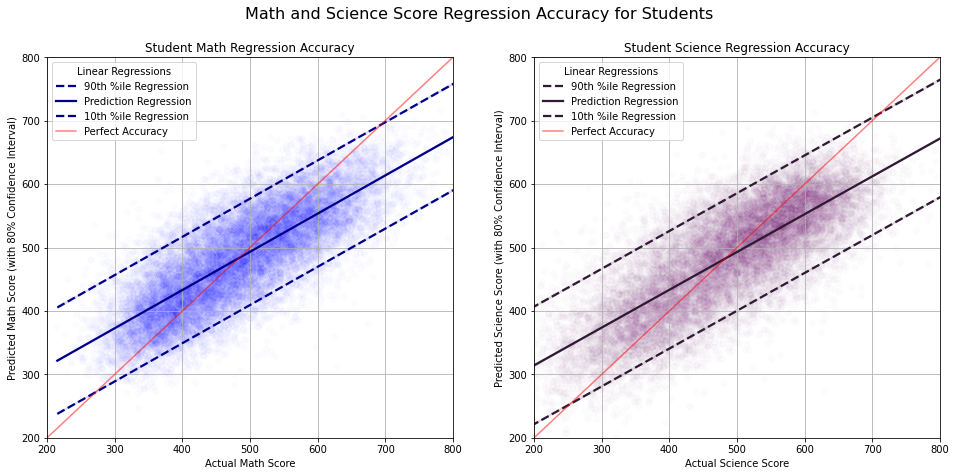

In [305]:
plt.figure(figsize=(16,7))
plt.suptitle('Math and Science Score Regression Accuracy for Students', fontsize=16)
plt.subplot(121)
sns.regplot(x=y_test_stud_math, y=pred_CI_stud_math.obs_ci_upper.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#00008B'});
sns.regplot(x=y_test_stud_math, y=pred_stud_math, scatter_kws={'alpha':0.01, 'color':'blue'}, line_kws={'color':'#00008B'});
sns.regplot(x=y_test_stud_math, y=pred_CI_stud_math.obs_ci_lower.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#00008B'});
x=np.arange(200,810,10)
plt.plot(x,x,color='#FF0000',alpha=0.5);
plt.legend(['90th %ile Regression','Prediction Regression','10th %ile Regression','Perfect Accuracy'], title="Linear Regressions")
plt.title('Student Math Regression Accuracy')
plt.xlabel('Actual Math Score')
plt.ylabel('Predicted Math Score (with 80% Confidence Interval)')
plt.grid(True)
plt.xlim(200,800);
plt.ylim(200,800)
plt.subplot(122)
sns.regplot(x=y_test_stud_sci, y=pred_CI_stud_sci.obs_ci_upper.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#301934'});
sns.regplot(x=y_test_stud_sci, y=pred_stud_sci, scatter_kws={'alpha':0.01, 'color':'purple'}, line_kws={'color':'#301934'});
sns.regplot(x=y_test_stud_sci, y=pred_CI_stud_sci.obs_ci_lower.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#301934'});
x=np.arange(200,810,10)
plt.plot(x,x,color='#FF0000',alpha=0.5);
plt.legend(['90th %ile Regression','Prediction Regression','10th %ile Regression','Perfect Accuracy'], title="Linear Regressions")
plt.title('Student Science Regression Accuracy')
plt.xlabel('Actual Science Score')
plt.ylabel('Predicted Science Score (with 80% Confidence Interval)')
plt.grid(True)
plt.xlim(200,800);
plt.ylim(200,800);

In [306]:
school.columns

Index(['IDCNTRY', 'IDSCHOOL', 'grade', 'language', 'disc_prob_score',
       'acad_emph_score', 'math_shortage_score', 'sci_shortage_score',
       'acad_hours', 'disc_prob', 'acad_emph', 'math_shortage', 'sci_shortage',
       'socio_background', 'mmat_avg', 'ssci_avg', 'malg_avg', 'mapp_avg',
       'mdat_avg', 'mgeo_avg', 'mkno_avg', 'mnum_avg', 'mrea_avg', 'sapp_avg',
       'sbio_avg', 'sche_avg', 'sear_avg', 'skno_avg', 'sphy_avg', 'srea_avg'],
      dtype='object')

In [307]:
school['IDCNTRY'] = school['IDCNTRY'].astype(str)

In [308]:
school_sub_set = school[['IDCNTRY', 'grade', 'acad_hours', 'disc_prob', 'acad_emph', 'math_shortage', 'sci_shortage',
       'socio_background', 'mmat_avg', 'ssci_avg']].dropna()

In [309]:
X_sch = school_sub_set[['IDCNTRY', 'grade', 'acad_hours', 'disc_prob', 'acad_emph', 'math_shortage', 'sci_shortage','socio_background']]
X_sch = pd.get_dummies(data=X_sch, drop_first=True)
X_sch.head()

grade  acad_hours  IDCNTRY_36  IDCNTRY_376  IDCNTRY_380  IDCNTRY_392  \
0      8  1350.00000           0            0            0            0   
1      8  1025.66667           0            0            0            0   
2      8   957.66667           0            0            0            0   
3      8  1680.00000           0            0            0            0   
4      8  1110.00000           0            0            0            0   

   IDCNTRY_422  IDCNTRY_620  IDCNTRY_710  IDCNTRY_784  IDCNTRY_840  \
0            0            0            0            1            0   
1            0            0            0            1            0   
2            0            0            0            1            0   
3            0            0            0            1            0   
4            0            0            0            1            0   

   IDCNTRY_926  disc_prob_Minor Problems  \
0            0                         1   
1            0                         0   
2            0                         1   
3            0                         1   
4            0                         0   

   disc_prob_Moderate to Severe Problems  acad_emph_Medium Emphasis  \
0                                      0                          1   
1                                      1                          0   
2                                      0                          0   
3                                      0                          1   
4                                      0                          0   

   acad_emph_Very High Emphasis  math_shortage_Affected A Lot  \
0                             0                             0   
1                             0                             0   
2                             0                             0   
3                             0                             0   
4                             0                             0   

   math_shortage_Not Affected  sci_shortage_Affected A Lot  \
0                           1                            0   
1                           1                            0   
2                           0                            0   
3                           1                            0   
4                           0                            0   

   sci_shortage_Not Affected  socio_background_More Disadvantaged  \
0                          1                                    0   
1                          1                                    0   
2                          0                                    1   
3                          1                                    0   
4                          0                                    0   

   socio_background_Neither More Affluent nor More Disadvantaged  
0                                                  1              
1                                                  0              
2                                                  0              
3                                                  0              
4                                                  0

In [310]:
Y_sch_math = school_sub_set['mmat_avg']
Y_sch_sci = school_sub_set['ssci_avg']

In [311]:
X_train_sch_math, X_test_sch_math, y_train_sch_math, y_test_sch_math = train_test_split(X_sch, Y_sch_math, test_size=0.4, random_state=101)
X_train_sch_sci, X_test_sch_sci, y_train_sch_sci, y_test_sch_sci = train_test_split(X_sch, Y_sch_sci, test_size=0.4, random_state=101)

print(X_train_sch_math.shape)
print(X_test_sch_math.shape)
print(y_train_sch_math.shape)
print(y_test_sch_math.shape)

(1295, 22)
(864, 22)
(1295,)
(864,)


In [312]:
X_train_sch_math = sm.add_constant(X_train_sch_math)
X_train_sch_sci = sm.add_constant(X_train_sch_sci)

ls_sch_math = sm.OLS(y_train_sch_math, X_train_sch_math).fit()
ls_sch_sci = sm.OLS(y_train_sch_sci, X_train_sch_sci).fit()

print(ls_sch_math.summary())
print(ls_sch_sci.summary())

                            OLS Regression Results                            
Dep. Variable:               mmat_avg   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     74.64
Date:                Tue, 30 Mar 2021   Prob (F-statistic):          2.02e-204
Time:                        07:25:01   Log-Likelihood:                -6946.9
No. Observations:                1295   AIC:                         1.394e+04
Df Residuals:                    1273   BIC:                         1.405e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [313]:
x_matrix_sch_math = sm.add_constant(X_test_sch_math)
pred_sch_math = ls_sch_math.predict(x_matrix_sch_math)
pred_CI_sch_math = ls_sch_math.get_prediction(x_matrix_sch_math)
pred_CI_sch_math = pred_CI_sch_math.summary_frame(alpha=0.20)

x_matrix_sch_sci = sm.add_constant(X_test_sch_sci)
pred_sch_sci = ls_sch_sci.predict(x_matrix_sch_sci)
pred_CI_sch_sci = ls_sch_sci.get_prediction(x_matrix_sch_sci)
pred_CI_sch_sci = pred_CI_sch_sci.summary_frame(alpha=0.20)

In [314]:
results_sch_math = pd.merge(school[['mmat_avg']],pred_CI_sch_math[['obs_ci_lower','mean','obs_ci_upper']], left_index=True, right_index=True)
results_sch_math['capture'] = ((results_sch_math['mmat_avg'] >= results_sch_math['obs_ci_lower']).astype(int)\
                                *(results_sch_math['mmat_avg'] <= results_sch_math['obs_ci_upper']).astype(int)).astype(bool)
cap_rate_sch_math = results_sch_math['capture'].sum()/results_sch_math.shape[0]
results_sch_sci = pd.merge(school[['ssci_avg']],pred_CI_sch_sci[['obs_ci_lower','mean','obs_ci_upper']], left_index=True, right_index=True)
results_sch_sci['capture'] = ((results_sch_sci['ssci_avg'] >= results_sch_sci['obs_ci_lower']).astype(int)\
                                *(results_sch_sci['ssci_avg'] <= results_sch_sci['obs_ci_upper']).astype(int)).astype(bool)
cap_rate_sch_sci = results_sch_sci['capture'].sum()/results_sch_sci.shape[0]
print('School Math Regression\nConfidence Interval Capture Rate = {}\n\
School Science Regression\nConfidence Interval Capture Rate = {}'.format(cap_rate_stud_math, cap_rate_stud_sci))

School Math Regression
Confidence Interval Capture Rate = 0.8086895960570021
School Science Regression
Confidence Interval Capture Rate = 0.8090646094503375


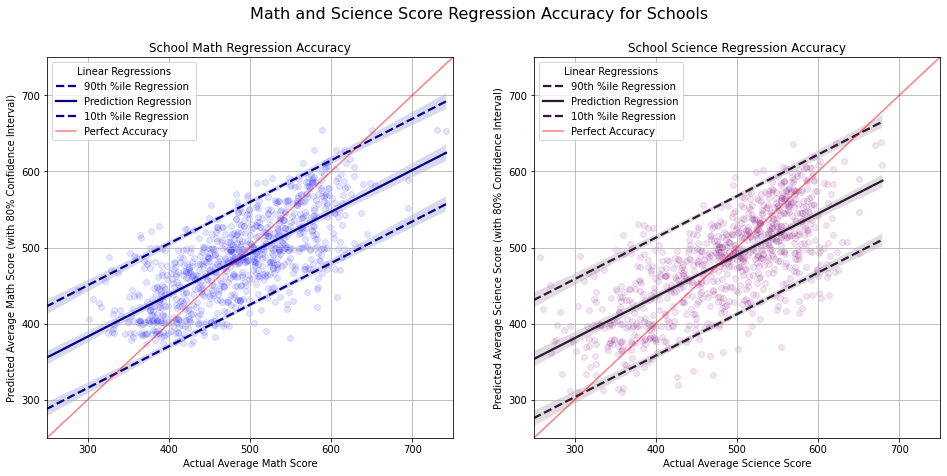

In [315]:
plt.figure(figsize=(16,7))
plt.suptitle('Math and Science Score Regression Accuracy for Schools', fontsize=16)
plt.subplot(121)
sns.regplot(x=y_test_sch_math, y=pred_CI_sch_math.obs_ci_upper.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#00008B'});
sns.regplot(x=y_test_sch_math, y=pred_sch_math, scatter_kws={'alpha':0.1, 'color':'blue'}, line_kws={'color':'#00008B'});
sns.regplot(x=y_test_sch_math, y=pred_CI_sch_math.obs_ci_lower.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#00008B'});
x=np.arange(200,810,10)
plt.plot(x,x,color='#FF0000',alpha=0.5);
plt.legend(['90th %ile Regression','Prediction Regression','10th %ile Regression','Perfect Accuracy'], title="Linear Regressions")
plt.title('School Math Regression Accuracy')
plt.xlabel('Actual Average Math Score')
plt.ylabel('Predicted Average Math Score (with 80% Confidence Interval)')
plt.grid(True)
plt.xlim(250,750);
plt.ylim(250,750)
plt.subplot(122)
sns.regplot(x=y_test_sch_sci, y=pred_CI_sch_sci.obs_ci_upper.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#301934'});
sns.regplot(x=y_test_sch_sci, y=pred_sch_sci, scatter_kws={'alpha':0.1, 'color':'purple'}, line_kws={'color':'#301934'});
sns.regplot(x=y_test_sch_sci, y=pred_CI_sch_sci.obs_ci_lower.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#301934'});
x=np.arange(200,810,10)
plt.plot(x,x,color='#FF0000',alpha=0.5);
plt.legend(['90th %ile Regression','Prediction Regression','10th %ile Regression','Perfect Accuracy'], title="Linear Regressions")
plt.title('School Science Regression Accuracy')
plt.xlabel('Actual Average Science Score')
plt.ylabel('Predicted Average Science Score (with 80% Confidence Interval)')
plt.grid(True)
plt.xlim(250,750);
plt.ylim(250,750);

In [316]:
math_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'experience',
       'sex', 'age', 'prob_class_size', 'prob_much_material', 'prob_much_time',
       'prob_need_prep', 'prob_need_class_time', 'prob_much_pressure',
       'prob_change_material', 'prob_admin_tasks', 'class_size',
       'stud_lang_diff', 'style_daily_lives', 'style_explain_work',
       'style_challenge', 'style_discussion', 'style_link_previous',
       'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_explain_solve', 'stud_memorize',
       'stud_practice', 'stud_apply', 'stud_class_work', 'stud_heterogeneous',
       'stud_homogenous', 'computer_math', 'computer_stud', 'computer_class',
       'computer_school', 'computer_class_freq', 'computer_low_freq',
       'computer_high_freq', 'computer_spec_freq', 'hw_freq', 'hw_time',
       'hw_correct', 'hw_self_correct', 'hw_discuss', 'hw_complete',
       'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
   

In [317]:
math_teach['IDCNTRY'] = math_teach['IDCNTRY'].astype(str)

In [318]:
math_teach_sub_set = math_teach[['IDCNTRY','experience','style_daily_lives', 'style_explain_work',
       'style_challenge', 'style_discussion', 'style_link_previous',
       'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_explain_solve', 'stud_memorize',
       'stud_practice', 'stud_apply', 'stud_class_work', 'stud_heterogeneous',
       'stud_homogenous', 'computer_class', 'hw_freq', 'hw_time',
       'hw_self_correct', 'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
       'assess_long', 'assess_projects', 'pd_hours',
       'school_acad_focus_score', 'limited_by_needs_score',
       'school_safe_score', 'job_satisfaction_score','study_stem', 'study_edu','edu_level','mmat_avg']].dropna()

In [319]:
X_math_teach = math_teach_sub_set[['IDCNTRY','experience','style_daily_lives', 'style_explain_work',
       'style_challenge', 'style_discussion', 'style_link_previous',
       'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_explain_solve', 'stud_memorize',
       'stud_practice', 'stud_apply', 'stud_class_work', 'stud_heterogeneous',
       'stud_homogenous', 'computer_class', 'hw_freq', 'hw_time',
       'hw_self_correct', 'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
       'assess_long', 'assess_projects', 'pd_hours',
       'school_acad_focus_score', 'limited_by_needs_score',
       'school_safe_score', 'job_satisfaction_score','study_stem', 'study_edu','edu_level']]
X_math_teach = pd.get_dummies(data=X_math_teach, drop_first=True)
X_math_teach.head()

experience  style_daily_lives  style_explain_work  style_challenge  \
6         23.0                3.0                 3.0              2.0   
10         6.0                3.0                 3.0              3.0   
11         7.0                2.0                 3.0              3.0   
12        28.0                3.0                 3.0              2.0   
13        28.0                3.0                 3.0              2.0   

    style_discussion  style_link_previous  style_procedures  \
6                3.0                  3.0               2.0   
10               3.0                  3.0               2.0   
11               3.0                  3.0               3.0   
12               3.0                  3.0               3.0   
13               2.0                  3.0               3.0   

    style_express_ideas  class_time  stud_explain_new  stud_explain_solve  \
6                   2.0       360.0               0.0                 0.0   
10                  2.0       160.0               3.0                 3.0   
11                  3.0       145.0               3.0                 3.0   
12                  3.0       360.0               3.0                 2.0   
13                  3.0       360.0               2.0                 1.0   

    stud_memorize  stud_practice  stud_apply  stud_class_work  \
6             1.0            3.0         3.0              2.0   
10            3.0            3.0         3.0              3.0   
11            1.0            3.0         3.0              3.0   
12            2.0            3.0         3.0              3.0   
13            2.0            2.0         2.0              3.0   

    stud_heterogeneous  stud_homogenous  computer_class  hw_freq  hw_time  \
6                  2.0              2.0             1.0      3.0     30.0   
10                 1.0              3.0             0.0      2.0     60.0   
11                 1.0              3.0             0.0      2.0     60.0   
12                 3.0              2.0             0.0      3.0     30.0   
13                 3.0              2.0             0.0      3.0     30.0   

    hw_self_correct  hw_graded  assess_observe  assess_ask  assess_short  \
6               0.0        1.0             2.0         2.0           2.0   
10              2.0        1.0             2.0         2.0           2.0   
11              2.0        0.0             2.0         2.0           2.0   
12              1.0        2.0             2.0         2.0           1.0   
13              1.0        2.0             2.0         1.0           1.0   

    assess_long  assess_projects  school_acad_focus_score  \
6           2.0              1.0                  7.62867   
10          2.0              1.0                 13.86227   
11          2.0              0.0                  9.14714   
12          1.0              0.0                  8.84690   
13          1.0              0.0                  7.62867   

    limited_by_needs_score  school_safe_score  job_satisfaction_score  \
6                 10.69865           10.58171                 6.19622   
10                15.29511           13.87035                10.82008   
11                 8.63238            9.18523                 9.22836   
12                 9.61910            9.18523                11.74559   
13                 8.15603            9.18523                11.74559   

    study_stem  study_edu  IDCNTRY_36  IDCNTRY_376  IDCNTRY_380  IDCNTRY_392  \
6            1          0           0            0            0            0   
10           1          1           0            0            0            0   
11           1          1           0            0            0            0   
12           1          1           0            0            0            0   
13           1          1           0            0            0            0   

    IDCNTRY_422  IDCNTRY_620  IDCNTRY_710  IDCNTRY_784  IDCNTRY_840  \
6             0            0            0       

In [320]:
Y_math_teach = math_teach_sub_set['mmat_avg']

In [321]:
X_train_math_teach, X_test_math_teach, y_train_math_teach, y_test_math_teach = train_test_split(X_math_teach, Y_math_teach, test_size=0.4, random_state=101)

print(X_train_math_teach.shape)
print(X_test_math_teach.shape)
print(y_train_math_teach.shape)
print(y_test_math_teach.shape)

(837, 53)
(558, 53)
(837,)
(558,)


In [322]:
import statsmodels.api as sm

X_train_math_teach = sm.add_constant(X_train_math_teach)
ls_math_teach = sm.OLS(y_train_math_teach, X_train_math_teach).fit()
print(ls_math_teach.summary())

                            OLS Regression Results                            
Dep. Variable:               mmat_avg   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     14.86
Date:                Tue, 30 Mar 2021   Prob (F-statistic):           4.35e-85
Time:                        07:25:03   Log-Likelihood:                -4627.2
No. Observations:                 837   AIC:                             9360.
Df Residuals:                     784   BIC:                             9611.
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [323]:
x_matrix_math_teach = sm.add_constant(X_test_math_teach)
pred_math_teach = ls_math_teach.predict(x_matrix_math_teach)
pred_CI_math_teach = ls_math_teach.get_prediction(x_matrix_math_teach)
pred_CI_math_teach = pred_CI_math_teach.summary_frame(alpha=0.20)

In [324]:
results_math_teach = pd.merge(math_teach[['mmat_avg']],pred_CI_math_teach[['obs_ci_lower','mean','obs_ci_upper']], left_index=True, right_index=True)
results_math_teach['capture'] = ((results_math_teach['mmat_avg'] >= results_math_teach['obs_ci_lower']).astype(int)\
                                *(results_math_teach['mmat_avg'] <= results_math_teach['obs_ci_upper']).astype(int)).astype(bool)
cap_rate_math_teach = results_math_teach['capture'].sum()/results_math_teach.shape[0]
print('Math Teacher Regression\nConfidence Interval Capture Rate = {}'.format(cap_rate_math_teach))

Math Teacher Regression
Confidence Interval Capture Rate = 0.8458781362007168


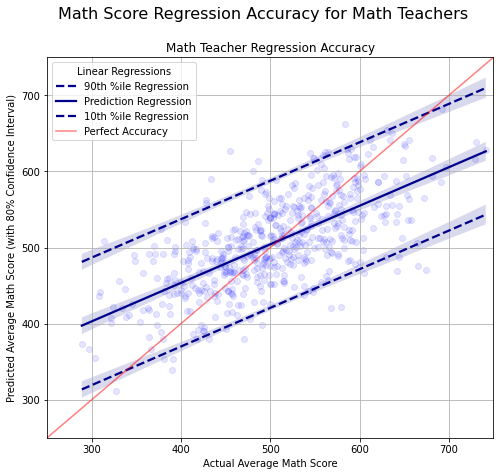

In [325]:
plt.figure(figsize=(8,7))
plt.suptitle('Math Score Regression Accuracy for Math Teachers', fontsize=16)
sns.regplot(x=y_test_math_teach, y=pred_CI_math_teach.obs_ci_upper.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#00008B'});
sns.regplot(x=y_test_math_teach, y=pred_math_teach, scatter_kws={'alpha':0.1, 'color':'blue'}, line_kws={'color':'#00008B'});
sns.regplot(x=y_test_math_teach, y=pred_CI_math_teach.obs_ci_lower.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#00008B'});
x=np.arange(200,810,10)
plt.plot(x,x,color='#FF0000',alpha=0.5);
plt.legend(['90th %ile Regression','Prediction Regression','10th %ile Regression','Perfect Accuracy'], title="Linear Regressions")
plt.title('Math Teacher Regression Accuracy')
plt.xlabel('Actual Average Math Score')
plt.ylabel('Predicted Average Math Score (with 80% Confidence Interval)')
plt.grid(True)
plt.xlim(250,750);
plt.ylim(250,750);

In [326]:
sci_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'ITCOURSE',
       'experience', 'sex', 'age', 'prob_class_size', 'prob_much_material',
       'prob_much_time', 'prob_need_prep', 'prob_need_class_time',
       'prob_much_pressure', 'prob_change_material', 'prob_admin_tasks',
       'class_size', 'stud_lang_diff', 'style_daily_lives',
       'style_explain_work', 'style_challenge', 'style_discussion',
       'style_link_previous', 'style_procedures', 'style_express_ideas',
       'class_time', 'stud_explain_new', 'stud_observe_phenom',
       'stud_demo_exp', 'stud_plan_exp', 'stud_conduct_exp', 'stud_present',
       'stud_interpret', 'stud_use_evid', 'stud_read_text', 'stud_memorize',
       'stud_formulas', 'stud_field', 'stud_heterogeneous', 'stud_homogenous',
       'computer_sci', 'computer_stud', 'computer_class', 'computer_school',
       'computer_class_freq', 'computer_low_freq', 'computer_high_freq',
       'computer_spec_freq', 'hw_freq', 'hw_time', 'hw_correc

In [327]:
sci_teach['IDCNTRY'] = sci_teach['IDCNTRY'].astype(str)

In [328]:
sci_teach_sub_set = sci_teach[['IDCNTRY','experience','style_daily_lives',
       'style_explain_work', 'style_challenge', 'style_discussion',
       'style_link_previous', 'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_observe_phenom',
       'stud_demo_exp', 'stud_plan_exp', 'stud_conduct_exp', 'stud_present',
       'stud_interpret', 'stud_use_evid', 'stud_read_text', 'stud_memorize',
       'stud_formulas', 'stud_field', 'stud_heterogeneous', 'stud_homogenous', 'computer_class', 'hw_freq', 'hw_time',
       'hw_self_correct', 'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
       'assess_long', 'assess_projects', 'pd_hours',
       'school_acad_focus_score', 'limited_by_needs_score',
       'school_safe_score', 'job_satisfaction_score','study_stem', 'study_edu','edu_level','ssci_avg']].dropna()

In [329]:
X_sci_teach = sci_teach_sub_set[['IDCNTRY','experience','style_daily_lives',
       'style_explain_work', 'style_challenge', 'style_discussion',
       'style_link_previous', 'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_observe_phenom',
       'stud_demo_exp', 'stud_plan_exp', 'stud_conduct_exp', 'stud_present',
       'stud_interpret', 'stud_use_evid', 'stud_read_text', 'stud_memorize',
       'stud_formulas', 'stud_field', 'stud_heterogeneous', 'stud_homogenous', 'computer_class', 'hw_freq', 'hw_time',
       'hw_self_correct', 'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
       'assess_long', 'assess_projects', 'pd_hours',
       'school_acad_focus_score', 'limited_by_needs_score',
       'school_safe_score', 'job_satisfaction_score','study_stem', 'study_edu','edu_level']]
X_sci_teach = pd.get_dummies(data=X_sci_teach, drop_first=True)
X_sci_teach.head()

experience  style_daily_lives  style_explain_work  style_challenge  \
0         30.0                3.0                 2.0              1.0   
4         10.0                1.0                 2.0              1.0   
11        10.0                2.0                 3.0              1.0   
12        11.0                3.0                 3.0              2.0   
13        11.0                3.0                 2.0              2.0   

    style_discussion  style_link_previous  style_procedures  \
0                1.0                  3.0               3.0   
4                1.0                  2.0               2.0   
11               1.0                  3.0               2.0   
12               2.0                  2.0               2.0   
13               2.0                  2.0               2.0   

    style_express_ideas  class_time  stud_explain_new  stud_observe_phenom  \
0                   3.0       200.0               3.0                  2.0   
4                   2.0       225.0               3.0                  1.0   
11                  3.0       160.0               2.0                  2.0   
12                  2.0       270.0               1.0                  1.0   
13                  2.0       270.0               2.0                  2.0   

    stud_demo_exp  stud_plan_exp  stud_conduct_exp  stud_present  \
0             2.0            3.0               2.0           3.0   
4             1.0            2.0               2.0           2.0   
11            1.0            1.0               1.0           1.0   
12            2.0            1.0               2.0           2.0   
13            2.0            2.0               2.0           2.0   

    stud_interpret  stud_use_evid  stud_read_text  stud_memorize  \
0              3.0            3.0             3.0            2.0   
4              1.0            1.0             2.0            2.0   
11             1.0            1.0             1.0            1.0   
12             2.0            2.0             2.0            1.0   
13             2.0            2.0             2.0            2.0   

    stud_formulas  stud_field  stud_heterogeneous  stud_homogenous  \
0             3.0         1.0                 2.0              1.0   
4             1.0         1.0                 2.0              1.0   
11            0.0         0.0                 1.0              1.0   
12            1.0         1.0                 1.0              1.0   
13            2.0         2.0                 2.0              2.0   

    computer_class  hw_freq  hw_time  hw_self_correct  hw_graded  \
0              1.0      3.0     15.0              1.0        1.0   
4              0.0      2.0     60.0              2.0        0.0   
11             0.0      1.0     60.0              1.0        1.0   
12             0.0      3.0     15.0              1.0        1.0   
13             0.0      3.0     15.0              1.0        1.0   

    assess_observe  assess_ask  assess_short  assess_long  assess_projects  \
0              2.0         2.0           2.0          1.0              1.0   
4              1.0         1.0           2.0          1.0              1.0   
11             2.0         2.0           1.0          1.0              2.0   
12             2.0         2.0           1.0          1.0              1.0   
13             2.0         1.0           1.0          1.0              1.0   

    school_acad_focus_score  limited_by_needs_score  school_safe_score  \
0                   9.14714                11.28828           11.78998   
4                   7.62867                 8.15603            8.01327   
11                 10.95225                11.93195           13.87035   
12                  9.74934                 8.15603            8.01327   
13                  9.44792                 8.63238            9.61153   

    job_satisfaction_score  study_stem  study_edu  IDCNTRY_36  IDCNTRY_376  \
0                 11.74559           1          1           0          

In [330]:
Y_sci_teach = sci_teach_sub_set['ssci_avg']

In [331]:
X_train_sci_teach, X_test_sci_teach, y_train_sci_teach, y_test_sci_teach = train_test_split(X_sci_teach, Y_sci_teach, test_size=0.4, random_state=101)

print(X_train_sci_teach.shape)
print(X_test_sci_teach.shape)
print(y_train_sci_teach.shape)
print(y_test_sci_teach.shape)

(1020, 58)
(681, 58)
(1020,)
(681,)


In [332]:
X_train_sci_teach = sm.add_constant(X_train_sci_teach)
ls_sci_teach = sm.OLS(y_train_sci_teach, X_train_sci_teach).fit()
print(ls_sci_teach.summary())

                            OLS Regression Results                            
Dep. Variable:               ssci_avg   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     14.27
Date:                Tue, 30 Mar 2021   Prob (F-statistic):           9.07e-94
Time:                        07:25:03   Log-Likelihood:                -5694.9
No. Observations:                1020   AIC:                         1.151e+04
Df Residuals:                     961   BIC:                         1.180e+04
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [333]:
x_matrix_sci_teach = sm.add_constant(X_test_sci_teach)
pred_sci_teach = ls_sci_teach.predict(x_matrix_sci_teach)
pred_CI_sci_teach = ls_sci_teach.get_prediction(x_matrix_sci_teach)
pred_CI_sci_teach = pred_CI_sci_teach.summary_frame(alpha=0.20)

In [334]:
results_sci_teach = pd.merge(sci_teach[['ssci_avg']],pred_CI_sci_teach[['obs_ci_lower','mean','obs_ci_upper']], left_index=True, right_index=True)
results_sci_teach['capture'] = ((results_sci_teach['ssci_avg'] >= results_sci_teach['obs_ci_lower']).astype(int)\
                                *(results_sci_teach['ssci_avg'] <= results_sci_teach['obs_ci_upper']).astype(int)).astype(bool)
cap_rate_sci_teach = results_sci_teach['capture'].sum()/results_sci_teach.shape[0]
print('Science Teacher Regression\nConfidence Interval Capture Rate = {}'.format(cap_rate_sci_teach))

Science Teacher Regression
Confidence Interval Capture Rate = 0.8002936857562408


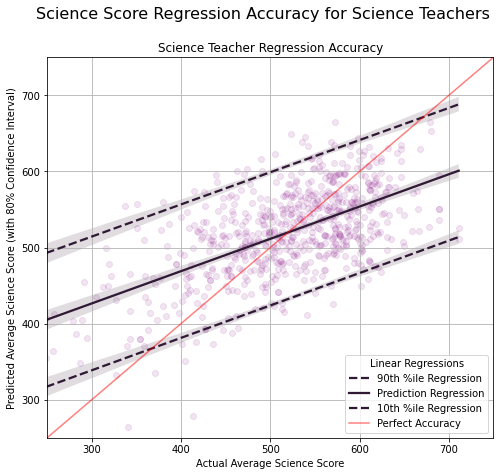

In [335]:
plt.figure(figsize=(8,7))
plt.suptitle('Science Score Regression Accuracy for Science Teachers', fontsize=16)
sns.regplot(x=y_test_sci_teach, y=pred_CI_sci_teach.obs_ci_upper.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#301934'});
sns.regplot(x=y_test_sci_teach, y=pred_sci_teach, scatter_kws={'alpha':0.1, 'color':'purple'}, line_kws={'color':'#301934'});
sns.regplot(x=y_test_sci_teach, y=pred_CI_sci_teach.obs_ci_lower.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#301934'});
x=np.arange(200,810,10)
plt.plot(x,x,color='#FF0000',alpha=0.5);
plt.legend(['90th %ile Regression','Prediction Regression','10th %ile Regression','Perfect Accuracy'], title="Linear Regressions")
plt.title('Science Teacher Regression Accuracy')
plt.xlabel('Actual Average Science Score')
plt.ylabel('Predicted Average Science Score (with 80% Confidence Interval)')
plt.grid(True)
plt.xlim(250,750);
plt.ylim(250,750);

[Return to Top of Data Modeling](#data_modeling)

<div id='classification_models'></div>

## Classification Models

In [336]:
def display_results(cv, y_test, y_pred):
    labels = np.unique(y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
    accuracy = (y_pred == y_test).mean()

    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print("Accuracy:", accuracy)
    print("\nBest Parameters:", cv.best_params_)

In [337]:
school['socio_background'].value_counts()

More Disadvantaged                              1026
More Affluent                                    771
Neither More Affluent nor More Disadvantaged     644
Name: socio_background, dtype: int64

In [338]:
school.columns

Index(['IDCNTRY', 'IDSCHOOL', 'grade', 'language', 'disc_prob_score',
       'acad_emph_score', 'math_shortage_score', 'sci_shortage_score',
       'acad_hours', 'disc_prob', 'acad_emph', 'math_shortage', 'sci_shortage',
       'socio_background', 'mmat_avg', 'ssci_avg', 'malg_avg', 'mapp_avg',
       'mdat_avg', 'mgeo_avg', 'mkno_avg', 'mnum_avg', 'mrea_avg', 'sapp_avg',
       'sbio_avg', 'sche_avg', 'sear_avg', 'skno_avg', 'sphy_avg', 'srea_avg'],
      dtype='object')

In [339]:
math_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'experience',
       'sex', 'age', 'prob_class_size', 'prob_much_material', 'prob_much_time',
       'prob_need_prep', 'prob_need_class_time', 'prob_much_pressure',
       'prob_change_material', 'prob_admin_tasks', 'class_size',
       'stud_lang_diff', 'style_daily_lives', 'style_explain_work',
       'style_challenge', 'style_discussion', 'style_link_previous',
       'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_explain_solve', 'stud_memorize',
       'stud_practice', 'stud_apply', 'stud_class_work', 'stud_heterogeneous',
       'stud_homogenous', 'computer_math', 'computer_stud', 'computer_class',
       'computer_school', 'computer_class_freq', 'computer_low_freq',
       'computer_high_freq', 'computer_spec_freq', 'hw_freq', 'hw_time',
       'hw_correct', 'hw_self_correct', 'hw_discuss', 'hw_complete',
       'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
   

In [340]:
new_set = school.set_index(['IDCNTRY','IDSCHOOL']).join(math_teach.groupby(['IDCNTRY','IDSCHOOL']).mean().loc[:,['class_size','experience','job_satisfaction_score','class_time']]
                                                        .join(sci_teach.groupby(['IDCNTRY','IDSCHOOL']).mean().loc[:,['class_size','experience','job_satisfaction_score','class_time']], 
                                                              lsuffix="_math", rsuffix="_sci")).dropna()

In [341]:
new_set.reset_index(inplace=True)
new_set['IDCNTRY'] = new_set['IDCNTRY'].astype(str)

In [342]:
X_socio = new_set[['IDCNTRY','disc_prob_score','acad_emph_score','acad_hours','class_size_math','class_time_math','experience_math','class_size_sci','class_time_sci','experience_sci']]
y_socio = new_set.socio_background
print(X_socio.shape)
print(y_socio.shape)

(1558, 10)
(1558,)


In [343]:
# Split into training and test sets
X_train_socio, X_test_socio, y_train_socio, y_test_socio = train_test_split(X_socio, y_socio, test_size=0.2, random_state=42)

In [356]:
clf_socio = RandomForestClassifier(random_state=0, n_jobs=-1)
clf_socio.get_params().keys()
# specify parameters for grid search
parameters_socio = {
    'bootstrap':[True, False],
    'criterion': ['gini', 'entropy'],
    'n_estimators': [30, 50, 75]
}

# create grid search object
cv_socio = GridSearchCV(clf_socio, param_grid=parameters_socio)
cv_socio.fit(X_train_socio, y_train_socio)

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'n_estimators': [30, 50, 75]})

In [345]:
y_pred_socio = cv_socio.predict(X_test_socio)
    
display_results(cv_socio, y_test_socio, y_pred_socio)

Labels: ['More Affluent' 'More Disadvantaged'
 'Neither More Affluent nor More Disadvantaged']
Confusion Matrix:
 [[67 19 41]
 [29 55 30]
 [25 19 27]]
Accuracy: 0.4775641025641026

Best Parameters: {'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 50}


In [357]:
new_set['IDCNTRY'] = new_set['IDCNTRY'].astype(int)
X = new_set[['IDCNTRY','disc_prob_score','acad_emph_score','acad_hours','class_size_math','class_time_math','experience_math','class_size_sci','class_time_sci','experience_sci']]
y = new_set.socio_background
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [358]:
# Create a classifier
xgb = XGBClassifier(booster='gbtree', random_state=42, eval_metric="rmse", num_class=3, n_estimators=500)
# Fit the classifier with the training data
xgb.fit(X_train,y_train)

C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=12,
              num_class=3, num_parallel_tree=1, objective='multi:softprob',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [359]:
predictions_xgb = xgb.predict(X_test)

In [360]:
(y_test == predictions_xgb).mean()

0.4423076923076923

In [361]:
new_set['IDCNTRY'] = new_set['IDCNTRY'].astype(str)
X = new_set[['IDCNTRY','disc_prob_score','acad_emph_score','acad_hours','class_size_math','class_time_math','experience_math','class_size_sci','class_time_sci','experience_sci']]
y = new_set.socio_background
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [362]:
knn = KNeighborsClassifier(n_neighbors=13, weights = 'distance')
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=13, weights='distance')

In [363]:
predictions_knn = knn.predict(X_test)

In [364]:
(y_test == predictions_knn).mean()

0.4358974358974359

In [365]:
(y_pred_socio == predictions_xgb).mean()

0.6955128205128205

In [366]:
(predictions_knn == predictions_xgb).mean()

0.48717948717948717

In [367]:
(predictions_knn == y_pred_socio).mean()

0.47435897435897434

In [368]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{'More Affluent': 127,
 'More Disadvantaged': 114,
 'Neither More Affluent nor More Disadvantaged': 71}

In [370]:
unique, counts = np.unique(y_pred_socio, return_counts=True)
dict(zip(unique, counts))

{'More Affluent': 121,
 'More Disadvantaged': 93,
 'Neither More Affluent nor More Disadvantaged': 98}

In [371]:
unique, counts = np.unique(predictions_xgb, return_counts=True)
dict(zip(unique, counts))

{'More Affluent': 116,
 'More Disadvantaged': 86,
 'Neither More Affluent nor More Disadvantaged': 110}

In [373]:
output = pd.DataFrame()
output['Expected Output'] = y_test
output['RF Output'] = y_pred_socio
output['XGB Output'] = predictions_xgb
output['KNN Output'] = predictions_knn
output.head(20)

Expected Output  \
1370  Neither More Affluent nor More Disadvantaged   
168                                  More Affluent   
353                             More Disadvantaged   
468   Neither More Affluent nor More Disadvantaged   
1483                                 More Affluent   
1511                            More Disadvantaged   
59                                   More Affluent   
415                                  More Affluent   
715   Neither More Affluent nor More Disadvantaged   
354                                  More Affluent   
30    Neither More Affluent nor More Disadvantaged   
1281                            More Disadvantaged   
858                                  More Affluent   
1527                                 More Affluent   
651                             More Disadvantaged   
1298  Neither More Affluent nor More Disadvantaged   
374   Neither More Affluent nor More Disadvantaged   
351                             More Disadvantaged   
1507                                 More Affluent   
979   Neither More Affluent nor More Disadvantaged   

                                         RF Output  \
1370                                 More Affluent   
168                             More Disadvantaged   
353                                  More Affluent   
468                             More Disadvantaged   
1483                                 More Affluent   
1511                            More Disadvantaged   
59                              More Disadvantaged   
415   Neither More Affluent nor More Disadvantaged   
715                                  More Affluent   
354                                  More Affluent   
30                                   More Affluent   
1281                            More Disadvantaged   
858                                  More Affluent   
1527  Neither More Affluent nor More Disadvantaged   
651                             More Disadvantaged   
1298                            More Disadvantaged   
374   Neither More Affluent nor More Disadvantaged   
351                                  More Affluent   
1507                                 More Affluent   
979                                  More Affluent   

                                        XGB Output  \
1370                                 More Affluent   
168   Neither More Affluent nor More Disadvantaged   
353   Neither More Affluent nor More Disadvantaged   
468                             More Disadvantaged   
1483                                 More Affluent   
1511                            More Disadvantaged   
59    Neither More Affluent nor More Disadvantaged   
415   Neither More Affluent nor More Disadvantaged   
715   Neither More Affluent nor More Disadvantaged   
354                                  More Affluent   
30                                   More Affluent   
1281                            More Disadvantaged   
858   Neither More Affluent nor More Disadvantaged   
1527  Neither More Affluent nor More Disadvantaged   
651                             More Disadvantaged   
1298                            More Disadvantaged   
374   Neither More Affluent nor More Disadvantaged   
351                                  More Affluent   
1507                                 More Affluent   
979                                  More Affluent   

                                        KNN Output  
1370                            More Disadvantaged  
168                                  More Affluent  
353                             More Disadvantaged  
468                                  More Affluent  
1483                            More Disadvantaged  
1511                            More Disadvantaged  
59                                   More Affluent  
415   Neither More Affluent nor More Disadvantaged  
715                                  More Affluent  
354                                  More Affluent  
30    Neither More Affluent nor More Disadvanta

[Return to Top of Data Modeling](#data_modeling)

<div id='recommendation_engine'></div>

## Recommendation Engine

In [374]:
stud_ach

IDCNTRY  test_book  IDSCHOOL  IDCLASS    IDSTUD  grade   language  \
0          784         11      5001   500102  50010201      8    English   
1          784         12      5001   500102  50010202      8    English   
2          784         13      5001   500102  50010203      8    English   
3          784         14      5001   500102  50010204      8    English   
4          784          2      5001   500102  50010207      8    English   
...        ...        ...       ...      ...       ...    ...        ...   
88299      710          3      5520   552004  55200422      9  Afrikaans   
88300      710          4      5520   552004  55200423      9  Afrikaans   
88301      710          5      5520   552004  55200424      9  Afrikaans   
88302      710          6      5520   552004  55200425      9  Afrikaans   
88303      710          7      5520   552004  55200426      9  Afrikaans   

          sex    age  MP52024_val  MP52058_val  MP52125_val  MP52229_val  \
0        Male  13.58          NaN          NaN          NaN          NaN   
1        Male  13.75          NaN          NaN          NaN          NaN   
2        Male  13.50          NaN          NaN          NaN          NaN   
3        Male  14.00          0.0          0.0          1.0          0.0   
4        Male  13.33          NaN          NaN          NaN          NaN   
...       ...    ...          ...          ...          ...          ...   
88299  Female  14.75          NaN          NaN          NaN          NaN   
88300    Male  15.17          NaN          NaN          NaN          NaN   
88301    Male  15.42          NaN          NaN          NaN          NaN   
88302    Male  15.33          NaN          NaN          NaN          NaN   
88303    Male  15.58          NaN          NaN          NaN          NaN   

       MP52063_val  MP52072_val  MP52146_val  MP52092_val  MP52046_val  \
0              NaN          NaN          NaN          NaN          NaN   
1              NaN          NaN          NaN          NaN          NaN   
2              NaN          NaN          NaN          NaN          NaN   
3              1.0          1.0          1.0          0.0          1.0   
4              NaN          NaN          NaN          NaN          NaN   
...            ...          ...          ...          ...          ...   
88299          NaN          NaN          NaN          NaN          NaN   
88300          NaN          NaN          NaN          NaN          NaN   
88301          NaN          NaN          NaN          NaN          NaN   
88302          NaN          NaN          NaN          NaN          NaN   
88303          NaN          NaN          NaN          NaN          NaN   

       MP52083_val  MP52082_val  MP52161_val  MP52418_val  MP72007_val  \
0              NaN          NaN          NaN          NaN          NaN   
1              NaN          NaN          NaN          NaN          NaN   
2              NaN          NaN          NaN          NaN          NaN   
3              0.0          1.0          0.0          0.0          NaN   
4              NaN          NaN          NaN          NaN          1.0   
...            ...          ...          ...          ...          ...   
88299          NaN          NaN          NaN          NaN          NaN   
88300          NaN          NaN          NaN          NaN          NaN   
88301          NaN          NaN          NaN          NaN          NaN   
88302          NaN          NaN          NaN          NaN          NaN   
88303          NaN          NaN          NaN          NaN          NaN   

       MP72025_val  MP72017_val  MP72190_val  MP72068_val  MP72076_val  \
0              NaN          NaN          NaN          NaN          NaN   
1              NaN          NaN          NaN          NaN          NaN   
2              NaN          NaN          NaN          NaN          NaN   
3              NaN          NaN          NaN          NaN          NaN   
4              0.0          0.0  

In [375]:
item_values = pd.concat([stud_ach.loc[:,[col for col in stud_ach.columns if '_val' in col]].mean(),stud_ach.loc[:,[col for col in stud_ach.columns if '_val' in col]].count()], axis=1).rename(columns={0:'val',1:'count'})

In [376]:
item_values.index = item_values.reset_index()['index'].apply(lambda x: x[:-4])
item_values

val  count
index                   
MP52024  0.430733  12293
MP52058  0.213645  12048
MP52125  0.402614  12394
MP52229  0.430034  11820
MP52063  0.391583  12309
...           ...    ...
SP72210  0.492404  12244
SP72249  0.395132  12120
SP72323  0.524516  11931
SP72368  0.608992  12166
SP72303  0.382559  11410

[386 rows x 2 columns]

In [377]:
file_name = 'T19_G8_Item Information/T19_G8_Item Information.xlsx'
math_items = pd.read_excel(file_name, sheet_name='MAT').set_index('Item ID').iloc[:,[7,8,9,10,12,15]]
sci_items = pd.read_excel(file_name, sheet_name='SCI').set_index('Item ID').iloc[:,[7,8,9,10,12,15]]

In [378]:
user_item = stud_ach.set_index(['IDCNTRY','IDSTUD']).loc[:,[col for col in stud_ach.columns if '_val' in col]]

In [379]:
user_item

MP52024_val  MP52058_val  MP52125_val  MP52229_val  \
IDCNTRY IDSTUD                                                         
784     50010201          NaN          NaN          NaN          NaN   
        50010202          NaN          NaN          NaN          NaN   
        50010203          NaN          NaN          NaN          NaN   
        50010204          0.0          0.0          1.0          0.0   
        50010207          NaN          NaN          NaN          NaN   
...                       ...          ...          ...          ...   
710     55200422          NaN          NaN          NaN          NaN   
        55200423          NaN          NaN          NaN          NaN   
        55200424          NaN          NaN          NaN          NaN   
        55200425          NaN          NaN          NaN          NaN   
        55200426          NaN          NaN          NaN          NaN   

                  MP52063_val  MP52072_val  MP52146_val  MP52092_val  \
IDCNTRY IDSTUD                                                         
784     50010201          NaN          NaN          NaN          NaN   
        50010202          NaN          NaN          NaN          NaN   
        50010203          NaN          NaN          NaN          NaN   
        50010204          1.0          1.0          1.0          0.0   
        50010207          NaN          NaN          NaN          NaN   
...                       ...          ...          ...          ...   
710     55200422          NaN          NaN          NaN          NaN   
        55200423          NaN          NaN          NaN          NaN   
        55200424          NaN          NaN          NaN          NaN   
        55200425          NaN          NaN          NaN          NaN   
        55200426          NaN          NaN          NaN          NaN   

                  MP52046_val  MP52083_val  MP52082_val  MP52161_val  \
IDCNTRY IDSTUD                                                         
784     50010201          NaN          NaN          NaN          NaN   
        50010202          NaN          NaN          NaN          NaN   
        50010203          NaN          NaN          NaN          NaN   
        50010204          1.0          0.0          1.0          0.0   
        50010207          NaN          NaN          NaN          NaN   
...                       ...          ...          ...          ...   
710     55200422          NaN          NaN          NaN          NaN   
        55200423          NaN          NaN          NaN          NaN   
        55200424          NaN          NaN          NaN          NaN   
        55200425          NaN          NaN          NaN          NaN   
        55200426          NaN          NaN          NaN          NaN   

                  MP52418_val  MP72007_val  MP72025_val  MP72017_val  \
IDCNTRY IDSTUD                                                         
784     50010201          NaN          NaN          NaN          NaN   
        50010202          NaN          NaN          NaN          NaN   
        50010203          NaN          NaN          NaN          NaN   
        50010204          0.0          NaN          NaN          NaN   
        50010207          NaN          1.0          0.0          0.0   
...                       ...          ...          ...          ...   
710     55200422          NaN          NaN          NaN          NaN   
        55200423          NaN          NaN          NaN          NaN   
        55200424          NaN          NaN          NaN          NaN   
        55200425          NaN          NaN          NaN          NaN   
        55200426          NaN          NaN          NaN          NaN   

                  MP72190_val  MP72068_val  MP72076_val  MP72056_val  \
IDCNTRY IDSTUD                                                         
784     50010201          NaN          NaN          NaN          NaN   
        50010202          NaN          NaN          Na

In [380]:
user_item = user_item[pd.DataFrame(user_item.index)[0].apply(lambda x: x[0]<1000).values]

In [381]:
user_item

MP52024_val  MP52058_val  MP52125_val  MP52229_val  \
IDCNTRY IDSTUD                                                         
784     50010201          NaN          NaN          NaN          NaN   
        50010202          NaN          NaN          NaN          NaN   
        50010203          NaN          NaN          NaN          NaN   
        50010204          0.0          0.0          1.0          0.0   
        50010207          NaN          NaN          NaN          NaN   
...                       ...          ...          ...          ...   
710     55200422          NaN          NaN          NaN          NaN   
        55200423          NaN          NaN          NaN          NaN   
        55200424          NaN          NaN          NaN          NaN   
        55200425          NaN          NaN          NaN          NaN   
        55200426          NaN          NaN          NaN          NaN   

                  MP52063_val  MP52072_val  MP52146_val  MP52092_val  \
IDCNTRY IDSTUD                                                         
784     50010201          NaN          NaN          NaN          NaN   
        50010202          NaN          NaN          NaN          NaN   
        50010203          NaN          NaN          NaN          NaN   
        50010204          1.0          1.0          1.0          0.0   
        50010207          NaN          NaN          NaN          NaN   
...                       ...          ...          ...          ...   
710     55200422          NaN          NaN          NaN          NaN   
        55200423          NaN          NaN          NaN          NaN   
        55200424          NaN          NaN          NaN          NaN   
        55200425          NaN          NaN          NaN          NaN   
        55200426          NaN          NaN          NaN          NaN   

                  MP52046_val  MP52083_val  MP52082_val  MP52161_val  \
IDCNTRY IDSTUD                                                         
784     50010201          NaN          NaN          NaN          NaN   
        50010202          NaN          NaN          NaN          NaN   
        50010203          NaN          NaN          NaN          NaN   
        50010204          1.0          0.0          1.0          0.0   
        50010207          NaN          NaN          NaN          NaN   
...                       ...          ...          ...          ...   
710     55200422          NaN          NaN          NaN          NaN   
        55200423          NaN          NaN          NaN          NaN   
        55200424          NaN          NaN          NaN          NaN   
        55200425          NaN          NaN          NaN          NaN   
        55200426          NaN          NaN          NaN          NaN   

                  MP52418_val  MP72007_val  MP72025_val  MP72017_val  \
IDCNTRY IDSTUD                                                         
784     50010201          NaN          NaN          NaN          NaN   
        50010202          NaN          NaN          NaN          NaN   
        50010203          NaN          NaN          NaN          NaN   
        50010204          0.0          NaN          NaN          NaN   
        50010207          NaN          1.0          0.0          0.0   
...                       ...          ...          ...          ...   
710     55200422          NaN          NaN          NaN          NaN   
        55200423          NaN          NaN          NaN          NaN   
        55200424          NaN          NaN          NaN          NaN   
        55200425          NaN          NaN          NaN          NaN   
        55200426          NaN          NaN          NaN          NaN   

                  MP72190_val  MP72068_val  MP72076_val  MP72056_val  \
IDCNTRY IDSTUD                                                         
784     50010201          NaN          NaN          NaN          NaN   
        50010202          NaN          NaN          Na

In [382]:
user_id = (710, 55200422)
user_item.loc[user_id,:]

MP52024_val   NaN
MP52058_val   NaN
MP52125_val   NaN
MP52229_val   NaN
MP52063_val   NaN
               ..
SP72210_val   NaN
SP72249_val   NaN
SP72323_val   NaN
SP72368_val   NaN
SP72303_val   NaN
Name: (710, 55200422), Length: 386, dtype: float64

In [383]:
%%time
similar_users = user_item.loc[user_item.index != user_id, :].corrwith(user_item.loc[user_id,:], axis=1).dropna().sort_values(ascending=False).head(10).index
user_item.loc[similar_users,:]

C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


Wall time: 10.4 s


MP52024_val  MP52058_val  MP52125_val  MP52229_val  \
IDCNTRY IDSTUD                                                         
36      50370711          NaN          NaN          NaN          NaN   
840     52090207          NaN          NaN          NaN          NaN   
36      50720409          NaN          NaN          NaN          NaN   
422     51590122          NaN          NaN          NaN          NaN   
36      50450216          NaN          NaN          NaN          NaN   
376     51400536          NaN          NaN          NaN          NaN   
784     51720206          NaN          NaN          NaN          NaN   
926     50630926          NaN          NaN          NaN          NaN   
840     52050401          NaN          NaN          NaN          NaN   
36      52310222          NaN          NaN          NaN          NaN   

                  MP52063_val  MP52072_val  MP52146_val  MP52092_val  \
IDCNTRY IDSTUD                                                         
36      50370711          NaN          NaN          NaN          NaN   
840     52090207          NaN          NaN          NaN          NaN   
36      50720409          NaN          NaN          NaN          NaN   
422     51590122          NaN          NaN          NaN          NaN   
36      50450216          NaN          NaN          NaN          NaN   
376     51400536          NaN          NaN          NaN          NaN   
784     51720206          NaN          NaN          NaN          NaN   
926     50630926          NaN          NaN          NaN          NaN   
840     52050401          NaN          NaN          NaN          NaN   
36      52310222          NaN          NaN          NaN          NaN   

                  MP52046_val  MP52083_val  MP52082_val  MP52161_val  \
IDCNTRY IDSTUD                                                         
36      50370711          NaN          NaN          NaN          NaN   
840     52090207          NaN          NaN          NaN          NaN   
36      50720409          NaN          NaN          NaN          NaN   
422     51590122          NaN          NaN          NaN          NaN   
36      50450216          NaN          NaN          NaN          NaN   
376     51400536          NaN          NaN          NaN          NaN   
784     51720206          NaN          NaN          NaN          NaN   
926     50630926          NaN          NaN          NaN          NaN   
840     52050401          NaN          NaN          NaN          NaN   
36      52310222          NaN          NaN          NaN          NaN   

                  MP52418_val  MP72007_val  MP72025_val  MP72017_val  \
IDCNTRY IDSTUD                                                         
36      50370711          NaN          NaN          NaN          NaN   
840     52090207          NaN          0.0          0.0          0.0   
36      50720409          NaN          NaN          NaN          NaN   
422     51590122          NaN          1.0          0.0          0.0   
36      50450216          NaN          0.0          1.0          NaN   
376     51400536          NaN          1.0          0.0          0.0   
784     51720206          NaN          0.0          1.0          1.0   
926     50630926          NaN          0.0          1.0          NaN   
840     52050401          NaN          NaN          NaN          NaN   
36      52310222          NaN          NaN          NaN          NaN   

                  MP72190_val  MP72068_val  MP72076_val  MP72056_val  \
IDCNTRY IDSTUD                                                         
36      50370711          NaN          NaN          NaN          NaN   
840     52090207          1.0          1.0          0.0          NaN   
36      50720409          NaN          NaN          NaN          NaN   
422     51590122          0.0          1.0          1.0          1.0   
36      50450216          0.0          0.0          0.0          NaN   
376     51400536          1.0          1.0          0.

In [384]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (tuple of two ints) a tuple containing an integer for country and an integer for student
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when user got the question correct,
                0's when user got the question incorrect,
                NaN when user has not interacted with the question
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of most similar users
    
    '''
    # compute similarity of each user to the provided user
    similar_users = user_item.loc[user_item.index != user_id, :].corrwith(user_item.loc[user_id,:], axis=1).dropna()
    # sort by similarity
    similar_users.sort_values(ascending=False, inplace=True)
    # create list of just the ids
    most_similar_users = list(similar_users.index)
       
    return most_similar_users # return a list of the users in order from most to least similar

In [385]:
def get_item_info(item_ids, math_items=math_items, sci_items=sci_items):
    '''
    gathers the info of the test items with given ids
    
    INPUT:
    item_ids - (list) a list of item ids
    math_items - (pandas dataframe) dataframe containing all math item information
    sci_items - (pandas dataframe) dataframe containing all science item information
    
    OUTPUT:
    item_info - (list of lists) a list of item information associated with the list of item ids 
                    (this is identified by the title column)
    '''
    item_info = []
    
    # gathers the info for any item id that is included in the list of test ids
    for item in item_ids:
        if item[0] == 'M':
            for match in list(math_items.loc[[_ for _ in math_items.index if item[:7] in _[:7]],:].values):
                match = list(match)
                item_info.append('{}: {} ({}) --> {}'.format(match[0], match[1], match[3], match[5]))
        elif item[0] =='S':
            for match in list(sci_items.loc[[_ for _ in sci_items.index if item[:7] in _[:7]],:].values):
                match = list(match)
                item_info.append('{}: {} ({}) --> {}'.format(match[0], match[1], match[3], match[5]))

    return item_info # Return the article names associated with list of article ids

In [386]:
def get_user_items(user_id, user_item=user_item):
    '''    
    INPUT:
    user_id - (tuple of two ints) a tuple containing an integer for country and an integer for student
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when user got the question correct,
                0's when user got the question incorrect,
                NaN when user has not interacted with the question
    
    OUTPUT:
    item_ids - (list) a list of the items ids completed by the user
    item_info - (list) a list of test item info associated with the list of item ids 
    
    Description:
    Provides a list of the item ids and item information that have been seen by a user
    '''
    # gathers all of the article ids with which the user has already interacted
    item_ids = list(user_item.columns[np.where(user_item.loc[user_id,:].apply(lambda x: x == x))].astype(str))
    # gets the article names for those same articles
    item_info = get_item_info(item_ids)
    
    return item_ids, item_info # return the ids and information

In [387]:
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (tuple of two ints) a tuple containing an integer for country and an integer for student
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    '''
    # create an empty set to store the recommendations
    recs = set()
    # gather the article ids for the previous articles from our target user
    user_item_list = get_user_items(user_id)[0]
    # identify all similar users, ranked from most similar
    similar_users = find_similar_users(user_id)
    # for each user in the similarity list
    for sim_user in similar_users:
        # gather the article ides for the previous articles for this particular similar user
        sim_user_articles = get_user_items(sim_user)[0]
        # find the new articles that our target user had not read yet
        new_items = np.setdiff1d(sim_user_articles, user_item_list)
        # for each of the new items to recommend
        for item in new_items:
            # if there are already enough recommendations
            if len(recs) >= m:
                # stop looking for more recommendations
                break
            # otherwise, if there are not enough recommendations yet
            else:
                # add the item to the set of recommendations
                recs.add(item)
        # at the end of a similar user, if there are enough recommendations, stop looking at other users
        if len(recs) >= m:
                break
        
    return list(recs) # return your recommendations for this user_id

In [388]:
item_values.loc[[x[:-4] for x in user_user_recs(user_id)],:]

C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


val  count
index                   
MP52117  0.136908  12198
MP52036  0.335162  11666
MP52110  0.329661  11075
MP52130  0.316180  12398
MP52105  0.169565  11730
MP52174  0.170167  12000
MP52134  0.592705  12475
MP52407  0.570517  12387
MP52078  0.357726  12367
MP52034  0.511050  12353

In [389]:
pd.DataFrame(user_item.count(axis=1),columns=['items'])

items
IDCNTRY IDSTUD         
784     50010201     46
        50010202     53
        50010203     57
        50010204     55
        50010207     43
...                 ...
710     55200422     51
        55200423     52
        55200424     51
        55200425     49
        55200426     56

[88304 rows x 1 columns]

In [390]:
def get_top_sorted_users(user_id, user_item=user_item):
    '''
    sorts users by similarity to target user and total activity so that collaborative filtering is as productive as possible
    
    INPUT:
    user_id - (tuple of two ints) a tuple containing an integer for country and an integer for student
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when user got the question correct,
                0's when user got the question incorrect,
                NaN when user has not interacted with the question
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    index (IDCNTRY, IDSTUD) - is a neighbor user_id (information to differentiate users)
                    similarity - measure of the similarity of each user to the provided user_id
                    items - the number of items completed by the user
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # create a matrix that measures similiarity
    similarity = pd.DataFrame(user_item.loc[user_item.index != user_id, :].corrwith(user_item.loc[user_id,:], axis=1).dropna(), columns=['similarity'])
    # count the total interactions for each user (measure of level of activity)
    interactions = pd.DataFrame(user_item.count(axis=1),columns=['items'])
    # join the similarity ratings with the user interaction cout
    neighbors_df = similarity.join(interactions) 
    # sort the values by similarity and then by the number of user_interactions
    neighbors_df.sort_values(by=['similarity','items'], ascending=False, inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string

In [391]:
get_top_sorted_users(user_id)

C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


similarity  items
IDCNTRY IDSTUD                     
36      50370711    0.846114     52
840     52090207    0.755929     36
36      50720409    0.657129     53
422     51590122    0.650000     40
36      50450216    0.632456     35
...                      ...    ...
710     53950320   -0.690066     30
380     50590313   -0.690849     51
784     50270127   -0.798549     54
840     51010627   -0.836660     45
710     50010110   -0.844097     51

[18770 rows x 2 columns]

In [392]:
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (tuple of two ints) a tuple containing an integer for country and an integer for student
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by item id
    rec_names - (list) a list of recommendations for the user by item information
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds items the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total item interactions 
    before choosing those with fewer item interactions.

    * Choose articles with the items with the lowest average performance (most difficult questions) 
    before choosing those with higher average performance (easier questions). 
   
    '''
    # create an empty set for the recommendations
    recs = []
    # sort all test items by difficulty for use ranking
    top_items = item_values.sort_values(by=['count'], ascending=False).sort_values(by=['val']).index.tolist()
    # gets the items already assessed by the target user
    user_item_list = get_user_items(user_id)[0]
    # gathers a list of users similar to the target user (sorted by similarity and level of activity)
    similar_users = get_top_sorted_users(user_id).index.tolist()
    # go through each individual user
    for sim_user in similar_users:
        if len(recs) >= m:
            break
        else:
            # get the similar user's items
            sim_user_items = get_user_items(sim_user)[0]
            # gather only items new to the target user
            new_items = [x[:-4] for x in np.setdiff1d(sim_user_items, user_item_list)]
            # create a list of the new items
            new_list = [x for x in top_items if x in new_items]
            # keep adding items to the recommendations until we reach the recommendation limit
            for item in new_list:
                if len(recs) >= m:
                    break
                else:
                    recs.append(item)
                    user_item_list.append(item)
            
    
    # find all of the names of the articles
    rec_info  = get_item_info(recs)
    
    return recs, rec_info

In [393]:
%%time
recs, recs_info = user_user_recs_part2(user_id)

C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


Wall time: 10.7 s


In [394]:
def FunkSVD(assess_mat, latent_features=4, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    assess_mat - (numpy array) a matrix with users as rows, assessment items as columns, and scores as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    item_mat - (numpy array) a latent feature by assessment item matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = assess_mat.shape[0] # number of users in the matrix
    n_items = assess_mat.shape[1] # number of assessment items in the matrix
    num_scores = n_users * n_items # total number of scores in the matrix
    
    # initialize the user and assessment item matrices with random values
    # helpful link: https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.rand.html
    user_mat = np.random.rand(n_users,latent_features) # user matrix filled with random values of shape user x latent 
    item_mat = np.random.rand(latent_features,n_items) # movie matrix filled with random values of shape latent x movies
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # header for running results
    print("Optimization Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):
        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-movie pair
        for i in range(n_users):
            for j in range(n_items):
                # if the rating exists
                if assess_mat[i, j] >= 0:
                    # compute the error as the actual minus the dot product of the user and movie latent features
                    err = assess_mat[i, j] - user_mat[i,:].dot(item_mat[:,j])
                    # Keep track of the total sum of squared errors for the matrix
                    sse_accum += err**2
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i,k] += learning_rate * (2*err*item_mat[k,j])
                        item_mat[k,j] += learning_rate * (2*err*user_mat[i,k])
        # print results for iteration
        if (iteration+1)%(int(iters/10)) == 0:
            print("%d \t\t %f" % (iteration+1, sse_accum / num_scores))
        if iteration > 0 and old_sse < sse_accum:
            print("%d \t\t %f" % (iteration+1, sse_accum / num_scores))
            break
    return user_mat, item_mat 

In [399]:
def user_item_predict(user_id, item_titles):
    '''
    uses FunkSVD to estimate user performance on a previously unassessed assessment items
    
    INPUT:
    user_id - (tuple of integers) a tuple containing an integer for country and an integer for student
    item_titles - (list of strings) a list of the assessment item titles on which to estimate performance
    
    OUTPUT:
    prediction - (list of floats) predicted scores for the user on the requested assessment items within item_titles
    '''
    # try to complete the prediction
    try:
        print("Searching the assessment items...")
        # create a list of the item indexes
        item_ids = [list(user_item.columns).index(item_title+"_val") for item_title in item_titles]
        print("Generating prediction matrix...")
        # create a dataframe of the desired user and 99 random other students with their respective assessment records
        user_item_subset = pd.concat([user_item[user_item.index == user_id],user_item[user_item.index != user_id].sample(99)])
        # convert the dataframe into a numpy matrix for analysis
        assess_mat = np.matrix(user_item_subset)
        print("Optimizing predicrion matrix...")
        # run FunkSVD with the assessment matrix to estimate performance on remaining assessment items
        user_mat, item_mat = FunkSVD(assess_mat, latent_features=9, learning_rate = 0.001, iters = 1000)
        # dot multiply the two resultant matrices to calculate predictions
        preds = user_mat.dot(item_mat)
        # create an empty list with which to store and return the predictions
        item_preds = []
        print("Gathering predictions...")
        # go through each index for desired prediction
        for item_id in item_ids:
            # grab the predicted performance from the matrix
            value = preds[0,item_id]
            # append the prediction to the list
            item_preds.append(value)
        # return only the relevant predictions for the requested item_titles
        return item_preds
    # if the prediction fails for any reason, display an error and return a null value from the function
    except:
        print("---Error---")
        return None

In [400]:
item_titles = recs

In [401]:
item_preds = user_item_predict(user_id, item_titles=item_titles)

Searching the assessment items...
Generating prediction matrix...
Optimizing predicrion matrix...
Optimization Statistics
Iterations | Mean Squared Error 
100 		 0.019959
200 		 0.015391
300 		 0.012183
400 		 0.009937
500 		 0.008398
600 		 0.007327
700 		 0.006560
800 		 0.005991
900 		 0.005556
1000 		 0.005212
Gathering predictions...


In [398]:
print("Predictions:\n1 = Expected Correct\n0 = Expected Incorrect\n\nUser ID: {}".format(user_id))
for i, item_pred in enumerate(item_preds):
    print("\nItem: {} \t\t{:.2f}".format(item_titles[i], item_pred))
    print("\n\tTest Item Information:")
    for item_info in get_item_info([item_titles[i]]):
        print("\t"+item_info)

Predictions:
1 = Expected Correct
0 = Expected Incorrect

User ID: (710, 55200422)

Item: MP52117 		0.70

	Test Item Information:
	Data and Probability: Data (Applying) --> Is Jesse's bar graph correct

Item: MP52105 		0.52

	Test Item Information:
	Algebra: Relationships and Functions (Applying) --> Which slope has a greater value

Item: MP52174 		0.35

	Test Item Information:
	Number: Integers (Applying) --> How many kilocalories used
	Number: Integers (Applying) --> How many minutes of soccer played

Item: SP52085 		0.52

	Test Item Information:
	Biology: Diversity, Adaptation, and Natural Selection (Reasoning) --> Crocodile facts: Advantage vision
	Biology: Diversity, Adaptation, and Natural Selection (Reasoning) --> Crocodile facts: Why well suited

Item: MP52130 		0.19

	Test Item Information:
	Algebra: Expressions, Operations, and Equations (Knowing) --> Equivalent algebraic expression

Item: SP52107 		1.04

	Test Item Information:
	Earth Science: Earth in the Solar System and t

[Return to Top](#top)

<div id='evaluate_results'></div>

# Evaluate Results

[Return to Top](#top)

<div id='deploy_model'></div>

# Deploy Model